# Mounting

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import geopandas as gpd

from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.stats import entropy
import math
import time
import random
import warnings
warnings.filterwarnings('ignore')

path_od_data = '/content/drive/MyDrive/Colab Notebooks/Workspace/od_matrix_generation/od_gen_data/'
path_od_result = '/content/drive/MyDrive/Colab Notebooks/Workspace/od_matrix_generation/od_gen_result/'
path_od_figure = '/content/drive/MyDrive/Colab Notebooks/Workspace/od_matrix_generation/od_gen_figure/'


def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2
    #print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in props.columns:
        if (props[col].dtype != object) & (props[col].dtype != 'category'):  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)

            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)
            else:
                props[col] = props[col].astype(np.float32)

    mem_usg = props.memory_usage().sum() / 1024**2
    return props


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Singapore 2022

## Spatial prior

Period mon
TRAVEL_MODE
PT    30312
VH    14976
WK     6839
Name: count, dtype: int64


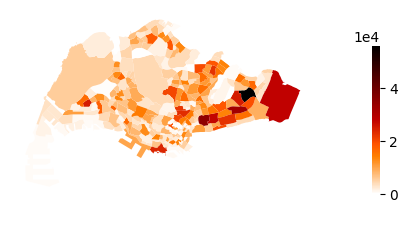

VH total = 2106284.570782499
PT total  = 4205907
ratio(mode/PT) = 0.5007919982021711
Global median (mode/PT) ratio used for fallbacks = 0.5387931034482759
TRAVEL_MODE
PT    30312
VH    14976
WK     6839
Name: count, dtype: int64


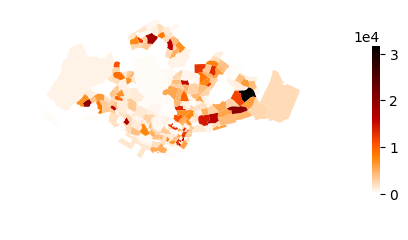

WK total = 966262.4686827576
PT total  = 4205907
ratio(mode/PT) = 0.22973938051477544
Global median (mode/PT) ratio used for fallbacks = 0.1935483870967742
Period fri
TRAVEL_MODE
PT    30312
VH    14976
WK     6839
Name: count, dtype: int64


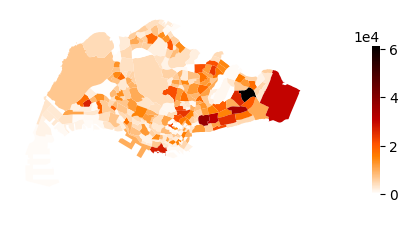

VH total = 2254708.039984048
PT total  = 4506101
ratio(mode/PT) = 0.500367843504628
Global median (mode/PT) ratio used for fallbacks = 0.5387931034482759
TRAVEL_MODE
PT    30312
VH    14976
WK     6839
Name: count, dtype: int64


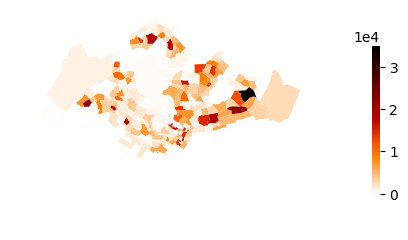

WK total = 1038746.6333183526
PT total  = 4506101
ratio(mode/PT) = 0.23052005121908112
Global median (mode/PT) ratio used for fallbacks = 0.1935483870967742
Period sat
TRAVEL_MODE
PT    30312
VH    14976
WK     6839
Name: count, dtype: int64


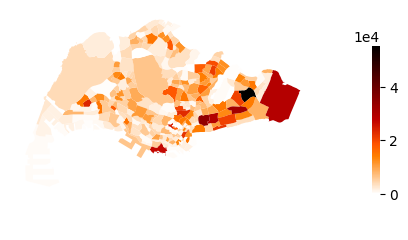

VH total = 1919489.4716556114
PT total  = 3877442
ratio(mode/PT) = 0.4950401506084711
Global median (mode/PT) ratio used for fallbacks = 0.5387931034482759
TRAVEL_MODE
PT    30312
VH    14976
WK     6839
Name: count, dtype: int64


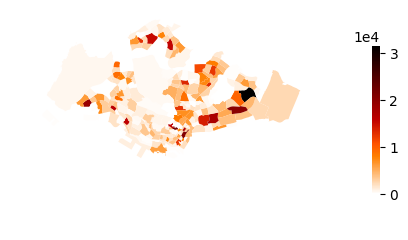

WK total = 907235.7507907259
PT total  = 3877442
ratio(mode/PT) = 0.23397790367740534
Global median (mode/PT) ratio used for fallbacks = 0.1935483870967742


In [ ]:
def plot_space_subzone(df_, att_, maxx):
    figx, figy = 5.5, 5.5

    # Load subzone geometries
    data_subzone = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
    data_subzone = data_subzone[['SUBZONE_C', 'geometry']]

    # Merge counts into geometries
    df_geo = data_subzone.merge(df_, left_on='SUBZONE_C', right_on=att_, how='left')
    # Drop original attribute column but keep SUBZONE_C for labels
    df_geo.drop(columns=[att_], inplace=True)
    df_geo['COUNT'] = df_geo['COUNT'].fillna(0)

    # Prepare colormap and normalization
    norm = mpl.colors.Normalize(vmin=0, vmax=maxx)
    cmap = cm.get_cmap('gist_heat_r') #viridis gist_heat_r inferno plasma afmhot

    fig, ax = plt.subplots(figsize=(figx, figy))
    df_geo.plot(
        column='COUNT',
        cmap=cmap,
        norm=norm,
        ax=ax,
        edgecolor='none',
        linewidth=0,
        legend=True,
        alpha=1.0,
        antialiased=True,
        legend_kwds={'shrink': .35}
    )

    cbax = fig.axes[1]
    cbax.ticklabel_format(style='sci', scilimits=(0,0), axis='both')

    # --- Remove border line around colorbar ---
    for spine in cbax.spines.values():
        spine.set_visible(False)

    #data_subzone.plot(ax=ax, color='none', edgecolor='none') #black , linewidth=0.2

    ax.set_axis_off()
    fname = f'prior_{reg}_trip_generation.png'
    #plt.savefig(path_od_figure + fname, dpi=400, bbox_inches='tight')
    plt.show()

#######################################

week_days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
modes = ['VH', 'WK']
reg = 'sgp'

for week_day in week_days:
    print(f'Period {week_day}')
    for mode in modes:
        # --- 1) Smart-card PT generation per origin ---
        df_sc = pd.read_csv(path_od_data + f'data_{reg}_sc_2022_period_{week_day}.csv', usecols=['ORIGIN_SUBZONE', 'COUNT'])
        df_sc = df_sc.groupby('ORIGIN_SUBZONE', as_index=False)['COUNT'].sum()  # PT counts by origin
        df_sc.to_csv(path_od_result + f'prior_{reg}_trip_generation_PT_{week_day}.csv', index=False)

        # --- 2) Load HTS and compute per-origin counts for PT and target mode ---
        df_hts = pd.read_csv(path_od_data + f'data_{reg}_hts_2022_period.csv')

        print(df_hts['TRAVEL_MODE'].value_counts())
        N_pt = len(df_hts[df_hts['TRAVEL_MODE'] == 'PT'])
        N_m = len(df_hts[df_hts['TRAVEL_MODE'] == mode])
        #print('ratio ', N_m/N_pt)

        # Count trips by origin for PT and for target mode
        pt_by_o = (df_hts.loc[df_hts['TRAVEL_MODE'] == 'PT', ['ORIGIN_SUBZONE']]
                        .groupby('ORIGIN_SUBZONE', as_index=False).size()
                        .rename(columns={'size': 'COUNT_PT'}))

        m_by_o = (df_hts.loc[df_hts['TRAVEL_MODE'] == mode, ['ORIGIN_SUBZONE']]
                        .groupby('ORIGIN_SUBZONE', as_index=False).size()
                        .rename(columns={'size': f'COUNT_{mode}'}))

        # --- 3) Per-origin ratio = COUNT_mode / COUNT_PT (from HTS) ---
        df_ratio = pt_by_o.merge(m_by_o, on='ORIGIN_SUBZONE', how='outer')
        df_ratio['COUNT_PT'] = df_ratio['COUNT_PT'].fillna(0)
        df_ratio[f'COUNT_{mode}'] = df_ratio[f'COUNT_{mode}'].fillna(0)

        # Raw ratio with safe division
        df_ratio['RATIO'] = np.where(df_ratio['COUNT_PT'] > 0,
                                    df_ratio[f'COUNT_{mode}'] / df_ratio['COUNT_PT'],
                                    np.nan)

        # Robust fallback for missing/undefined ratios:
        global_median = df_ratio['RATIO'].median(skipna=True)
        if np.isnan(global_median):
            global_median = 0.0  # if literally no info in HTS


        # --- 4) Apply ratio to smart-card PT counts to predict target-mode generation ---
        df = df_sc.merge(df_ratio[['ORIGIN_SUBZONE', 'RATIO']], on='ORIGIN_SUBZONE', how='left')
        df['RATIO'] = df['RATIO'].fillna(0)  # global_median unseen in HTS but present in SC

        #if mode == 'WK':
        #    df['RATIO'] = df['RATIO']
        df['COUNT'] = df['COUNT'] * df['RATIO']

        df_out = df[['ORIGIN_SUBZONE', 'COUNT']].copy()

        # --- 5) Save, plot, diagnostics ---
        df_out.to_csv(path_od_result + f'prior_{reg}_trip_generation_{mode}_{week_day}.csv', index=False)
        plot_space_subzone(df_out, 'ORIGIN_SUBZONE', df_out['COUNT'].max())

        print(f'{mode} total =', df_out['COUNT'].sum())
        print('PT total  =', df_sc['COUNT'].sum())
        if df_sc['COUNT'].sum() > 0:
            print('ratio(mode/PT) =', df_out['COUNT'].sum() / df_sc['COUNT'].sum())
        print('Global median (mode/PT) ratio used for fallbacks =', float(global_median))


## Temporal prior

Period mon


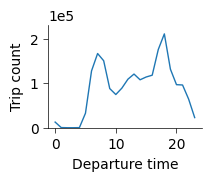

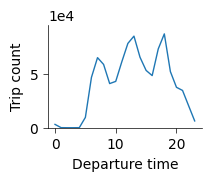

Period tue


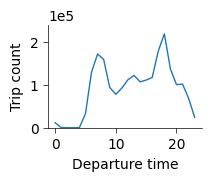

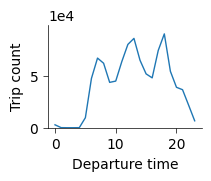

Period wed


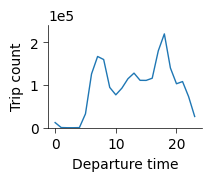

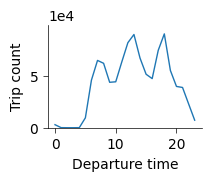

Period thu


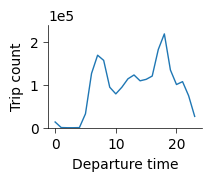

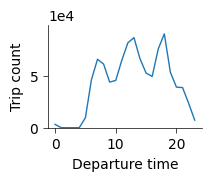

Period fri


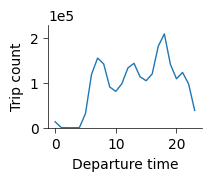

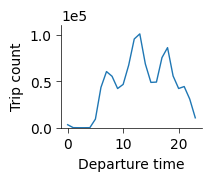

Period sat


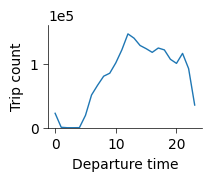

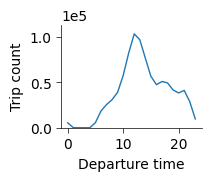

Period sun


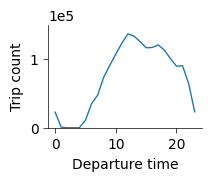

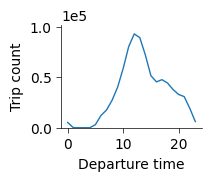

In [ ]:
def plot_departure_line(df_, maxz):
    """
    Plot departure time distribution as a professional line chart.

    Parameters
    ----------
    df_ : DataFrame
        Must contain ['TRIP_STARTTIME', 'COUNT'] columns.
    maxz : float
        Maximum y value (used for scaling the y-axis).
    """

    # -----------------------------
    # Data prep
    # -----------------------------
    df_plot = df_.copy()
    fig, ax = plt.subplots(figsize=(fig_x, fig_y), constrained_layout=True)

    # -----------------------------
    # Line plot
    # -----------------------------
    ax.plot(
        df_plot['TRIP_STARTTIME'],
        df_plot['COUNT'],
        #color='darkcyan',
        linewidth=1.0,
        #marker='o',
        #markersize=4,
        label="Trips"
    )

    # -----------------------------
    # Axis formatting
    # -----------------------------
    ax.set_ylim(0, maxz*1.1)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    # Labels
    ax.set_xlabel("Departure time")
    ax.set_ylabel("Trip count")

    # -----------------------------
    # Clean style
    # -----------------------------
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major')

    # -----------------------------
    # Clean style: thin spines
    # -----------------------------
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', width=0.5)

    # Legend
    #ax.legend(frameon=False)

    # -----------------------------
    # Export-ready
    # -----------------------------
    # out_path = path_od_figure + "prior_seoul_departure_time_line.png"
    # fig.savefig(out_path, dpi=600, bbox_inches='tight', facecolor='white')

    plt.show()


def estimate_all_mode_via_smoothing(
    survey_df,
    smartcard_df,
    window = 2
):
    """
    Estimate total (all-mode) trips per hour by smoothing the survey's PT share
    and scaling the smart-card PT counts.

    Parameters
    ----------
    survey_df : DataFrame
        Must contain columns [time_col, all_col, pt_col].
    smartcard_df : DataFrame
        Must contain columns [time_col, sc_col].
    time_col : str
        Name of the hour column (e.g. 'TRIP_STARTTIME').
    all_col : str
        Name of the survey's all-mode count column.
    pt_col : str
        Name of the survey's transit (PT) count column.
    sc_col : str
        Name of the smart-card transit count column.
    window : int
        Half‐window size for centered smoothing.  The smoother uses
        a window of length (2*window + 1).

    Returns
    -------
    DataFrame
        One row per hour, with columns:
          - time_col
          - phi_obs         : raw PT share from survey
          - phi_smooth      : smoothed PT share
          - COUNT_SC        : smart-card PT count
          - EST_COUNT_ALL   : estimated all-mode trips
    """

    time_col = 'TRIP_STARTTIME'
    all_col = 'COUNT_ALL'
    pt_col = 'COUNT_PT'
    sc_col = 'COUNT_SC'

    # 1) Compute raw PT share from survey
    df = survey_df[[time_col, all_col, pt_col]].copy()
    df['phi_obs'] = df[pt_col] / df[all_col]

    # 2) Smooth the share with a centered rolling window
    roll_len = 2 * window + 1
    df['phi_smooth'] = (
        df
        .sort_values(time_col)
        .set_index(time_col)['phi_obs']
        .rolling(window=roll_len, center=True, min_periods=1)
        .mean()
        .reset_index(drop=True)
    )

    # 3) Merge in smart-card counts
    result = (
        pd.merge(
            df[[time_col, 'phi_obs', 'phi_smooth']],
            smartcard_df[[time_col, sc_col]],
            on=time_col,
            how='left'
        )
    )

    # 4) Invert the smoothed share to estimate all-mode trips
    result['EST_COUNT_ALL'] = result[sc_col] / result['phi_smooth']

    return result

###############################
colors = ['tab:red','darkcyan']
fig_x = 2
fig_y = 1.7

week_days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
modes = ['VH', 'WK']
reg = 'sgp'

df_hts = pd.read_csv(path_od_data + f'data_{reg}_hts_2022_period.csv')
df_hts['COUNT'] = 1

for week_day in week_days:
    print(f'Period {week_day}')
    for mode in modes:
        df1_ = df_hts[df_hts['TRAVEL_MODE'] == mode]
        df1_ = df1_[['TRIP_STARTTIME', 'COUNT']]
        df1_['COUNT'] = df1_.groupby(['TRIP_STARTTIME'])['COUNT'].transform('sum')
        df1_.drop_duplicates(inplace = True)
        df1_.sort_values('TRIP_STARTTIME', inplace=True)
        df1_.rename(columns = {'COUNT':'COUNT_ALL'}, inplace = True)

        df2_ = df_hts[df_hts['TRAVEL_MODE'] == 'PT']
        df2_ = df2_[['TRIP_STARTTIME', 'COUNT']]
        df2_['COUNT'] = df2_.groupby(['TRIP_STARTTIME'])['COUNT'].transform('sum')
        df2_.drop_duplicates(inplace = True)
        df2_.sort_values('TRIP_STARTTIME', inplace=True)
        df2_.rename(columns = {'COUNT':'COUNT_PT'}, inplace = True)

        survey_df = pd.merge(df1_, df2_, on='TRIP_STARTTIME')

        df_sc = pd.read_csv(path_od_data + f'data_{reg}_sc_2022_period_{week_day}.csv')
        df_sc = df_sc[['TRIP_STARTTIME', 'COUNT']]
        df_sc['COUNT'] = df_sc.groupby(['TRIP_STARTTIME'])['COUNT'].transform('sum')
        df_sc.drop_duplicates(inplace = True)
        df_sc.sort_values('TRIP_STARTTIME', inplace=True)
        df_sc.to_csv(path_od_result + f'prior_{reg}_departure_time_PT_{week_day}.csv', index=False)
        df_sc.rename(columns = {'COUNT':'COUNT_SC'}, inplace = True)

        df = estimate_all_mode_via_smoothing(survey_df, df_sc)
        df.rename(columns = {'EST_COUNT_ALL':'COUNT'}, inplace = True)

        df = df[['TRIP_STARTTIME', 'COUNT']]

        df_trip_total = pd.read_csv(path_od_result + f'prior_{reg}_trip_generation_{mode}_{week_day}.csv')
        trip_total = df_trip_total['COUNT'].sum()
        df['COUNT'] = df['COUNT'] * trip_total / df['COUNT'].sum()

        df.to_csv(path_od_result + f'prior_{reg}_departure_time_{mode}_{week_day}.csv', index=False)

        plot_departure_line(df, df['COUNT'].max())

# ARL Learning

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
import time

def predict_ratio_to_smartcard_xgb(survey_df, smartcard_df):
    """
    Trains an XGBoost regression model on survey_df to predict 'RATIO',
    then applies the model to predict this value for smartcard_df.

    Parameters:
    - survey_df (pd.DataFrame): Data with ground truth 'RATIO' column.
    - smartcard_df (pd.DataFrame): Data to receive predicted 'RATIO' values.

    Returns:
    - pd.DataFrame: smartcard_df with new 'RATIO' and 'OT_COUNT' columns.
    """
    target_col = 'RATIO'
    if target_col not in survey_df.columns:
        raise ValueError(f"'{target_col}' not found in survey_df")

    # 1) Fit scaler on training features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(survey_df[att_cluster])

    # 2) Wrap in DataFrame to adjust one column
    X_train_df = pd.DataFrame(X_train_scaled, columns=att_cluster)

    # 3) Prepare final training array
    X_train = X_train_df.values
    y_train = survey_df[target_col]

    # 4) Train XGBoost regressor
    model = XGBRegressor(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1
    )
    model.fit(X_train, y_train)

    # 5) Scale smartcard features and apply same weight
    X_pred_scaled = scaler.transform(smartcard_df[att_cluster])
    X_pred_df = pd.DataFrame(X_pred_scaled, columns=att_cluster)

    X_pred = X_pred_df.values

    # 6) Predict, clip negatives, and compute OT_COUNT
    preds = model.predict(X_pred)
    preds = np.maximum(preds, 0)

    smartcard_df = smartcard_df.copy()
    smartcard_df[target_col] = preds
    smartcard_df['OT_COUNT'] = smartcard_df[target_col] * smartcard_df['PT_COUNT']

    # 7) Return only the desired columns
    return smartcard_df[att_subzone + att_coordinate + ['TRIP_DISTANCE', 'OT_COUNT', 'PT_COUNT']]


###### with time ########
def compute_distance(df, att):
    """
    Computes the haversine distance between origin and destination coordinates in kilometers.
    att: List with [origin_lon, dest_lon, origin_lat, dest_lat]
    """
    lon1 = np.radians(df[att[0]])
    lon2 = np.radians(df[att[1]])
    lat1 = np.radians(df[att[2]])
    lat2 = np.radians(df[att[3]])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return 6371 * c  # Radius of Earth in km

def od_transit_share(df):
    df_mode = df[['ORIGIN_SUBZONE',
                  'TRIP_STARTTIME',
                  'DESTINATION_SUBZONE',
                  'PT_COUNT'
                  ]].copy()
    df_mode['PT_COUNT'] = df_mode.groupby(['ORIGIN_SUBZONE',
                                           'TRIP_STARTTIME',
                                           'DESTINATION_SUBZONE'
                                           ])['PT_COUNT'].transform('sum')
    df_mode.drop_duplicates(inplace=True)
    df_mode['OD_TRANSIT_DEMAND'] = df_mode['PT_COUNT'] / df_mode['PT_COUNT'].sum()
    df_mode.drop(columns=['PT_COUNT'], inplace=True)
    return df_mode

def transit_mode_share(df, att):
    # Select necessary columns and create a count column
    df_mode = df[[att, 'TRAVEL_MODE', 'COUNT']].copy()
    # Aggregate count by attribute and travel mode
    df_mode = df_mode.groupby([att, 'TRAVEL_MODE'], as_index=False)['COUNT'].sum()
    # Drop duplicates
    df_mode.drop_duplicates(inplace=True)
    # Compute probabilities
    total_count = df_mode['COUNT'].sum()
    df_mode['Prob'] = df_mode['COUNT'] / total_count
    df_mode.drop(columns=['COUNT'], inplace=True)
    # Normalize probabilities within each attribute group
    df_mode['Prob'] /= df_mode.groupby(att)['Prob'].transform('sum')
    # Filter for public transport (PT) mode only
    df_mode = df_mode[df_mode['TRAVEL_MODE'] == 'PT']
    # Rename probability column and drop 'TRAVEL_MODE'
    df_mode.rename(columns={'Prob': att + '_TRANSIT_DEMAND'}, inplace=True)
    df_mode.drop(columns=['TRAVEL_MODE'], inplace=True)
    return df_mode

def demand_share(df, att):
    # Select necessary columns and create a count column
    df_demand = df[[att, 'COUNT']].copy()
    # Aggregate count by attribute and travel mode
    df_demand = df_demand.groupby([att], as_index=False)['COUNT'].sum()
    # Drop duplicates
    df_demand.drop_duplicates(inplace=True)
    # Compute probabilities
    total_count = df_demand['COUNT'].sum()
    df_demand['Prob'] = df_demand['COUNT'] / total_count
    df_demand.drop(columns=['COUNT'], inplace=True)
    # Rename probability column
    df_demand.rename(columns={'Prob': att + '_DEMAND'}, inplace=True)
    return df_demand
################################################


def add_mode_ratio_with_smooth(
    survey_df,
    walk_mode=False,
    walk_threshold=5,
    clip_ratio_value=5,
    lambdaa=5,
    eps=1e-9
):
    """
    Smoothed OT/PT ratio per (ORIGIN_SUBZONE, DESTINATION_SUBZONE, TRIP_STARTTIME).
    The prior mu is time-of-day specific and OD-marginal:
      - mu_O at (ORIGIN_SUBZONE, TRIP_STARTTIME)
      - mu_D at (DESTINATION_SUBZONE, TRIP_STARTTIME)
    They are blended with PT-count weights. If both are missing, fall back to a
    time-specific global prior at TRIP_STARTTIME.

    Assumes `att_subzone = ['ORIGIN_SUBZONE','DESTINATION_SUBZONE','TRIP_STARTTIME']`
    exists in the outer scope (same as your original code).
    """

    # -------------------------------
    # 1) OD-time group PT/OT counts
    # -------------------------------
    transit_df = survey_df.loc[survey_df['TRAVEL_MODE'] == 'PT', att_subzone].copy()
    N_pt = len(transit_df)
    transit_df['PT_COUNT'] = 1
    transit_df['PT_COUNT'] = transit_df.groupby(att_subzone)['PT_COUNT'].transform('sum')
    transit_df = transit_df[att_subzone + ['PT_COUNT']].drop_duplicates()

    other_df = survey_df.loc[survey_df['TRAVEL_MODE'] == 'OT', att_subzone].copy()
    N_ot = len(other_df)
    other_df['OT_COUNT'] = 1
    other_df['OT_COUNT'] = other_df.groupby(att_subzone)['OT_COUNT'].transform('sum')
    other_df = other_df[att_subzone + ['OT_COUNT']].drop_duplicates()

    survey_df_ = survey_df.copy()
    survey_df_ = survey_df_.merge(transit_df, on=att_subzone)
    survey_df_ = survey_df_.merge(other_df,   on=att_subzone)
    survey_df_['COUNT']    = survey_df_['PT_COUNT'] + survey_df_['OT_COUNT']
    survey_df_['RATIO']    = survey_df_['OT_COUNT'] / (survey_df_['PT_COUNT'] + eps)

    # ------------------------------------------------------------
    # 2) Time-of-day specific priors at origin and destination
    # ------------------------------------------------------------
    orig_pivot = (
        survey_df
        .groupby(['ORIGIN_SUBZONE', 'TRIP_STARTTIME', 'TRAVEL_MODE'])
        .size()
        .unstack(fill_value=0)
        .rename(columns={'PT': 'PT_O', 'OT': 'OT_O'})
        .reset_index()
    )
    orig_pivot['mu_O'] = orig_pivot['OT_O'] / (orig_pivot['PT_O'] + eps)

    dest_pivot = (
        survey_df
        .groupby(['DESTINATION_SUBZONE', 'TRIP_STARTTIME', 'TRAVEL_MODE'])
        .size()
        .unstack(fill_value=0)
        .rename(columns={'PT': 'PT_D', 'OT': 'OT_D'})
        .reset_index()
    )
    dest_pivot['mu_D'] = dest_pivot['OT_D'] / (dest_pivot['PT_D'] + eps)

    # ------------------------------------------------------------
    # 3) Time-of-day specific global prior as fallback: mu_global(t)
    # ------------------------------------------------------------
    global_time = (
        survey_df
        .groupby(['TRIP_STARTTIME', 'TRAVEL_MODE'])
        .size()
        .unstack(fill_value=0)
        .rename(columns={'PT': 'PT_T', 'OT': 'OT_T'})
        .reset_index()
    )
    global_time['mu_T'] = global_time['OT_T'] / (global_time['PT_T'] + eps)

    # ------------------------------------------------------------
    # 4) Merge priors back and blend mu_O and mu_D (PT-weighted)
    # ------------------------------------------------------------
    survey_df_ = survey_df_.merge(
        orig_pivot[['ORIGIN_SUBZONE', 'TRIP_STARTTIME', 'mu_O', 'PT_O']],
        on=['ORIGIN_SUBZONE', 'TRIP_STARTTIME'],
        how='left'
    )
    survey_df_ = survey_df_.merge(
        dest_pivot[['DESTINATION_SUBZONE', 'TRIP_STARTTIME', 'mu_D', 'PT_D']],
        on=['DESTINATION_SUBZONE', 'TRIP_STARTTIME'],
        how='left'
    )
    survey_df_ = survey_df_.merge(
        global_time[['TRIP_STARTTIME', 'mu_T']],
        on='TRIP_STARTTIME',
        how='left'
    )

    # PT weights for blending; if both zero, we'll fallback to mu_T
    w_o = survey_df_['PT_O'].fillna(0.0)
    w_d = survey_df_['PT_D'].fillna(0.0)
    w_sum = w_o + w_d

    # PT-weighted blend where available
    mu_blend = (w_o * survey_df_['mu_O'] + w_d * survey_df_['mu_D']) / (w_sum.replace(0, np.nan))

    # Fallback sequence: blended -> mu_O -> mu_D -> time-global mu_T -> 0
    mu = (
        mu_blend
        .fillna(survey_df_['mu_O'])
        .fillna(survey_df_['mu_D'])
        .fillna(survey_df_['mu_T'])
        .fillna(0.0)
    )

    # ---------------------------------------
    # 5) Apply shrinkage with time-specific mu
    # ---------------------------------------

    # decay parameter: controls how quickly ww2 approaches 1
    # Use 98th percentile instead of max
    max_count = survey_df_['COUNT'].max()
    scale_val = survey_df_['COUNT'].quantile(0.98)
    p = lambdaa  # curvature control; higher p = slower rise

    # Compute ww2 with clipping
    survey_df_['ww2'] = (survey_df_['COUNT'] / scale_val) ** p
    survey_df_['ww2'] = survey_df_['ww2'].clip(lower=0.0, upper=1.0)

    # Apply smoothing
    survey_df_['RATIO'] = (
        survey_df_['ww2'] * survey_df_['RATIO'] +
        (1 - survey_df_['ww2']) * mu
    )

    # Clean up
    survey_df_.drop(columns=['ww2'], inplace=True)


    # Force OT_COUNT = 0 for walking-distance trips
    if walk_mode:
        survey_df_.loc[survey_df_['TRIP_DISTANCE'] >= walk_threshold, 'RATIO'] = 0

    # clip
    if clip_ratio_value is not None:
        survey_df_['RATIO'] = survey_df_['RATIO'].clip(upper=clip_ratio_value*mu)

    # Optional convenience: smoothed OT_COUNT, then drop internals
    survey_df_['OT_COUNT'] = survey_df_['PT_COUNT'] * survey_df_['RATIO']
    survey_df_.drop(
        columns=['mu_O','mu_D','mu_T','PT_O','PT_D'],
        inplace=True,
        errors='ignore'
    )

    return survey_df_



####################################
start_time = time.time()

################################
att_subzone = ['ORIGIN_SUBZONE',
               'DESTINATION_SUBZONE',
               'TRIP_STARTTIME'
               ]
att_coordinate = ['ORIGIN_SUBZONE_X',
                  'ORIGIN_SUBZONE_Y',
                  'DESTINATION_SUBZONE_X',
                  'DESTINATION_SUBZONE_Y'
                  ]
att_cluster = [ 'TRIP_DISTANCE',
               'TRIP_STARTTIME_',
               'OD_TRANSIT_DEMAND',
               'ORIGIN_SUBZONE_DEMAND',
               'DESTINATION_SUBZONE_DEMAND'
               ]


week_days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
reg = 'sgp'


for week_day in week_days:
    print(f'week_day = {week_day}')

    for kk in [i*0.2 for i in range(5,6)]: # For k = 1.0
        k = round(kk, 1)
        print(f'k = {k}')

        for mode in ['WK', 'VH']:
            od_demand_df = pd.read_csv(path_od_result + f'prior_{reg}_trip_generation_{mode}_{week_day}.csv')
            od_demand_df['DESTINATION_SUBZONE'] = od_demand_df['ORIGIN_SUBZONE']
            smartcard_df = pd.read_csv(path_od_data + f'data_{reg}_sc_2022_period_{week_day}.csv')
            survey_df = pd.read_csv(path_od_data + f'data_{reg}_hts_2022_period.csv')

            if mode == 'VH':
                survey_df = survey_df[survey_df['TRAVEL_MODE'] != 'WK']
                survey_df.replace({'VH': 'OT'}, inplace=True)
            elif mode == 'WK':
                survey_df = survey_df[survey_df['TRAVEL_MODE'] != 'VH']
                survey_df.replace({'WK': 'OT'}, inplace=True)

            N_pt = len(survey_df[survey_df['TRAVEL_MODE'] == 'PT'])
            N_ot = len(survey_df[survey_df['TRAVEL_MODE'] == 'OT'])
            current_mode_ratio = N_ot/N_pt
            print(f'Current mode ratio: {current_mode_ratio}')

            attribute_df = survey_df.copy()
            attribute_df['COUNT'] = 1

            smartcard_df.rename(columns={'COUNT': 'PT_COUNT'}, inplace=True)
            smartcard_df['PT_COUNT'] = smartcard_df.groupby(att_subzone)['PT_COUNT'].transform('sum')
            smartcard_df = smartcard_df[att_subzone + att_coordinate + ['PT_COUNT']].drop_duplicates()

            # keep the frequency of smaples in supervised learning
            survey_df['TRIP_DISTANCE'] = compute_distance(survey_df, ['ORIGIN_SUBZONE_X', 'DESTINATION_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE_Y'])

            wk_mode = False
            if mode == 'WK':
                wk_mode = True

            wk_threshold = 3.5
            clip_ratio = None
            survey_df = add_mode_ratio_with_smooth(survey_df.copy(),
                                                walk_mode=wk_mode,
                                                walk_threshold=wk_threshold,
                                                clip_ratio_value=clip_ratio,
                                                lambdaa=k)
            survey_df = survey_df[att_subzone + att_coordinate + ['RATIO', 'TRIP_DISTANCE']]

            smartcard_df['TRIP_STARTTIME_'] = smartcard_df['TRIP_STARTTIME']
            survey_df['TRIP_STARTTIME_'] = survey_df['TRIP_STARTTIME']

            print(len(smartcard_df))
            ####################################

            mode_origin = transit_mode_share(attribute_df, 'ORIGIN_SUBZONE')
            mode_destination = transit_mode_share(attribute_df, 'DESTINATION_SUBZONE')
            demand_origin = demand_share(od_demand_df, 'ORIGIN_SUBZONE')
            demand_destination = demand_share(od_demand_df, 'DESTINATION_SUBZONE')
            demand_od = od_transit_share(smartcard_df)

            smartcard_df = pd.merge(smartcard_df, mode_origin)
            smartcard_df = pd.merge(smartcard_df, mode_destination)
            smartcard_df = pd.merge(smartcard_df, demand_origin)
            smartcard_df = pd.merge(smartcard_df, demand_destination)
            smartcard_df = pd.merge(smartcard_df, demand_od)
            smartcard_df['TRIP_DISTANCE'] = compute_distance(smartcard_df, ['ORIGIN_SUBZONE_X', 'DESTINATION_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE_Y'])
            smartcard_df = smartcard_df[att_subzone + att_coordinate + att_cluster + ['PT_COUNT']]

            survey_df = pd.merge(survey_df, mode_origin)
            survey_df = pd.merge(survey_df, mode_destination)
            survey_df = pd.merge(survey_df, demand_origin)
            survey_df = pd.merge(survey_df, demand_destination)
            survey_df = pd.merge(survey_df, demand_od)

            print('smartcard_df length', len(smartcard_df))

            models = ['xgboost']

            for model in models:
                print(f'Processing the model {model}...')

                smartcard_dff = smartcard_df.copy()
                survey_dff = survey_df.copy()

                smartcard_dff = predict_ratio_to_smartcard_xgb(survey_dff, smartcard_dff)

                if mode == 'WK':
                    # Force OT_COUNT = 0 for walking-distance trips
                    smartcard_dff.loc[smartcard_dff['TRIP_DISTANCE'] >= wk_threshold, 'OT_COUNT'] = 0

                smartcard_dff.drop(columns=['TRIP_DISTANCE'], inplace=True)
                file_output = path_od_result + f'case_{reg}_matrix_{model}_{mode}_{week_day}_{k}.csv'
                smartcard_dff.to_csv(file_output, index=False)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Elapsed time: {elapsed_time:.2f} seconds')

week_day = mon
k = 1.0
Current mode ratio: 0.22562021641594088
528437
smartcard_df length 525789
Processing the model xgboost...
Current mode ratio: 0.49406175771971494
528437
smartcard_df length 525789
Processing the model xgboost...
week_day = tue
k = 1.0
Current mode ratio: 0.22562021641594088
535098
smartcard_df length 532447
Processing the model xgboost...
Current mode ratio: 0.49406175771971494
535098
smartcard_df length 532447
Processing the model xgboost...
week_day = wed
k = 1.0
Current mode ratio: 0.22562021641594088
538746
smartcard_df length 536081
Processing the model xgboost...
Current mode ratio: 0.49406175771971494
538746
smartcard_df length 536081
Processing the model xgboost...
week_day = thu
k = 1.0
Current mode ratio: 0.22562021641594088
538149
smartcard_df length 535471
Processing the model xgboost...
Current mode ratio: 0.49406175771971494
538149
smartcard_df length 535471
Processing the model xgboost...
week_day = fri
k = 1.0
Current mode ratio: 0.225620216415940

# Proportion fitting

In [ ]:
#Mode specific

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy.stats import gaussian_kde
import time

#####################################


def _circular_kernel(hours: int, bandwidth: float) -> np.ndarray:
    hrs = np.arange(hours)
    D = np.abs(hrs[:, None] - hrs[None, :])
    D = np.minimum(D, hours - D)
    K = np.exp(-0.5 * (D / float(bandwidth)) ** 2)
    K /= K.sum(axis=1, keepdims=True)   # row-stochastic, ~doubly-stochastic for circular Gaussian
    return K

def fit_to_marginals_3way(
    df: pd.DataFrame,
    global_departures,                    # length-H array/Series: sum over o,d per hour
    origin_totals,                        # dict/Series: {origin -> total over d,t}
    destination_totals,                   # dict/Series: {destination -> total over o,t}
    smooth_seed: bool = True,
    bandwidth: float = 5, #1.5
    origin_col: str = 'ORIGIN_SUBZONE',
    dest_col: str = 'DESTINATION_SUBZONE',
    time_col: str = 'TRIP_STARTTIME',     # integer 0..H-1
    ot_col: str = 'COUNT',
    hours: int = 24,
    # Optional smoothing seed
    # IPF options
    max_iter: int = 1000,
    tol: float = 1e-10,
) -> pd.DataFrame:
    """
    Fits df's (o,d,t) counts to three marginals via 3-way IPF:
      - time totals G_t (global departures),
      - origin totals O_o,
      - destination totals D_d.
    Optionally smooths each OD time series first to create a seed.
    Returns SAME rows as df with OT_COUNT overwritten (duplicates preserved, reweighted).
    """

    # ---------- Prepare inputs ----------
    # Global departures G (length H)
    if isinstance(global_departures, pd.Series):
        if global_departures.index.dtype.kind in {'i','u'}:
            G = global_departures.reindex(range(hours)).to_numpy(float)
        else:
            G = global_departures.to_numpy(float)
    else:
        G = np.asarray(global_departures, dtype=float)
    if G.shape[0] != hours:
        raise ValueError("global_departures must have length = `hours`.")

    # Origin totals O (map from origin -> total)
    if isinstance(origin_totals, pd.Series):
        O_map = origin_totals.to_dict()
    else:
        O_map = dict(origin_totals)

    # Destination totals D (map from destination -> total)
    if isinstance(destination_totals, pd.Series):
        D_map = destination_totals.to_dict()
    else:
        D_map = dict(destination_totals)

    # Check grand totals consistency (small renorm if needed)
    T_g = G.sum()
    T_o = np.sum(list(O_map.values()))
    T_d = np.sum(list(D_map.values()))
    if T_g <= 0 or T_o <= 0 or T_d <= 0:
        raise ValueError("All marginals must have positive totals.")
    # Normalize G to the average of O and D if slightly off
    target_total = 0.5 * (T_o + T_d)
    if not np.isclose(T_g, target_total):
        G = G * (target_total / T_g)

    # ---------- Handle duplicates, keep weights to restore same rows ----------
    out = df.copy()
    out['_orig_order__'] = np.arange(len(out))
    key_cols = [origin_col, dest_col, time_col]

    grp_sum = out.groupby(key_cols, as_index=False)[ot_col].sum().rename(columns={ot_col: '__agg'})
    # weights for distributing fitted (o,d,t) back to duplicate rows
    tot_per_key = out.groupby(key_cols)[ot_col].transform('sum')
    cnt_per_key = out.groupby(key_cols)[ot_col].transform('size')
    out['__w'] = np.where(tot_per_key > 0, out[ot_col] / tot_per_key, 1.0 / cnt_per_key)

    # ---------- Build complete cube (o x d x t) ----------
    # Get unique ordered lists for stable indexing
    origins = grp_sum[origin_col].unique().tolist()
    dests   = grp_sum[dest_col].unique().tolist()
    O = len(origins); D = len(dests); H = hours

    # index maps
    o2i = {o:i for i,o in enumerate(origins)}
    d2j = {d:j for j,d in enumerate(dests)}

    # aggregate to cube X (O x D x H)
    X = np.zeros((O, D, H), dtype=float)
    for _, row in grp_sum.iterrows():
        i = o2i[row[origin_col]]
        j = d2j[row[dest_col]]
        t = int(row[time_col])
        if 0 <= t < H:
            X[i, j, t] = row['__agg']
        else:
            raise ValueError(f"Hour {t} out of [0,{H-1}].")

    # ---------- Optional smoothing seed over time per (o,d) ----------
    Seed = X.copy()
    if smooth_seed:
        K = _circular_kernel(H, bandwidth)  # HxH
        # apply to time axis per (o,d)
        Seed = np.tensordot(Seed, K.T, axes=(2, 0))  # (O,D,H) * (H,H)^T -> (O,D,H)
        # preserve each (o,d) total
        S0 = X.sum(axis=2, keepdims=True)
        S1 = Seed.sum(axis=2, keepdims=True)
        Seed *= np.divide(S0, np.maximum(S1, 1e-16))

    # ---------- Build target marginals arrays ----------
    # Origin totals array length O
    O_vec = np.array([O_map.get(o, 0.0) for o in origins], dtype=float)
    # Destination totals array length D
    D_vec = np.array([D_map.get(d, 0.0) for d in dests], dtype=float)

    # Sanity: scale Seed to have consistent grand total with targets
    target_total = G.sum()
    seed_total = Seed.sum()
    if seed_total <= 0:
        raise ValueError("Seed has zero total.")
    Seed *= (target_total / seed_total)

    # ---------- 3-way IPF (raking) ----------
    Y = Seed.copy()
    eps = 1e-16

    for _ in range(max_iter):

        # 2) Origin scaling: match O_o (sum over d,t)
        row_o = Y.sum(axis=(1,2))  # sum over d,t -> O
        scale_o = np.divide(O_vec, np.maximum(row_o, eps))
        Y *= scale_o[:, np.newaxis, np.newaxis]

        # 3) Destination scaling: match D_d (sum over o,t)
        col_d = Y.sum(axis=(0,2))  # sum over o,t -> D
        scale_d = np.divide(D_vec, np.maximum(col_d, eps))
        Y *= scale_d[np.newaxis, :, np.newaxis]

        # 1) Time scaling: match global departures per hour
        col_t = Y.sum(axis=(0,1))  # sum over o,d -> H
        scale_t = np.divide(G, np.maximum(col_t, eps))
        Y *= scale_t[np.newaxis, np.newaxis, :]

        # Convergence: check max abs error in all three marginals
        err_t = np.max(np.abs(Y.sum(axis=(0,1)) - G))
        err_o = np.max(np.abs(Y.sum(axis=(1,2)) - O_vec))
        err_d = np.max(np.abs(Y.sum(axis=(0,2)) - D_vec))
        if max(err_t, err_o, err_d) < tol:
            break

    # ---------- Long table (o,d,t) from Y ----------
    records = []
    for i, o in enumerate(origins):
        for j, d in enumerate(dests):
            for t in range(H):
                if Y[i, j, t] != 0.0:
                    records.append((o, d, t, Y[i, j, t]))
    Y_long = pd.DataFrame(records, columns=[origin_col, dest_col, time_col, '__fit_odt'])

    # ---------- Distribute back to original rows (keep all columns) ----------
    out = out.merge(Y_long, on=[origin_col, dest_col, time_col], how='left')
    out[ot_col] = out['__fit_odt'] * out['__w']
    out = out.sort_values('_orig_order__').drop(columns=['_orig_order__','__w','__fit_odt'])

    return out



#####################################

att_subzone = ['ORIGIN_SUBZONE',
               'DESTINATION_SUBZONE',
               'TRIP_STARTTIME'
               ] #
att_coordinate = ['ORIGIN_SUBZONE_X',
                  'ORIGIN_SUBZONE_Y',
                  'DESTINATION_SUBZONE_X',
                  'DESTINATION_SUBZONE_Y'
                  ]
att_cluster = ['TRIP_DISTANCE',
               'TRIP_STARTTIME_',
               'OD_TRANSIT_DEMAND',
               'ORIGIN_SUBZONE_DEMAND',
               'DESTINATION_SUBZONE_DEMAND',
               'DESTINATION_SUBZONE_LU_H',
               'DESTINATION_SUBZONE_LU_W',
               'ORIGIN_SUBZONE_LU_H',
               'ORIGIN_SUBZONE_LU_W'
               ]

start_time = time.time()

week_days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'] #
reg = 'sgp'
model = 'xgboost'
bwidth = 2
n_time = 24

for week_day in week_days:
    print(f'week_day = {week_day}')

    od_demand_df_VH = pd.read_csv(path_od_result + f'prior_{reg}_trip_generation_VH_{week_day}.csv')
    od_demand_df_VH['DESTINATION_SUBZONE'] = od_demand_df_VH['ORIGIN_SUBZONE']
    time_demand_df_VH = pd.read_csv(path_od_result + f'prior_{reg}_departure_time_VH_{week_day}.csv')

    od_demand_df_WK = pd.read_csv(path_od_result + f'prior_{reg}_trip_generation_WK_{week_day}.csv')
    od_demand_df_WK['DESTINATION_SUBZONE'] = od_demand_df_WK['ORIGIN_SUBZONE']
    time_demand_df_WK = pd.read_csv(path_od_result + f'prior_{reg}_departure_time_WK_{week_day}.csv')

    od_demand_df_PT = pd.read_csv(path_od_result + f'prior_{reg}_trip_generation_PT_{week_day}.csv')
    od_demand_df_PT['DESTINATION_SUBZONE'] = od_demand_df_PT['ORIGIN_SUBZONE']
    time_demand_df_PT = pd.read_csv(path_od_result + f'prior_{reg}_departure_time_PT_{week_day}.csv')

    G_VH = time_demand_df_VH.groupby('TRIP_STARTTIME')['COUNT'].sum().reindex(range(n_time), fill_value=0.0)
    O_VH = od_demand_df_VH.groupby('ORIGIN_SUBZONE')['COUNT'].sum()
    D_VH = od_demand_df_VH.groupby('DESTINATION_SUBZONE')['COUNT'].sum()

    G_WK = time_demand_df_WK.groupby('TRIP_STARTTIME')['COUNT'].sum().reindex(range(n_time), fill_value=0.0)
    O_WK = od_demand_df_WK.groupby('ORIGIN_SUBZONE')['COUNT'].sum()
    D_WK = od_demand_df_WK.groupby('DESTINATION_SUBZONE')['COUNT'].sum()

    #total_count = od_demand_df['COUNT'].sum()
    total_count_vh = od_demand_df_VH['COUNT'].sum()
    total_count_wk = od_demand_df_WK['COUNT'].sum()
    total_count_pt = od_demand_df_PT['COUNT'].sum()


    sc_df = pd.read_csv(path_od_data + f'data_{reg}_sc_2022_period_{week_day}.csv')
    sc_df = sc_df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME', 'COUNT']]
    sc_df.rename(columns = {'COUNT':'PT_COUNT'}, inplace = True)

    #print('total_count', total_count)
    print('total_count_vh', total_count_vh)
    print('total_count_wk', total_count_wk)
    print('total_count_pt', total_count_pt)

    for kk in [i*0.2 for i in range(5,6)]:
        k = round(kk, 1)
        print(f'Processing the model {model} with k = {k}...')
        result_df_vh = pd.read_csv(path_od_result + f'case_{reg}_matrix_{model}_VH_{week_day}_{k}.csv')
        result_df_wk = pd.read_csv(path_od_result + f'case_{reg}_matrix_{model}_WK_{week_day}_{k}.csv')

        result_df_vh = result_df_vh[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME', 'OT_COUNT']]
        result_df_wk = result_df_wk[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME', 'OT_COUNT']]

        result_df_vh.rename(columns = {'OT_COUNT':'COUNT'}, inplace = True)
        result_df_wk.rename(columns = {'OT_COUNT':'COUNT'}, inplace = True)

        result_df_vh['COUNT'] = result_df_vh['COUNT'] * total_count_vh / result_df_vh['COUNT'].sum()
        result_df_wk['COUNT'] = result_df_wk['COUNT'] * total_count_wk / result_df_wk['COUNT'].sum()

        result_df_vh = fit_to_marginals_3way(result_df_vh, G_VH, O_VH, D_VH, smooth_seed=True,bandwidth=bwidth)
        result_df_wk = fit_to_marginals_3way(result_df_wk, G_WK, O_WK, D_WK, smooth_seed=True,bandwidth=bwidth)

        result_df_vh['COUNT'] = result_df_vh['COUNT'] * total_count_vh / result_df_vh['COUNT'].sum()
        result_df_wk['COUNT'] = result_df_wk['COUNT'] * total_count_wk / result_df_wk['COUNT'].sum()

        result_df_vh.rename(columns = {'COUNT':'VH_COUNT'}, inplace = True)
        result_df_wk.rename(columns = {'COUNT':'WK_COUNT'}, inplace = True)

        result_df = pd.merge(sc_df, result_df_vh, on=['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME'], how='outer')
        result_df = pd.merge(result_df, result_df_wk, on=['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME'], how='outer')
        result_df.fillna(0, inplace=True)

        result_df['COUNT'] = result_df['PT_COUNT'] + result_df['VH_COUNT'] + result_df['WK_COUNT']
        #result_df = fit_to_marginals_3way(result_df, G, O, D, smooth_seed=False)

        print('result_df ', result_df['COUNT'].sum())

        result_df.to_csv( path_od_result + f'case_{reg}_matrix_{model}_{week_day}_{k}.csv', index=False)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Elapsed time: {elapsed_time:.2f} seconds')

week_day = mon
total_count_vh 2106284.570782499
total_count_wk 966262.4686827576
total_count_pt 4205907
Processing the model xgboost with k = 1.0...
result_df  7278454.039465258
week_day = tue
total_count_vh 2177900.7485269094
total_count_wk 1001111.9395746083
total_count_pt 4349814
Processing the model xgboost with k = 1.0...
result_df  7528826.688101518
week_day = wed
total_count_vh 2192446.351644934
total_count_wk 1007154.7824727574
total_count_pt 4376526
Processing the model xgboost with k = 1.0...
result_df  7576127.134117691
week_day = thu
total_count_vh 2182204.428248709
total_count_wk 1003069.4177608106
total_count_pt 4358190
Processing the model xgboost with k = 1.0...
result_df  7543463.846009519
week_day = fri
total_count_vh 2254708.039984048
total_count_wk 1038746.6333183526
total_count_pt 4506101
Processing the model xgboost with k = 1.0...
result_df  7799555.673302404
week_day = sat
total_count_vh 1919489.4716556114
total_count_wk 907235.7507907259
total_count_pt 3877442


# Week-day group proportional fitting

In [ ]:
def _circular_kernel(hours: int, bandwidth: float) -> np.ndarray:
    hrs = np.arange(hours)
    D = np.abs(hrs[:, None] - hrs[None, :])
    D = np.minimum(D, hours - D)
    K = np.exp(-0.5 * (D / float(bandwidth)) ** 2)
    K /= K.sum(axis=1, keepdims=True)   # row-stochastic, ~doubly-stochastic for circular Gaussian
    return K

def fit_to_marginals_3way(
    df: pd.DataFrame,
    global_departures,                    # length-H array/Series: sum over o,d per hour
    origin_totals,                        # dict/Series: {origin -> total over d,t}
    destination_totals,                   # dict/Series: {destination -> total over o,t}
    smooth_seed: bool = True,
    bandwidth: float = 5, #1.5
    origin_col: str = 'ORIGIN_SUBZONE',
    dest_col: str = 'DESTINATION_SUBZONE',
    time_col: str = 'TRIP_STARTTIME',     # integer 0..H-1
    ot_col: str = 'COUNT',
    hours: int = 24,
    # Optional smoothing seed
    # IPF options
    max_iter: int = 1000,
    tol: float = 1e-10,
) -> pd.DataFrame:
    """
    Fits df's (o,d,t) counts to three marginals via 3-way IPF:
      - time totals G_t (global departures),
      - origin totals O_o,
      - destination totals D_d.
    Optionally smooths each OD time series first to create a seed.
    Returns SAME rows as df with OT_COUNT overwritten (duplicates preserved, reweighted).
    """

    # ---------- Prepare inputs ----------
    # Global departures G (length H)
    if isinstance(global_departures, pd.Series):
        if global_departures.index.dtype.kind in {'i','u'}:
            G = global_departures.reindex(range(hours)).to_numpy(float)
        else:
            G = global_departures.to_numpy(float)
    else:
        G = np.asarray(global_departures, dtype=float)
    if G.shape[0] != hours:
        raise ValueError("global_departures must have length = `hours`.")

    # Origin totals O (map from origin -> total)
    if isinstance(origin_totals, pd.Series):
        O_map = origin_totals.to_dict()
    else:
        O_map = dict(origin_totals)

    # Destination totals D (map from destination -> total)
    if isinstance(destination_totals, pd.Series):
        D_map = destination_totals.to_dict()
    else:
        D_map = dict(destination_totals)

    # Check grand totals consistency (small renorm if needed)
    T_g = G.sum()
    T_o = np.sum(list(O_map.values()))
    T_d = np.sum(list(D_map.values()))
    if T_g <= 0 or T_o <= 0 or T_d <= 0:
        raise ValueError("All marginals must have positive totals.")
    # Normalize G to the average of O and D if slightly off
    target_total = 0.5 * (T_o + T_d)
    if not np.isclose(T_g, target_total):
        G = G * (target_total / T_g)

    # ---------- Handle duplicates, keep weights to restore same rows ----------
    out = df.copy()
    out['_orig_order__'] = np.arange(len(out))
    key_cols = [origin_col, dest_col, time_col]

    grp_sum = out.groupby(key_cols, as_index=False)[ot_col].sum().rename(columns={ot_col: '__agg'})
    # weights for distributing fitted (o,d,t) back to duplicate rows
    tot_per_key = out.groupby(key_cols)[ot_col].transform('sum')
    cnt_per_key = out.groupby(key_cols)[ot_col].transform('size')
    out['__w'] = np.where(tot_per_key > 0, out[ot_col] / tot_per_key, 1.0 / cnt_per_key)

    # ---------- Build complete cube (o x d x t) ----------
    # Get unique ordered lists for stable indexing
    origins = grp_sum[origin_col].unique().tolist()
    dests   = grp_sum[dest_col].unique().tolist()
    O = len(origins); D = len(dests); H = hours

    # index maps
    o2i = {o:i for i,o in enumerate(origins)}
    d2j = {d:j for j,d in enumerate(dests)}

    # aggregate to cube X (O x D x H)
    X = np.zeros((O, D, H), dtype=float)
    for _, row in grp_sum.iterrows():
        i = o2i[row[origin_col]]
        j = d2j[row[dest_col]]
        t = int(row[time_col])
        if 0 <= t < H:
            X[i, j, t] = row['__agg']
        else:
            raise ValueError(f"Hour {t} out of [0,{H-1}].")

    # ---------- Optional smoothing seed over time per (o,d) ----------
    Seed = X.copy()
    if smooth_seed:
        K = _circular_kernel(H, bandwidth)  # HxH
        # apply to time axis per (o,d)
        Seed = np.tensordot(Seed, K.T, axes=(2, 0))  # (O,D,H) * (H,H)^T -> (O,D,H)
        # preserve each (o,d) total
        S0 = X.sum(axis=2, keepdims=True)
        S1 = Seed.sum(axis=2, keepdims=True)
        Seed *= np.divide(S0, np.maximum(S1, 1e-16))

    # ---------- Build target marginals arrays ----------
    # Origin totals array length O
    O_vec = np.array([O_map.get(o, 0.0) for o in origins], dtype=float)
    # Destination totals array length D
    D_vec = np.array([D_map.get(d, 0.0) for d in dests], dtype=float)

    # Sanity: scale Seed to have consistent grand total with targets
    target_total = G.sum()
    seed_total = Seed.sum()
    if seed_total <= 0:
        raise ValueError("Seed has zero total.")
    Seed *= (target_total / seed_total)

    # ---------- 3-way IPF (raking) ----------
    Y = Seed.copy()
    eps = 1e-16

    for _ in range(max_iter):

        # 2) Origin scaling: match O_o (sum over d,t)
        row_o = Y.sum(axis=(1,2))  # sum over d,t -> O
        scale_o = np.divide(O_vec, np.maximum(row_o, eps))
        Y *= scale_o[:, np.newaxis, np.newaxis]

        # 3) Destination scaling: match D_d (sum over o,t)
        col_d = Y.sum(axis=(0,2))  # sum over o,t -> D
        scale_d = np.divide(D_vec, np.maximum(col_d, eps))
        Y *= scale_d[np.newaxis, :, np.newaxis]

        # 1) Time scaling: match global departures per hour
        col_t = Y.sum(axis=(0,1))  # sum over o,d -> H
        scale_t = np.divide(G, np.maximum(col_t, eps))
        Y *= scale_t[np.newaxis, np.newaxis, :]

        # Convergence: check max abs error in all three marginals
        err_t = np.max(np.abs(Y.sum(axis=(0,1)) - G))
        err_o = np.max(np.abs(Y.sum(axis=(1,2)) - O_vec))
        err_d = np.max(np.abs(Y.sum(axis=(0,2)) - D_vec))
        if max(err_t, err_o, err_d) < tol:
            break

    # ---------- Long table (o,d,t) from Y ----------
    records = []
    for i, o in enumerate(origins):
        for j, d in enumerate(dests):
            for t in range(H):
                if Y[i, j, t] != 0.0:
                    records.append((o, d, t, Y[i, j, t]))
    Y_long = pd.DataFrame(records, columns=[origin_col, dest_col, time_col, '__fit_odt'])

    # ---------- Distribute back to original rows (keep all columns) ----------
    out = out.merge(Y_long, on=[origin_col, dest_col, time_col], how='left')
    out[ot_col] = out['__fit_odt'] * out['__w']
    out = out.sort_values('_orig_order__').drop(columns=['_orig_order__','__w','__fit_odt'])

    return out


#############################
start_time = time.time()

wws = ['mon_wed', 'thu_fri', 'sat_sun']

reg = 'sgp'
model = 'xgboost'
bwidth = 2
n_time = 24
k = '1.0'

for ww in wws:
    print(f'week_day = {ww}')

    week_days = []
    if ww == 'mon_wed':
        week_days.append('mon')
        week_days.append('tue')
        week_days.append('wed')
    elif ww == 'thu_fri':
        week_days.append('thu')
        week_days.append('fri')
    elif ww == 'sat_sun':
        week_days.append('sat')
        week_days.append('sun')

    od_demand_df_VH = pd.DataFrame()
    time_demand_df_VH = pd.DataFrame()
    result_df = pd.DataFrame()
    for week_day in week_days:
        od_demand_df_VH_ = pd.read_csv(path_od_result + f'prior_{reg}_trip_generation_VH_{week_day}.csv')
        od_demand_df_VH_['DESTINATION_SUBZONE'] = od_demand_df_VH_['ORIGIN_SUBZONE']
        time_demand_df_VH_ = pd.read_csv(path_od_result + f'prior_{reg}_departure_time_VH_{week_day}.csv')
        od_demand_df_VH = pd.concat([od_demand_df_VH, od_demand_df_VH_])
        time_demand_df_VH = pd.concat([time_demand_df_VH, time_demand_df_VH_])

        result_df_ = pd.read_csv( path_od_result + f'case_{reg}_matrix_{model}_{week_day}_{k}.csv')
        result_df = pd.concat([result_df, result_df_])


    # Aggregate OD demand
    od_demand_df_VH['COUNT'] = od_demand_df_VH.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'])['COUNT'].transform('sum')
    od_demand_df_VH.drop_duplicates(inplace=True)
    od_demand_df_VH['COUNT'] = od_demand_df_VH['COUNT'] / len(week_days)

    # Aggregate time demand
    time_demand_df_VH['COUNT'] = time_demand_df_VH.groupby(['TRIP_STARTTIME'])['COUNT'].transform('sum')
    time_demand_df_VH.drop_duplicates(inplace=True)
    time_demand_df_VH['COUNT'] = time_demand_df_VH['COUNT'] / len(week_days)

    # Build marginals from your data (or provide externally)
    G = time_demand_df_VH.groupby('TRIP_STARTTIME')['COUNT'].sum().reindex(range(n_time), fill_value=0.0)
    O = od_demand_df_VH.groupby('ORIGIN_SUBZONE')['COUNT'].sum()
    D = od_demand_df_VH.groupby('DESTINATION_SUBZONE')['COUNT'].sum()
    total_count = od_demand_df_VH['COUNT'].sum()

    result_df['COUNT'] = result_df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME'])['COUNT'].transform('sum')
    result_df['PT_COUNT'] = result_df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME'])['PT_COUNT'].transform('sum')
    result_df['VH_COUNT'] = result_df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME'])['VH_COUNT'].transform('sum')
    result_df['WK_COUNT'] = result_df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME'])['WK_COUNT'].transform('sum')
    result_df.drop_duplicates(inplace=True)
    result_df['COUNT'] = result_df['COUNT'] / len(week_days)
    result_df['VH_COUNT'] = result_df['VH_COUNT'] / len(week_days)
    result_df['PT_COUNT'] = result_df['PT_COUNT'] / len(week_days)
    result_df['WK_COUNT'] = result_df['WK_COUNT'] / len(week_days)

    tomtom_df = pd.read_csv(path_od_data + f'data_{reg}_pcm_2022_period_{ww}.csv')

    tomtom_df = pd.merge(tomtom_df, result_df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME']].drop_duplicates())
    tomtom_df = tomtom_df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME', 'COUNT']]
    tomtom_df.drop_duplicates(inplace=True)
    tomtom_df['COUNT'] = tomtom_df['COUNT'] * total_count / tomtom_df['COUNT'].sum()
    tomtom_df = fit_to_marginals_3way(tomtom_df, G, O, D, smooth_seed=False)
    print('tomtom_df ', tomtom_df['COUNT'].sum())
    print('result_df ', result_df['VH_COUNT'].sum())

    result_df.to_csv( path_od_result + f'case_{reg}_matrix_generated_{ww}.csv', index=False)
    tomtom_df.to_csv( path_od_result + f'case_{reg}_matrix_tomtom_{ww}.csv', index=False)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Elapsed time: {elapsed_time:.2f} seconds')

week_day = mon_wed
tomtom_df  2158877.2236514483
result_df  2158877.223651448
week_day = thu_fri
tomtom_df  2218456.2341163796
result_df  2218456.234116379
week_day = sat_sun
tomtom_df  1833186.3398747875
result_df  1833186.3398747891
Elapsed time: 120.07 seconds


# Robustness

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

def select_best_k_from_csvs_simple(
    path_od_result: str,
    reg: str,
    model: str,
    k_values=None,
    week_day: str = "mon",
    keys=('ORIGIN_SUBZONE','DESTINATION_SUBZONE','TRIP_STARTTIME'),
    count_col: str = 'COUNT',
    center: str = 'median',          # 'median' or 'mean'
    key_dtypes=('str','str','int'),  # enforce stable types: per key column
    float_fmt: str = '.3f',          # how k appears in filenames
    verbose: bool = False
):
    """
    Select best k by ranking only:
      - MAE = mean(|Xi - C|)
      - RMSE = sqrt(mean((Xi - C)^2))
    Composite score = rank(MAE) + rank(RMSE), ascending (lower is better).

    Returns
    -------
    best_k : value from k_values that minimizes the composite score
    metrics : DataFrame with columns ['k', 'MAE', 'RMSE', 'rank_mae', 'rank_rmse', 'score']
    """

    if k_values is None:
        k_values = [0.2 * i for i in range(11)]  # 0.0 .. 2.0

    # --- 1) Load all candidates ---
    p = Path(path_od_result)
    k_to_df = {}
    for k in k_values:
        k_str = k
        fp = p / f'case_{reg}_matrix_{model}_{week_day}_{k_str}.csv'
        if not fp.exists():
            raise FileNotFoundError(f"Missing file: {fp}")
        df = pd.read_csv(fp)

        # keep only needed cols
        cols_needed = list(keys) + [count_col]
        missing = [c for c in cols_needed if c not in df.columns]
        if missing:
            raise KeyError(f"{fp.name} missing columns: {missing}")

        # enforce key types (prevents union mismatches)
        df = df[cols_needed].copy()
        for col, dt in zip(keys, key_dtypes):
            if dt == 'str':
                df[col] = df[col].astype(str)
            elif dt == 'int':
                df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
            elif dt == 'float':
                df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)

        # counts
        df[count_col] = pd.to_numeric(df[count_col], errors='coerce').fillna(0.0).astype(float)

        if verbose:
            print(f"[load] k={k_str} rows={len(df)} from {fp.name}")
        k_to_df[k] = df

    # --- 2) Union of (o,d,t) ---
    union_keys = pd.concat(
        [df[list(keys)].drop_duplicates() for df in k_to_df.values()],
        ignore_index=True
    ).drop_duplicates()

    if union_keys.empty:
        raise ValueError("Union of keys is empty: no overlapping (o,d,t) across candidates.")

    union_keys = union_keys.sort_values(list(keys), kind='mergesort').reset_index(drop=True)
    union_index = pd.MultiIndex.from_frame(union_keys, names=keys)

    # --- 3) Assemble X (K x N) ---
    X_rows = []
    for k in k_values:
        s = (k_to_df[k].set_index(list(keys))[count_col]
                           .reindex(union_index, fill_value=0.0)
                           .astype(float))
        X_rows.append(s.values)
    X = np.vstack(X_rows)  # (K, N)
    if X.size == 0:
        raise ValueError("Assembled matrix X is empty.")

    # --- 4) Center per cell ---
    if center == 'median':
        C = np.nanmedian(X, axis=0)
    elif center == 'mean':
        C = np.nanmean(X, axis=0)
    else:
        raise ValueError("center must be 'median' or 'mean'")

    # --- 5) Compute MAE and RMSE for each candidate (whole matrix) ---
    MAE_list, RMSE_list = [], []
    for i in range(X.shape[0]):
        e = X[i, :] - C
        ae = np.abs(e)
        # mean absolute error
        mae = float(np.nanmean(ae))
        # root mean squared error
        rmse = float(np.sqrt(np.nanmean(e**2)))
        MAE_list.append(mae)
        RMSE_list.append(rmse)

    # --- 6) Rank & select ---
    metrics = pd.DataFrame({
        'k': k_values,
        'MAE': MAE_list,
        'RMSE': RMSE_list
    }).sort_values('k', kind='mergesort').reset_index(drop=True)

    # guard against inf/nan (penalize them by replacing with worst observed)
    for col in ['MAE', 'RMSE']:
        metrics[col] = metrics[col].replace([np.inf, -np.inf], np.nan)
        if metrics[col].isna().any():
            metrics[col].fillna(metrics[col].max(), inplace=True)

    metrics['rank_mae']  = metrics['MAE'].rank(ascending=True, method='average')
    metrics['rank_rmse'] = metrics['RMSE'].rank(ascending=True, method='average')
    metrics['score'] = metrics['rank_mae'] + metrics['rank_rmse']

    if metrics['score'].isna().all():
        raise ValueError("All composite scores are NaN; check inputs and metric settings.")

    best_k = metrics.loc[metrics['score'].idxmin(), 'k']
    return best_k, metrics

################################
reg = "sgp"
model = "xgboost"
week_day = 'mon'
k_values = [round(0.2*i, 1) for i in range(11)]

# Call the simplified function
best_k, table = select_best_k_from_csvs_simple(
    path_od_result,
    reg,
    model,
    k_values=k_values,
    week_day=week_day,
    center='median',     # robust ensemble center
    verbose=True         # optional: prints info when loading
)

print("Best k (robust):", best_k)
print(list(table['RMSE']))   # show DataFrame of MAE, RMSE, ranks, score


[load] k=0.0 rows=528437 from case_sgp_matrix_xgboost_mon_0.0.csv
[load] k=0.2 rows=528437 from case_sgp_matrix_xgboost_mon_0.2.csv
[load] k=0.4 rows=528437 from case_sgp_matrix_xgboost_mon_0.4.csv
[load] k=0.6 rows=528437 from case_sgp_matrix_xgboost_mon_0.6.csv
[load] k=0.8 rows=528437 from case_sgp_matrix_xgboost_mon_0.8.csv
[load] k=1.0 rows=528437 from case_sgp_matrix_xgboost_mon_1.0.csv
[load] k=1.2 rows=528437 from case_sgp_matrix_xgboost_mon_1.2.csv
[load] k=1.4 rows=528437 from case_sgp_matrix_xgboost_mon_1.4.csv
[load] k=1.6 rows=528437 from case_sgp_matrix_xgboost_mon_1.6.csv
[load] k=1.8 rows=528437 from case_sgp_matrix_xgboost_mon_1.8.csv
[load] k=2.0 rows=528437 from case_sgp_matrix_xgboost_mon_2.0.csv
Best k (robust): 1.0
[3.5458327598671997, 3.013594580727113, 2.4490667832027477, 1.9139961495756166, 1.3943805347533742, 1.223804841079181, 1.4162484306487748, 1.7838172941938468, 2.2478477018964, 2.4934842251341185, 3.1146595234465777]


# Plot

## Choosing K

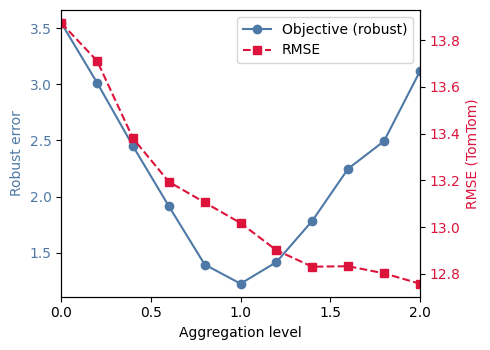

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data get from the roustness
objective = np.array([3.5458327598671997, 3.013594580727113, 2.4490667832027477, 1.9139961495756166, 1.3943805347533742, 1.223804841079181, 1.4162484306487748, 1.7838172941938468, 2.2478477018964, 2.4934842251341185, 3.1146595234465777]
)
rmse = np.array([13.87407804, 13.71164734, 13.37989258, 13.19372647, 13.10512026, 13.0169834,
 12.9005056,  12.82985065, 12.83195733, 12.80168868, 12.75712298])

colors = ['crimson', '#4e79a7']


# Make x match the data length (0.0 to 2.0 inclusive by 0.2 ⇒ 11 points)
x = np.linspace(0.0, 2.0, len(objective))

fig, ax1 = plt.subplots(figsize=(5, 3.6))

# Left axis: objective (robust)
color1 = colors[1]
line1, = ax1.plot(x, objective, color=color1, marker='o', label='Objective (robust)')
ax1.set_xlabel("Aggregation level")
ax1.set_ylabel("Robust error", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0.0, 2.0)

# Right axis: RMSE
ax2 = ax1.twinx()
color2 = colors[0]
line2, = ax2.plot(x, rmse, color=color2, marker='s', linestyle='--', label='RMSE')
ax2.set_ylabel('RMSE (TomTom)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# X ticks every 0.5 (matches the comment)
ax1.set_xticks(np.arange(0.0, 2.0 + 1e-9, 0.5))

# Combine legends from both axes
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

fig.tight_layout()

reg = 'sgp'
model = 'xgboost'
fname = f'case_line_{reg}_{model}.png'
plt.savefig(path_od_figure + fname, dpi=200, bbox_inches='tight')

plt.show()


#================================

## Validation OD point

sum true  1833186.3398747875
sum result  1707479.8622122293


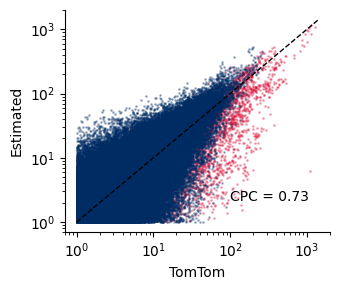

Validation Results:
- Method: xgboost
- ReMAE: 5.5612e-01 
- CPC: 7.2550e-01 
- RMSE: 1.1555e+01
- Length: 189484


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy.stats import gaussian_kde
import matplotlib.ticker as mticker

def plot_scatter_log10(smartcard_df, true_df, attributes, method_name, region, att_s, max_val, k):
    """
    Scatter plot of predicted vs. true OD probabilities with log10 axes (10^x).
    Includes CPC metric and 1:1 reference line. Intra- and inter-zone shown with
    different legends in the same figure (no legend box, no right/top spines).
    """
    # Step 1: Prepare data
    smartcard_df_ = smartcard_df[attributes + ['COUNT']].copy()
    true_df_ = true_df[attributes + ['COUNT']].copy()

    smartcard_df_['COUNT'] = smartcard_df_.groupby(attributes)['COUNT'].transform('sum')
    true_df_['COUNT'] = true_df_.groupby(attributes)['COUNT'].transform('sum')

    smartcard_df_.drop_duplicates(inplace=True)
    true_df_.drop_duplicates(inplace=True)

    # Step 2: Merge
    merged_df = pd.merge(smartcard_df_, true_df_, on=attributes, suffixes=('_pred', '_true'))
    merged_df['PROB_pred'] = merged_df['COUNT_pred']
    merged_df['PROB_true'] = merged_df['COUNT_true']

    #merged_df = merged_df[merged_df['PROB_pred'] >=5]
    #merged_df = merged_df[merged_df['PROB_true'] >=5]

    # Identify O and D keys for intra/inter split
    if 'O' in attributes and 'D' in attributes:
        O_key, D_key = 'O', 'D'
    else:
        O_candidates = [c for c in attributes if c.upper().startswith('O')]
        D_candidates = [c for c in attributes if c.upper().startswith('D')]
        if not O_candidates or not D_candidates:
            raise ValueError("Attributes must include origin/destination columns (e.g., 'O' and 'D').")
        O_key, D_key = O_candidates[0], D_candidates[0]

    merged_df['__is_intra__'] = (merged_df[O_key] == merged_df[D_key])

    # Step 3: Metrics (overall)
    rmae = np.sum(np.abs(merged_df['PROB_pred'] - merged_df['PROB_true']))/ np.sum(merged_df['PROB_true'])
    rmse = math.sqrt(np.mean((merged_df['PROB_pred'] - merged_df['PROB_true'])**2))
    cpc = 2 * np.sum(np.minimum(merged_df['PROB_pred'], merged_df['PROB_true'])) / \
          (np.sum(merged_df['PROB_pred']) + np.sum(merged_df['PROB_true']))

    # Step 4: Plot
    plt.figure(figsize=(fig_x, fig_y))

    # Intra
    m_intra = merged_df['__is_intra__']
    plt.scatter(
        merged_df.loc[m_intra, 'PROB_true'],
        merged_df.loc[m_intra, 'PROB_pred'],
        s=1, alpha=0.3, label='Intra-zone OD', color=colors[0]
    )

    # Inter
    m_inter = ~m_intra
    plt.scatter(
        merged_df.loc[m_inter, 'PROB_true'],
        merged_df.loc[m_inter, 'PROB_pred'],
        s=1, alpha=0.3, label='Inter-zone OD', color=colors[1]
    )

    # Reference line
    if max_val is None:
        max_val_ = max(merged_df['PROB_true'].max(), merged_df['PROB_pred'].max())
        plt.plot([1, max_val_*1.1], [1, max_val_*1.1],
                 color="black", linestyle="--", linewidth=1)
    else:
        plt.plot([1, max_val*1.1], [1, max_val*1.1],
                 color="black", linestyle="--", linewidth=1)

    # Log scaling
    plt.xscale("log")
    plt.yscale("log")

    # Format ticks as 10^x
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mticker.LogFormatterMathtext())
    ax.yaxis.set_major_formatter(mticker.LogFormatterMathtext())

    # Hide right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xlabel("TomTom")
    plt.ylabel("Estimated")

    # Legend without box
    #plt.legend(frameon=False)
    plt.tight_layout()

    plt.gca().text(
        10**2., 10**0.5, f'CPC = {cpc:.2f}',
        verticalalignment='top'
    )
    fname = f'case_validation_{region}_od_time.png'


    plt.savefig(path_od_figure + fname, dpi=200, bbox_inches='tight')
    plt.show()

    # Print metrics
    print(f"Validation Results:\n- Method: {method_name}\n- ReMAE: {rmae:.4e} \n- CPC: {cpc:.4e} \n- RMSE: {rmse:.4e}\n- Length: {len(merged_df)}")

    return cpc



################################################

colors = ['crimson', '#002C64']

wws = ['mon_wed', 'thu_fri', 'sat_sun']
model = 'xgboost'
reg = 'sgp'
week_day = wws[2]
fig_x = 3.5
fig_y = 3
k = '1.0'

att = ['ORIGIN_SUBZONE','DESTINATION_SUBZONE',
       'TRIP_STARTTIME'
       ]

true_df = pd.read_csv(path_od_result + f'case_{reg}_matrix_tomtom_{week_day}.csv')
result_df = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')
result_df['COUNT'] = result_df['VH_COUNT']

true_df = true_df[att + ['COUNT']]
true_df['COUNT'] = true_df.groupby(att)['COUNT'].transform('sum')
true_df.drop_duplicates(inplace=True)
print('sum true ', true_df['COUNT'].sum())

result_df = result_df[att + ['COUNT']]
result_df['COUNT'] = result_df.groupby(att)['COUNT'].transform('sum')
result_df.drop_duplicates(inplace=True)

cap_val = 1
true_df = true_df[true_df['COUNT'] >=cap_val]
result_df = result_df[result_df['COUNT'] >=cap_val]

max_val_od = max(result_df['COUNT'].max(), true_df['COUNT'].max())
print('sum result ', result_df['COUNT'].sum())

cpc = plot_scatter_log10(result_df, true_df, attributes=att, method_name=model, region=reg, att_s='OD', max_val=max_val_od, k=k)



## Validation time

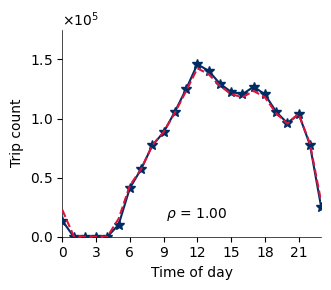

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter, MaxNLocator
from scipy.stats import spearmanr

def plot_departure(df_gen, df_true, maxz):
    plt.figure(figsize=(fig_x, fig_y))

    # Plot generated and ground truth
    plt.plot(df_gen['TRIP_STARTTIME'], df_gen['COUNT'], color=colors[1],
             marker='*', markersize=7, zorder=3, label='Estimated')

    plt.plot(df_true['TRIP_STARTTIME'], df_true['COUNT'],
             color=colors[0], linestyle='--', linewidth=1.5,
             label='TomTom', zorder=3)

    # Axis setup
    ax = plt.gca()
    ax.set_ylim(0, maxz * 1.2)
    ax.set_xlim(0, 23)

    # Scientific notation in LaTeX style (1e6 -> 1×10^6)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(formatter)

    # Clean style
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major')

    # Force integer ticks on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.xlabel("Time of day")
    plt.ylabel("Trip count")

    # Thin spines
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    # Legend top-left
    #plt.legend(loc="upper left", frameon=False)

    # === Spearman correlation ===
    rho, pval = spearmanr(df_gen['COUNT'], df_true['COUNT'])
    ax.text(
        0.4, 0.15,
        rf"$\rho$ = {rho:.2f}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top'
    )

    plt.tight_layout()
    fname = f'case_validation_{reg}_time.png'
    plt.savefig(path_od_figure + fname, dpi=200, bbox_inches='tight')
    plt.show()


#################################

colors = ['crimson', '#002C64']
fig_x = 3.5
fig_y = 3
reg = 'sgp'
wws = ['mon_wed', 'thu_fri', 'sat_sun']
week_day = wws[2]
model = 'xgboost'

true_df = pd.read_csv(path_od_result + f'case_{reg}_matrix_tomtom_{week_day}.csv')
result_df = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')
result_df['COUNT'] = result_df['VH_COUNT']

true_df = true_df[['TRIP_STARTTIME', 'COUNT']]
true_df['COUNT'] = true_df.groupby(['TRIP_STARTTIME'])['COUNT'].transform('sum')
true_df.drop_duplicates(inplace = True)
true_df.sort_values('TRIP_STARTTIME', inplace=True)

result_df = result_df[['TRIP_STARTTIME', 'COUNT']]
result_df['COUNT'] = result_df.groupby(['TRIP_STARTTIME'])['COUNT'].transform('sum')
result_df.drop_duplicates(inplace = True)
result_df.sort_values('TRIP_STARTTIME', inplace=True)

plot_departure(result_df, true_df, max(result_df['COUNT'].max(), true_df['COUNT'].max()))


## Validation OD map

sum result: 2455041.8957603197
sum true: 2261844.4915379076
Generated, Intra-zone  189067.40887898003


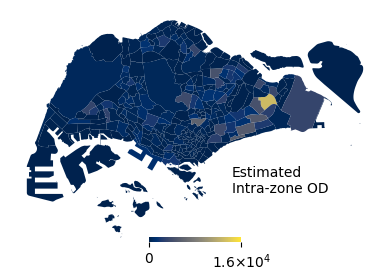

Cellular, Intra-zone 340927.76994328556


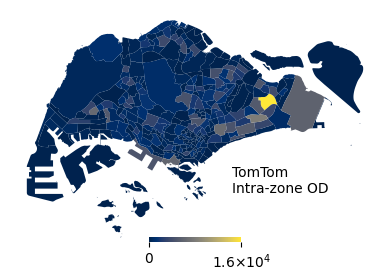

Generated, Inter-zone  2265974.4868813395


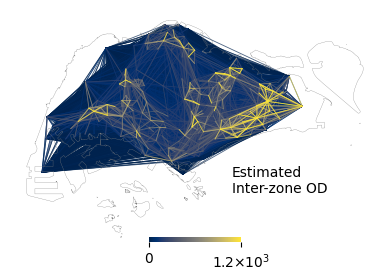

Cellular, Inter-zone  1920916.721594622


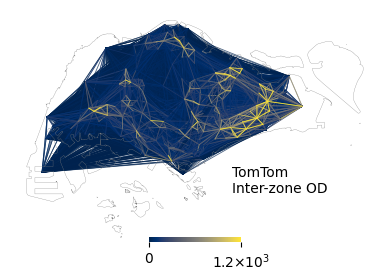

Intra-zone CPC: 0.6914
Inter-zone CPC:   0.7548


In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def _build_od_order_from_df1(df1_inter):
    order_df = (
        df1_inter[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']]
        .sort_values('COUNT', ascending=True)
        .drop_duplicates(subset=['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'], keep='first')
        .reset_index(drop=True)
    )
    order_df['ORDER_IDX'] = np.arange(len(order_df), dtype=int)
    return order_df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'ORDER_IDX']]

def _sci_notation(val, prec=1):
    """Format number: plain if <100, else a×10^n."""
    if abs(val) < 100:   # show plain integer/float
        return str(int(round(val))) if val.is_integer() else f"{val:.{prec}f}"
    else:
        s = f"{val:.{prec}e}"  # e.g., 1.23e+05
        base, exp = s.split("e")
        exp = int(exp)
        return rf"{base}×10$^{exp}$"


def plot_OD_subzone_inter(
    dfz,
    cc,
    max_prob=None,
    time=None,
    od_order=None
):
    """
    Inter-zone flows with a continuous colormap.
    If `od_order` (with ORDER_IDX) is provided, the plot strictly follows that order.
    Colorbar style matches the intra-zone plot: inside map, ticks at 0 and max (scientific).
    """
    df = dfz.copy()

    # Respect provided OD order (or fallback to ascending by COUNT)
    if od_order is not None:
        df_plot = (
            df.merge(od_order, on=['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'], how='inner')
              .sort_values('ORDER_IDX')
        )
    else:
        df_plot = df.sort_values('COUNT', ascending=True)

    # Colormap & normalization (match intra)
    if max_prob is None:
        max_prob = df_plot['COUNT'].max()
    norm = Normalize(vmin=0, vmax=max_prob)
    cmap = cm.get_cmap(color_map)

    # Boundaries (for extent/overlay)
    gdf = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
    boundary = gdf.dissolve()

    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    ax.set_axis_off()

    # Draw inter-zone curves
    for _, row in df_plot.iterrows():
        x0, y0 = row['ORIGIN_SUBZONE_X'],      row['ORIGIN_SUBZONE_Y']
        x1, y1 = row['DESTINATION_SUBZONE_X'], row['DESTINATION_SUBZONE_Y']
        ctrl_x, ctrl_y = (x0 + x1) / 2.0, (y0 + y1) / 2.0
        t = np.linspace(0, 1, 50)
        xs = (1 - t)**3 * x0 + 3*(1 - t)**2*t*ctrl_x + 3*(1 - t)*t**2*ctrl_x + t**3 * x1
        ys = (1 - t)**3 * y0 + 3*(1 - t)**2*t*ctrl_y + 3*(1 - t)*t**2*ctrl_y + t**3 * y1
        ax.plot(xs, ys, color=cmap(norm(row['COUNT'])), linewidth=0.6, alpha=0.7)

    #boundary.plot(ax=ax, color='none', edgecolor='none', linewidth=0.0)
    boundary.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.2, zorder=3)

    plt.gca().text(
        0.6, 0.35, f'{cc}\nInter-zone OD',
        transform=plt.gca().transAxes,
        verticalalignment='top'
    )

    # --- Colorbar INSIDE the map, 2 ticks (0 & max), scientific mantissa format ---
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = inset_axes(ax, width="25%", height="2%", loc='lower center', borderpad=0.5)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_ticks([0, max_prob])
    cbar.set_ticklabels(["0", _sci_notation(max_prob, prec=1)])
    # Remove colorbar border
    for spine in cbar.ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.savefig(path_od_figure + f'case_validation_inter_od_{reg}_{cc}.png', dpi=300, bbox_inches='tight')
    plt.show()



# ---- 1) Canonical order from df1 (ascending by COUNT) ----
def _build_od_order_from_df1z(df1_inter):
    order_df = (
        df1_inter[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']]
        .sort_values('COUNT', ascending=True)
        .drop_duplicates(subset=['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'], keep='first')
        .reset_index(drop=True)
    )
    order_df['ORDER_IDX'] = np.arange(len(order_df), dtype=int)
    return order_df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'ORDER_IDX']]


# ---- 3) Driver: prepare coords, build order from df1, plot both in that order ----
def show_demand_OD_inter(df1, df2):
    data_subzone = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
    data_subzone['X'] = data_subzone.geometry.centroid.x
    data_subzone['Y'] = data_subzone.geometry.centroid.y
    data_subzone = data_subzone[['SUBZONE_C', 'X', 'Y']]

    def _prepare(df):
        df_ = df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']].copy()
        df_ = df_.merge(data_subzone, right_on='SUBZONE_C', left_on='ORIGIN_SUBZONE') \
                 .drop(columns=['SUBZONE_C']) \
                 .rename(columns={'X': 'ORIGIN_SUBZONE_X', 'Y': 'ORIGIN_SUBZONE_Y'})
        df_ = df_.merge(data_subzone, right_on='SUBZONE_C', left_on='DESTINATION_SUBZONE') \
                 .drop(columns=['SUBZONE_C']) \
                 .rename(columns={'X': 'DESTINATION_SUBZONE_X', 'Y': 'DESTINATION_SUBZONE_Y'})
        # Sum duplicates and dedupe
        df_['COUNT'] = df_.groupby(
            ['ORIGIN_SUBZONE', 'ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y',
             'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y']
        )['COUNT'].transform('sum')
        df_.drop_duplicates(inplace=True)
        return df_

    df1_ = _prepare(df1)
    df2_ = _prepare(df2)

    # Inter-zone only
    df1__ = df1_[df1_['ORIGIN_SUBZONE'] != df1_['DESTINATION_SUBZONE']].copy()
    df2__ = df2_[df2_['ORIGIN_SUBZONE'] != df2_['DESTINATION_SUBZONE']].copy()

    # --- Canonical order from df1 (ascending by COUNT) ---
    od_order = _build_od_order_from_df1(df1__)

    # Shared color normalization across both plots
    mazzz = max(df1__['COUNT'].quantile(0.999), df2__['COUNT'].quantile(0.999))

    print('Generated, Inter-zone ', df1__['COUNT'].sum())
    plot_OD_subzone_inter(df1__, 'Estimated', mazzz, od_order=od_order)
    print('Cellular, Inter-zone ', df2__['COUNT'].sum())
    plot_OD_subzone_inter(df2__, 'TomTom', mazzz, od_order=od_order)


########################################################

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def sci_notation(val, prec=1):
    """Format number as a.b × 10^n"""
    s = f"{val:.{prec}e}"  # e.g. 1.23e+05
    base, exp = s.split("e")
    exp = int(exp)  # convert to int
    return rf"{base}×10$^{exp}$"

def plot_OD_subzone_intra(
    dfz,
    cc,
    max_prob=None,
    time=None
):
    """
    Intra-zone, continuous colormap, missing zones get COUNT=0.
    Colorbar inside plot with only 0 and max value (scientific with mantissa).
    """
    # 1) load all subzones
    gdf = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')

    # 2) compute intra-zone counts
    intra    = dfz[dfz.ORIGIN_SUBZONE == dfz.DESTINATION_SUBZONE]
    zone_sum = intra.groupby('DESTINATION_SUBZONE')['COUNT'].sum()

    # 3) map counts onto full GeoDataFrame, fill missing with zero
    gdf['COUNT'] = gdf['SUBZONE_C'].map(zone_sum).fillna(0)

    # 4) determine normalization
    if max_prob is None:
        max_prob = gdf['COUNT'].max()
    norm = Normalize(vmin=0, vmax=max_prob)
    cmap = cm.get_cmap(color_map2)

    # 5) plot map
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    ax.set_axis_off()
    gdf.plot(
        column='COUNT',
        cmap=cmap,
        norm=norm,
        ax=ax,
        edgecolor='none',
        linewidth=0,
        alpha=1.0,
        antialiased=True
    )

    # overlay boundaries
    gdf.boundary.plot(ax=ax, color='none', linewidth=0.0)

    plt.gca().text(
        0.6, 0.35, f'{cc}\nIntra-zone OD',
        transform=plt.gca().transAxes,
        verticalalignment='top'
    )

    # --- Colorbar inside plot ---
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = inset_axes(ax, width="25%", height="2%", loc='lower center', borderpad=0.5)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    # show only two ticks: 0 and max
    cbar.set_ticks([0, max_prob])
    cbar.set_ticklabels(["0", sci_notation(max_prob, prec=1)])
    # remove border line around colorbar
    for spine in cbar.ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.savefig(path_od_figure + f'case_validation_intra_od_{reg}_{cc}.png', dpi=300, bbox_inches='tight')
    plt.show()



def show_demand_OD_intra(df1, df2):
    data_subzone = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
    data_subzone['X'] = data_subzone.geometry.centroid.x
    data_subzone['Y'] = data_subzone.geometry.centroid.y
    data_subzone = data_subzone[['SUBZONE_C', 'X', 'Y']]

    df1_ = df1[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']].copy()

    df1_ = df1_.merge(data_subzone, right_on='SUBZONE_C', left_on='ORIGIN_SUBZONE')
    df1_.drop(columns=['SUBZONE_C'], inplace=True)
    df1_.rename(columns={'X':'ORIGIN_SUBZONE_X', 'Y':'ORIGIN_SUBZONE_Y'}, inplace=True)
    df1_ = df1_.merge(data_subzone, right_on='SUBZONE_C', left_on='DESTINATION_SUBZONE')
    df1_.drop(columns=['SUBZONE_C'], inplace=True)
    df1_.rename(columns={'X':'DESTINATION_SUBZONE_X', 'Y':'DESTINATION_SUBZONE_Y'}, inplace=True)

    df1_ = df1_[['ORIGIN_SUBZONE', 'ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y','COUNT']]
    df1_['COUNT'] = df1_.groupby(['ORIGIN_SUBZONE','ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y'])['COUNT'].transform('sum')
    df1_.drop_duplicates(inplace = True)
    df1_.sort_values(by=['COUNT'], ascending=False, inplace=True)

    ###############################

    df2_ = df2[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']].copy()

    df2_ = df2_.merge(data_subzone, right_on='SUBZONE_C', left_on='ORIGIN_SUBZONE')
    df2_.drop(columns=['SUBZONE_C'], inplace=True)
    df2_.rename(columns={'X':'ORIGIN_SUBZONE_X', 'Y':'ORIGIN_SUBZONE_Y'}, inplace=True)
    df2_ = df2_.merge(data_subzone, right_on='SUBZONE_C', left_on='DESTINATION_SUBZONE')
    df2_.drop(columns=['SUBZONE_C'], inplace=True)
    df2_.rename(columns={'X':'DESTINATION_SUBZONE_X', 'Y':'DESTINATION_SUBZONE_Y'}, inplace=True)

    df2_ = df2_[['ORIGIN_SUBZONE', 'ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y','COUNT']]
    df2_['COUNT'] = df2_.groupby(['ORIGIN_SUBZONE','ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y'])['COUNT'].transform('sum')
    df2_.drop_duplicates(inplace = True)
    df2_.sort_values(by=['COUNT'], ascending=False, inplace=True)

    df1__ = df1_[df1_['ORIGIN_SUBZONE'] == df1_['DESTINATION_SUBZONE']]
    df2__ = df2_[df2_['ORIGIN_SUBZONE'] == df2_['DESTINATION_SUBZONE']]
    mazzz = max(df1__['COUNT'].quantile(0.999), df2__['COUNT'].quantile(0.999))
    print('Generated, Intra-zone ', df1__['COUNT'].sum())
    plot_OD_subzone_intra(df1__, 'Estimated', mazzz)
    print('Cellular, Intra-zone', df2__['COUNT'].sum())
    plot_OD_subzone_intra(df2__, 'TomTom', mazzz)


def compute_cpc(true_df, result_df, intra=True):
    """
    Compute CPC index for either intra- or inter-zone flows.

    Parameters
    ----------
    true_df : pd.DataFrame
        Ground truth OD matrix with ['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']
    result_df : pd.DataFrame
        Generated OD matrix with same columns.
    intra : bool
        If True, compute CPC for intra-zone flows (i == j);
        If False, for inter-zone flows (i ≠ j).

    Returns
    -------
    cpc : float
        CPC value between 0 and 1.
    """

    # Filter intra or inter flows
    if intra:
        mask_true = true_df['ORIGIN_SUBZONE'] == true_df['DESTINATION_SUBZONE']
        mask_pred = result_df['ORIGIN_SUBZONE'] == result_df['DESTINATION_SUBZONE']
    else:
        mask_true = true_df['ORIGIN_SUBZONE'] != true_df['DESTINATION_SUBZONE']
        mask_pred = result_df['ORIGIN_SUBZONE'] != result_df['DESTINATION_SUBZONE']

    df_true = true_df[mask_true].copy()
    df_pred = result_df[mask_pred].copy()

    # Merge on OD pair
    merged = pd.merge(
        df_true, df_pred,
        on=['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'],
        suffixes=('_true', '_pred'),
        how='outer'
    ).fillna(0)

    numerator   = 2 * (merged[['COUNT_true', 'COUNT_pred']].min(axis=1)).sum()
    denominator = merged['COUNT_true'].sum() + merged['COUNT_pred'].sum()

    return numerator / denominator if denominator > 0 else 0.0


#########################################################
color_map = 'cividis'
color_map2 = 'cividis'

colors = ['red', 'darkcyan']
reg = 'sgp'
wws = ['mon_wed', 'thu_fri', 'sat_sun']
week_day = wws[0]

fig_x = 4
fig_y = 4

true_df = pd.read_csv(path_od_result + f'case_{reg}_matrix_tomtom_{week_day}.csv')
result_df = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')
result_df['COUNT'] = result_df['VH_COUNT']

true_df['COUNT'] = true_df['COUNT'].clip(lower=1)
result_df['COUNT'] = result_df['COUNT'].clip(lower=1)

true_df = true_df[['ORIGIN_SUBZONE','DESTINATION_SUBZONE', 'COUNT']]
result_df = result_df[['ORIGIN_SUBZONE','DESTINATION_SUBZONE', 'COUNT']]
true_df['COUNT'] = true_df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'])['COUNT'].transform('sum')
result_df['COUNT'] = result_df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'])['COUNT'].transform('sum')
true_df.drop_duplicates(inplace=True)
result_df.drop_duplicates(inplace=True)

print(f'sum result: {result_df["COUNT"].sum()}')
print(f'sum true: {true_df["COUNT"].sum()}')

show_demand_OD_intra(result_df, true_df)
show_demand_OD_inter(result_df, true_df)

cpc_intra = compute_cpc(true_df, result_df, intra=True)
cpc_inter = compute_cpc(true_df, result_df, intra=False)
print(f"Intra-zone CPC: {cpc_intra:.4f}")
print(f"Inter-zone CPC:   {cpc_inter:.4f}")



## Multiday

total  7461135.953894823


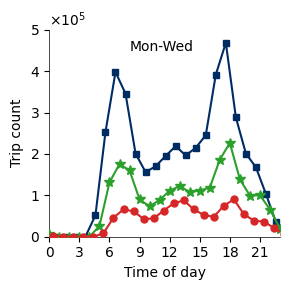

total  7671509.759655961


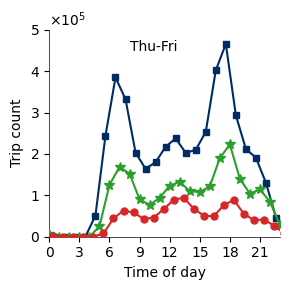

total  6382851.629585799


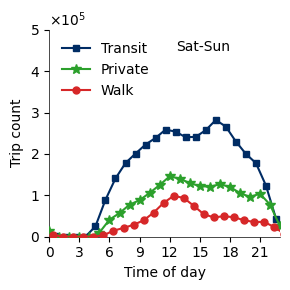

{'mon_wed': np.float64(7461135.953894822), 'thu_fri': np.float64(7671509.759655961), 'sat_sun': np.float64(6382851.629585795)}


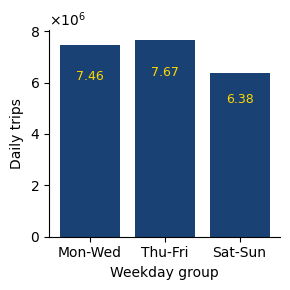

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter, MaxNLocator


def plot_departure(df_gen, df_true, week_day, maxz):
    plt.figure(figsize=(fig_x, fig_y))

    # --- Multiple bars setup (unchanged layout) ---
    x = df_gen['TRIP_STARTTIME'].values
    width = 0.4
    offsets = [-width, 0, width]

    # Suggested colors (ColorBrewer/Tableau safe)
    col_pt = "#4e79a7"   # PT: muted blue
    col_wk = "#59a14f"   # WK: softer green
    col_vh = "#f28e2b"   # VH: amber/orange
    line_tt = "#e15759"  # TomTom: coral red

    col_pt = "#002C64"   # PT: muted blue
    col_wk = "#2ca02c"   # WK: softer green
    col_vh = "#d62728"   # VH: amber/orange

    # Bars (just color/alpha tweaks; keep edgecolor='none' as you set)
    '''plt.bar(x + offsets[0], df_gen['PT_COUNT'], width=width,
            color=col_pt, alpha=1, edgecolor='none', label='Transit', zorder=2)
    plt.bar(x + offsets[1], df_gen['WK_COUNT'], width=width,
            color=col_wk, alpha=1, edgecolor='none', label='Walk', zorder=2)
    plt.bar(x + offsets[2], df_gen['VH_COUNT'], width=width,
            color=col_vh, alpha=1, edgecolor='none', label='Private', zorder=2)'''


    plt.plot(x + offsets[0], df_gen['PT_COUNT'],
             color=col_pt, linewidth=1.5, marker='s',  label='Transit', markersize=5, zorder=3)
    plt.plot(x + offsets[1], df_gen['VH_COUNT'],
             color=col_wk, linewidth=1.5, marker='*', label='Private',  markersize=7, zorder=3)
    plt.plot(x + offsets[2], df_gen['WK_COUNT'],
             color=col_vh, linewidth=1.5, marker='o', label='Walk', markersize=5, zorder=3)

    # Line (preserve linestyle; slightly bolder for print clarity)
    #plt.plot(df_true['TRIP_STARTTIME'], df_true['COUNT'],
    #         color=line_tt, linestyle='--', linewidth=1.5, label='TomTom', zorder=3)


    # Axis setup (unchanged)
    ax = plt.gca()
    ax.set_ylim(0, maxz)
    ax.set_xlim(0, 23)

    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(formatter)

    # Clean style (unchanged)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major')

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.xlabel("Time of day")
    plt.ylabel("Trip count")

    wd = {'mon_wed': 'Mon-Wed', 'thu_fri': 'Thu-Fri', 'sat_sun': 'Sat-Sun'}
    total_trip = df_gen['PT_COUNT'].sum() + df_gen['VH_COUNT'].sum() + df_gen['WK_COUNT'].sum()
    # format into a × 10^y form
    sci_str = f"{total_trip:.1e}"   # e.g. "6.5e+05"
    base, exp = sci_str.split("e")
    exp = int(exp)                  # remove + sign and convert to int
    formatted_total = rf"{base}×10$^{exp}$"


    xx = 0.35
    yy = 0.95
    if week_day == 'sat_sun':
        xx = 0.55
        yy = 0.95

    plt.gca().text(
        xx, yy, f'{wd[week_day]}',  #\nDaily trips: {formatted_total}
        transform=plt.gca().transAxes,
        verticalalignment='top'
    )

    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    # Legend line remains commented out per your code

    if (week_day == 'sat_sun') & (reg == 'sgp'):
        plt.legend(loc="upper left", frameon=False)

    plt.tight_layout()
    fname = f'case_validation_{reg}_time_{week_day}.png'
    plt.savefig(path_od_figure + fname, dpi=400, bbox_inches='tight')
    plt.show()

###################################################

week_days = ['mon_wed', 'thu_fri', 'sat_sun']
reg = 'sgp'
colors = ['tab:red','darkcyan']
fig_x = 3#2.8
fig_y = 3#2.5

trip_count = {}

for week_day in week_days:
    true_df = pd.read_csv(path_od_result + f'case_{reg}_matrix_tomtom_{week_day}.csv')
    result_df = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')
    print('total ', result_df['COUNT'].sum())

    true_df = true_df[['TRIP_STARTTIME', 'COUNT']]
    true_df['COUNT'] = true_df.groupby(['TRIP_STARTTIME'])['COUNT'].transform('sum')
    true_df.drop_duplicates(inplace = True)
    true_df.sort_values('TRIP_STARTTIME', inplace=True)

    result_df = result_df[['TRIP_STARTTIME', 'VH_COUNT', 'WK_COUNT', 'PT_COUNT', 'COUNT']]
    result_df['COUNT'] = result_df['VH_COUNT'] + result_df['WK_COUNT'] + result_df['PT_COUNT']
    result_df['VH_COUNT'] = result_df.groupby(['TRIP_STARTTIME'])['VH_COUNT'].transform('sum')
    result_df['WK_COUNT'] = result_df.groupby(['TRIP_STARTTIME'])['WK_COUNT'].transform('sum')
    result_df['PT_COUNT'] = result_df.groupby(['TRIP_STARTTIME'])['PT_COUNT'].transform('sum')
    result_df['COUNT'] = result_df.groupby(['TRIP_STARTTIME'])['COUNT'].transform('sum')
    result_df.drop_duplicates(inplace = True)
    result_df.sort_values('TRIP_STARTTIME', inplace=True)

    maxx =  5e5
    plot_departure(result_df, true_df, week_day, maxx)

    trip_count.update({week_day: result_df['COUNT'].sum()})


#####################################
print(trip_count)

data = trip_count

# Extract keys & values
labels = list(data.keys())
values = list(data.values())

# Custom labels for x-axis
label_map = {
    'mon_wed': 'Mon-Wed',
    'thu_fri': 'Thu-Fri',
    'sat_sun': 'Sat-Sun'
}

labels = [label_map[k] for k in data.keys()]
values = list(data.values())

# Plot
fig, ax = plt.subplots(figsize=(3, 3))
#bars = ax.bar(labels, values, color=["#4e79a7", "#4e79a7", "#4e79a7"], alpha=0.9)
bars = ax.bar(labels, values, color=["#002C64", "#002C64", "#002C64"], alpha=0.9)


# Format y-axis ticks as 10^x (scientific)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))   # always use scientific notation
ax.yaxis.set_major_formatter(formatter)

# Add value labels in scientific format
for bar, val in zip(bars, values):
    sci_str = f"{val:.2e}"   # e.g. "2.7e+07"
    base, exp = sci_str.split("e")
    exp = int(exp)
    #formatted_val = rf"{base}×10$^{exp}$"
    formatted_val = rf"{base}"
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height()*0.8,
        formatted_val,
        ha="center",
        va="bottom",
        color="#FFD700",   # yellow text for contrast
        fontsize=9
    )



# Labels and style
ax.set_ylabel("Daily trips")
ax.set_xlabel("Weekday group")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
fname = f'case_validation_{reg}_week_day_demand.png'
plt.savefig(path_od_figure + fname, dpi=400, bbox_inches='tight')
plt.show()


## Transit competitiveness

total  7461135.953894823


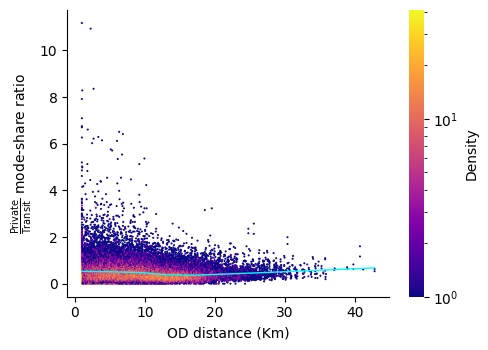

x_min: 16.179556514344835
y_min: 0.3629966749394573


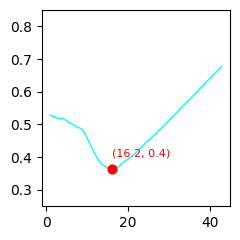

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
import pandas as pd
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

def add_lowess_line(ax, x, y, *, label="LOWESS", frac=0.20, it=1,
                    color="crimson", lw=2.0, ls="--", zorder=6):
    """
    Plot only the LOWESS smooth of y ~ x on `ax`.

    Parameters
    ----------
    ax : matplotlib axes
    x, y : array-like
    label : legend label for the line
    frac : smoothing span (0..1); larger = smoother
    it : robustness iterations (≥1)
    color, lw, ls, zorder : line styling

    Returns
    -------
    dict with keys 'x', 'y' (LOWESS curve coordinates)
    """
    m = np.isfinite(x) & np.isfinite(y)
    lo = lowess(endog=np.asarray(y)[m],
                exog=np.asarray(x)[m],
                frac=frac, it=it, return_sorted=True)
    ax.plot(lo[:, 0], lo[:, 1], color=color, lw=lw, ls=ls, label=label, zorder=zorder)
    return {"x": lo[:, 0], "y": lo[:, 1]}


def compute_distance(df, att):
    """
    Computes the haversine distance between origin and destination coordinates in kilometers.
    att: List with [origin_lon, dest_lon, origin_lat, dest_lat]
    """
    lon1 = np.radians(df[att[0]])
    lon2 = np.radians(df[att[1]])
    lat1 = np.radians(df[att[2]])
    lat2 = np.radians(df[att[3]])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # Radius of Earth in km

#######################
reg = 'sgp'
color_m = 'plasma'
week_day = 'mon_wed'

fig_x = 4
fig_y = 4

df = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')
print('total ', df['COUNT'].sum())

df = df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'PT_COUNT', 'VH_COUNT']]
df['PT_COUNT'] = df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'])['PT_COUNT'].transform('sum')
df['VH_COUNT'] = df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'])['VH_COUNT'].transform('sum')
df.drop_duplicates(inplace = True)

df['COUNT'] = df['PT_COUNT'] + df['VH_COUNT']
df['RATIO'] = (df['VH_COUNT']) / df['PT_COUNT']
df = df[df['PT_COUNT'] >= 5]

#######################################

gdf = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
gdf['X'] = gdf.geometry.centroid.x
gdf['Y'] = gdf.geometry.centroid.y

# Merge origin coordinates
df = df.merge(
    gdf[['SUBZONE_C', 'X', 'Y']].rename(columns={'SUBZONE_C': 'ORIGIN_SUBZONE',
                                                'X': 'Origin_X',
                                                'Y': 'Origin_Y'}),
    on='ORIGIN_SUBZONE',
    how='left'
)

# Merge destination coordinates
df = df.merge(
    gdf[['SUBZONE_C', 'X', 'Y']].rename(columns={'SUBZONE_C': 'DESTINATION_SUBZONE',
                                                'X': 'Destination_X',
                                                'Y': 'Destination_Y'}),
    on='DESTINATION_SUBZONE',
    how='left'
)

df['DISTANCE'] = compute_distance(df, ['Origin_X', 'Destination_X', 'Origin_Y', 'Destination_Y']) #np.ceil(
df['DISTANCE'] = df['DISTANCE'].clip(lower=1)


######################################
fig, ax = plt.subplots(figsize=(5, 3.6))
hb = plt.hexbin(
    df['DISTANCE'], df['RATIO'],
    gridsize=400,
    bins='log',
    cmap=color_m,
    mincnt=1
)

cbar = plt.colorbar(hb, label="Density")
cbar.outline.set_visible(False)   # <<< remove colorbar border

plt.xlabel("OD distance (Km)")
plt.ylabel(r"$\frac{\text{Private}}{\text{Transit}}$ mode-share ratio")

# Clean style
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major')

# LOWESS line
res = add_lowess_line(
    ax,
    df['DISTANCE'], df['RATIO'],
    label=None,
    frac=0.20, it=1, color="cyan", lw=1, ls="-"
)

plt.tight_layout()
plt.savefig(path_od_figure + f'case_ratio_distance_{reg}.png', dpi=300, bbox_inches="tight")
plt.show()

###########

# ---- Zoomed figure around the LOWESS line (central 5–95% range) ----
lx, ly = res["x"], res["y"]

# Find index of minimum y
idx_min = np.argmin(ly)

# Get the corresponding values
y_min = ly[idx_min]
x_min = lx[idx_min]

print("x_min:", x_min)
print("y_min:", y_min)

# Choose a central window (robust to outliers); tweak if needed
x_lo, x_hi = np.quantile(lx, [0, 1])
y_lo, y_hi = 0.3, 0.8

# Add a little padding so the line isn't on the frame
pad_x = 0.05 * (x_hi - x_lo) if x_hi > x_lo else 1.0
pad_y = 0.10 * (y_hi - y_lo) if y_hi > y_lo else 0.1

fig2, ax2 = plt.subplots(figsize=(2.5, 2.5))
ax2.plot(lx, ly, color="cyan", lw=1, ls="-")

# Mark the minimum point
ax2.scatter(x_min, y_min, color="red", s=40, zorder=5, label="Min point")

# Annotate with coordinates
ax2.annotate(f"({x_min:.1f}, {y_min:.1f})",
            xy=(x_min, y_min),
            xytext=(0, 9),
            textcoords="offset points",
            fontsize=8,
            color="red")

# Axis limits
ax2.set_xlim(x_lo - pad_x, x_hi + pad_x)
ax2.set_ylim(y_lo - pad_y, y_hi + pad_y)

plt.tight_layout()
plt.savefig(path_od_figure + f'case_ratio_distance_{reg}_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

total  7461135.953894823
loss and gain  324921.2535903058 303191.5592026304
network_peformance  0.0765536568783495
                    SUBZONE_N SUBZONE_C     PLN_AREA_N
0               PEOPLE'S PARK    OTSZ02         OUTRAM
1                 BUKIT MERAH    BMSZ02    BUKIT MERAH
2                   CHINATOWN    OTSZ03         OUTRAM
3                     PHILLIP    DTSZ04  DOWNTOWN CORE
4               RAFFLES PLACE    DTSZ05  DOWNTOWN CORE
..                        ...       ...            ...
318                   YEW TEE    CKSZ06  CHOA CHU KANG
319  PASIR RIS WAFER FAB PARK    PRSZ01      PASIR RIS
320                   MATILDA    PGSZ03        PUNGGOL
321               NORTH COAST    WDSZ09      WOODLANDS
322         SEMBAWANG STRAITS    SBSZ06      SEMBAWANG

[323 rows x 3 columns]

Top surplus zones:
  WDSZ01: 10384.38
  JWSZ09: 9973.94
  DTSZ05: 9385.46
  OTSZ03: 8967.15
  JESZ05: 8635.83

Top deficit zones:
  CHSZ03: -10427.32
  BDSZ05: -7695.22
  NVSZ01: -7042.47
  MPSZ03: -6

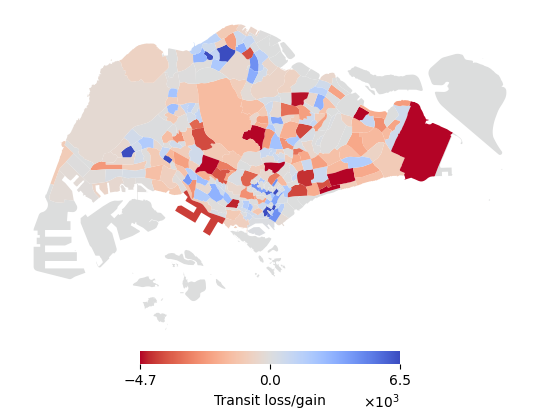

  SUBZONE_C           val                  SUBZONE_N     PLN_AREA_N
0    WDSZ01  10384.379739  WOODLANDS REGIONAL CENTRE      WOODLANDS
1    JWSZ09   9973.940474        JURONG WEST CENTRAL    JURONG WEST
2    DTSZ05   9385.456061              RAFFLES PLACE  DOWNTOWN CORE
3    OTSZ03   8967.146425                  CHINATOWN         OUTRAM
4    JESZ05   8635.826877             JURONG GATEWAY    JURONG EAST
  SUBZONE_C           val       SUBZONE_N     PLN_AREA_N
0    CHSZ03 -10427.320538  CHANGI AIRPORT         CHANGI
1    BDSZ05  -7695.217373         FRANKEL          BEDOK
2    NVSZ01  -7042.467328       BALESTIER         NOVENA
3    MPSZ03  -6204.748906   MARINE PARADE  MARINE PARADE
4    BTSZ03  -5225.039993    HOLLAND ROAD    BUKIT TIMAH


In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
import pandas as pd
import numpy as np

def compute_distance(df, att):
    """
    Computes the haversine distance between origin and destination coordinates in kilometers.
    att: List with [origin_lon, dest_lon, origin_lat, dest_lat]
    """
    lon1 = np.radians(df[att[0]])
    lon2 = np.radians(df[att[1]])
    lat1 = np.radians(df[att[2]])
    lat2 = np.radians(df[att[3]])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # Radius of Earth in km

import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

def residuals_and_lost_trips(
    df: pd.DataFrame,
    *,
    origin_col="ORIGIN_SUBZONE",
    dest_col="DESTINATION_SUBZONE",
    ratio_col="RATIO",        # R = OT/PT (must be >0)
    pt_col="PT_COUNT",
    ot_col="OT_COUNT",
    distance_col="DISTANCE",
    # --- baseline and robustness ---
    lowess_frac=0.25,         # span for \hat{E}[R | d]
    winsor=(0.0, 1),      # winsorize R when fitting baseline
    n_bins=12,                # distance bins for std normalization
    min_pt=1.0,               # drop tiny PT to avoid unstable ratios
    std_floor=1e-6            # guard for near-zero bin std
):
    """Return df_plus, kpis, top_loss, origin_summary, dest_summary."""
    df = df.copy()

    # Ensure numeric, drop bad rows and tiny transit counts
    for c in [ratio_col, pt_col, ot_col, distance_col]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=[ratio_col, pt_col, ot_col, distance_col])
    df = df[(df[pt_col] >= min_pt) & (df[ratio_col] > 0)].copy()

    # Total market (use PT+OT for internal consistency)
    df["MKT"] = df[pt_col] + df[ot_col]

    # ---- 1) Fit baseline \hat R(d) with LOWESS on a winsorized R ----
    R = df[ratio_col].astype(float)
    qlo, qhi = R.quantile(winsor[0]), R.quantile(winsor[1])
    R_fit = R.clip(qlo, qhi)

    mask = R_fit.notna() & df[distance_col].notna()
    lo = lowess(
        endog=R_fit.loc[mask].values,
        exog=df.loc[mask, distance_col].values,
        frac=lowess_frac, it=1, return_sorted=True
    )
    x_fit, y_fit = lo[:, 0], lo[:, 1]
    df["R_HAT"] = np.interp(df[distance_col].values, x_fit, y_fit)

    # ---- 2) Non-log residuals and distance-band standardization ----
    df["DELTA_R"] = df[ratio_col] - df["R_HAT"]

    # Equal-frequency distance bins for robust std estimation
    df["_d_bin"] = pd.qcut(df[distance_col], q=n_bins, duplicates="drop")
    bin_std = (
        df.groupby("_d_bin", observed=True)["DELTA_R"]
          .agg(lambda s: max(s.std(ddof=1), std_floor))
          .rename("BIN_STD")
    )
    df = df.merge(bin_std, left_on="_d_bin", right_index=True, how="left")
    df["ZDELTA_R"] = df["DELTA_R"] / df["BIN_STD"]

    # Impact-weighted residual (fairness × current transit riders)
    df["W_R"] = df[pt_col] * df["ZDELTA_R"]

    # ---- 3) Lost/Gained transit trips (market fixed) ----
    # exact: DeltaPT = PT*(R - R_HAT)/(1 + R_HAT)
    df["DELTA_PT"] = df[pt_col] * (df[ratio_col] - df["R_HAT"]) / (1.0 + df["R_HAT"])
    df["LOST_PT"]  = np.maximum(0.0,  df["DELTA_PT"])   # under-performance
    df["GAINED_PT"]= np.maximum(0.0, -df["DELTA_PT"])   # over-performance

    # ---- 4) KPIs ----
    total_market = float(df["MKT"].sum())
    total_pt     = float(df[pt_col].sum())
    kpis = {
        "winsor_quantiles_on_R": (float(qlo), float(qhi)),
        "lowess_frac": float(lowess_frac),
        "n_distance_bins": int(df["_d_bin"].nunique()),
        "total_market_trips": total_market,
        "total_transit_trips": total_pt,
        "convertible_trips_sum": float(df["LOST_PT"].sum()),
        "convertible_rate_per_market": float(df["LOST_PT"].sum() / total_market) if total_market > 0 else np.nan,
        "overperformance_trips_sum": float(df["GAINED_PT"].sum()),
    }

    # Leaderboards
    top_loss = (
        df[[origin_col, dest_col, distance_col, pt_col, ot_col, "MKT",
            ratio_col, "R_HAT", "DELTA_R", "ZDELTA_R", "W_R", "LOST_PT"]]
        .sort_values(["LOST_PT", "W_R"], ascending=[False, False])
        .head(50)
        .reset_index(drop=True)
    )

    origin_summary = (
        df.groupby(origin_col, as_index=False)
          .apply(lambda g: pd.Series({
              "MKT_SUM": g["MKT"].sum(),
              "PT_SUM":  g[pt_col].sum(),
              "LOST_PT_SUM": g["LOST_PT"].sum(),
              "GAINED_PT_SUM": g["GAINED_PT"].sum(),
              "ZDELTA_R_PT_WEIGHTED": np.average(g["ZDELTA_R"], weights=g[pt_col]) if g[pt_col].sum()>0 else np.nan,
              "HEADROOM_RATE": g["LOST_PT"].sum()/g["MKT"].sum() if g["MKT"].sum()>0 else np.nan
          }))
          .reset_index(drop=True)
          .sort_values("LOST_PT_SUM", ascending=False)
    )

    dest_summary = (
        df.groupby(dest_col, as_index=False)
          .apply(lambda g: pd.Series({
              "MKT_SUM": g["MKT"].sum(),
              "PT_SUM":  g[pt_col].sum(),
              "LOST_PT_SUM": g["LOST_PT"].sum(),
              "GAINED_PT_SUM": g["GAINED_PT"].sum(),
              "ZDELTA_R_PT_WEIGHTED": np.average(g["ZDELTA_R"], weights=g[pt_col]) if g[pt_col].sum()>0 else np.nan,
              "HEADROOM_RATE": g["LOST_PT"].sum()/g["MKT"].sum() if g["MKT"].sum()>0 else np.nan
          }))
          .reset_index(drop=True)
          .sort_values("LOST_PT_SUM", ascending=False)
    )

    # Tidy
    df.drop(columns=["_d_bin", "BIN_STD"], inplace=True, errors="ignore")

    return df, kpis, top_loss, origin_summary, dest_summary


#############################################

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter

fig_x = 5.5
fig_y = 5.5

def thousands_formatter(x, pos):
    """Format numbers like 65000 -> '65k'."""
    if abs(x) >= 1e6:
        return f"{x*1e-6:.0f}M"   # millions
    elif abs(x) >= 1e3:
        return f"{x*1e-3:.0f}k"   # thousands
    else:
        return f"{x:.0f}"         # plain number

def sci_formatter(x, pos):
    """Format numbers in scientific notation a×10^b."""
    if x == 0:
        return "0"
    exp = int(np.floor(np.log10(abs(x))))
    coeff = x / 10**exp
    return rf"{coeff}×10$^{exp}$"


def plot_subzone_netpt_from_summary(
    dfz: pd.DataFrame,
    *,
    shapefile_path: str,                 # e.g., path_od_data + 'data_seoul_subzone.shp'
    save_path: str = None,               # e.g., path_od_figure + 'subzone_netpt_sum.png'
    zone_id_col: str = "SUBZONE_C",      # ID field in shapefile
    origin_col: str = "ORIGIN_SUBZONE",  # ID field in dfz (matches SUBZONE_C)
    net_col: str = "NET_PT_SUM",         # column to plot
    color_map: str = "coolwarm",         # diverging palette
    q_clip: tuple = (0.01, 0.99),        # quantile clip for vmin/vmax
    fig_size=(fig_x, fig_y),
    linewidth: float = 0.0,
    edgecolor: str = "none",
    boundary_lw: float = 0,
    title: str = "Transit Surplus/Deficit by Origin (NET_PT_SUM)",
    annotate_top: int = 0                # e.g., 5 to label top +/- zones; 0 disables
):
    """
    Plot origin-level NET_PT_SUM on subzone polygons with a diverging colormap centered at zero.
    Positive = transit surplus (over baseline); Negative = transit deficit (under baseline).
    """

    # 1) Load polygons and basic checks
    gdf = gpd.read_file(shapefile_path)
    if zone_id_col not in gdf.columns:
        raise KeyError(f"'{zone_id_col}' not found in shapefile attributes.")
    if origin_col not in dfz.columns or net_col not in dfz.columns:
        raise KeyError(f"Input dfz must contain '{origin_col}' and '{net_col}'.")

    # 2) Build mapping from ORIGIN_SUBZONE -> NET_PT_SUM and attach (missing -> 0)
    zone_map = dfz.set_index(origin_col)[net_col]
    gdf = gdf.copy()
    gdf[net_col] = gdf[zone_id_col].map(zone_map).fillna(0.0).astype(float)

    # 3) Diverging normalization centered at 0 with quantile clipping
    s = gdf[net_col]
    qlo, qhi = float(s.quantile(q_clip[0])), float(s.quantile(q_clip[1]))
    vmin = min(0.0, qlo)
    vmax = max(0.0, qhi)
    if np.isclose(vmin, vmax):
        vmin, vmax = (float(s.min()), float(s.max()))
        if np.isclose(vmin, vmax):  # all zeros fallback
            vmin, vmax = -1.0, 1.0
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    cmap = cm.get_cmap(color_map)

    # 4) Plot
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_axis_off()
    gdf.plot(
        ax=ax,
        column=net_col,
        cmap=cmap,
        norm=norm,
        linewidth=linewidth,
        edgecolor=edgecolor,
        antialiased=True
    )

    # boundaries overlay (optional)
    try:
        gdf.boundary.plot(ax=ax, color=edgecolor, linewidth=boundary_lw)
    except Exception:
        pass

    # 5) Colorbar (centered at 0)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", shrink=0.5, pad=0.01)
    cbar.set_label("Transit loss/gain")

    # --- force ticks at vmin, 0, vmax ---
    import matplotlib.ticker as mticker
    ticks = [vmin, 0, vmax]
    cbar.set_ticks(ticks)

    # Custom ScalarFormatter that limits decimals
    class OneDecimalScalarFormatter(mticker.ScalarFormatter):
        def _set_format(self):
            self.format = "%.1f"  # enforce 1 decimal

    formatter = OneDecimalScalarFormatter(useMathText=True)
    formatter.set_powerlimits((0, 0))   # always show scientific notation
    cbar.ax.xaxis.set_major_formatter(formatter)

    # Ensure the ×10^x offset appears once at the end
    cbar.formatter = formatter
    cbar.update_ticks()

    '''# Use ScalarFormatter with scientific style, offset text at the end
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))  # always use scientific
    cbar.ax.xaxis.set_major_formatter(formatter)

    # This draws the ×10^x once at the end of the bar
    cbar.formatter = formatter
    cbar.update_ticks()'''

    # Remove border
    cbar.outline.set_visible(False)

    # 6) Optional annotations for top surplus/deficit zones
    '''if annotate_top and hasattr(gdf, "centroid"):
        # Get top k positive and negative
        top_pos = gdf.nlargest(annotate_top, net_col, keep="all")
        top_neg = gdf.nsmallest(annotate_top, net_col, keep="all")
        for _, row in pd.concat([top_pos, top_neg]).iterrows():
            try:
                xy = row.geometry.centroid.coords[0]
                ax.text(
                    xy[0], xy[1],
                    #f"{int(row[zone_id_col])}\n{row[net_col]:.0f}",
                    f"{row[zone_id_col]}",
                    ha="center", va="center", fontsize=7,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
                )
            except Exception:
                continue'''

     # 6) Optional annotations + print lists
    top_pos_list, top_neg_list = [], []
    if annotate_top and hasattr(gdf, "centroid"):
        # Get top k positive and negative
        top_pos = gdf.nlargest(annotate_top, net_col, keep="all")
        top_neg = gdf.nsmallest(annotate_top, net_col, keep="all")

        # Store as lists
        top_pos_list = list(zip(top_pos[zone_id_col], top_pos[net_col]))
        top_neg_list = list(zip(top_neg[zone_id_col], top_neg[net_col]))

        # Print nicely
        print("\nTop surplus zones:")
        for zid, val in top_pos_list:
            print(f"  {zid}: {val:.2f}")
        print("\nTop deficit zones:")
        for zid, val in top_neg_list:
            print(f"  {zid}: {val:.2f}")

        # Annotate on the map
        '''for _, row in pd.concat([top_pos, top_neg]).iterrows():
            try:
                xy = row.geometry.centroid.coords[0]
                ax.text(
                    xy[0], xy[1],
                    f"{row[zone_id_col]}",
                    ha="center", va="center", fontsize=7,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
                )
            except Exception:
                continue'''

    # 7) Title and save
    #ax.set_title(title, pad=8)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    return top_pos_list, top_neg_list

############################################


#############################################
reg = 'sgp'
color_m = 'coolwarm_r'
week_day = 'mon_wed'


df = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')
print('total ', df['COUNT'].sum())

df = df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'PT_COUNT', 'VH_COUNT']]
df['PT_COUNT'] = df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'])['PT_COUNT'].transform('sum')
df['VH_COUNT'] = df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'])['VH_COUNT'].transform('sum')
df.drop_duplicates(inplace = True)

df['COUNT'] = df['PT_COUNT'] + df['VH_COUNT']
df['RATIO'] = (df['VH_COUNT']) / df['PT_COUNT']
df['OT_COUNT'] = df['VH_COUNT']
df = df[df['PT_COUNT'] >= 5]

#################################

gdf = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
gdf['X'] = gdf.geometry.centroid.x
gdf['Y'] = gdf.geometry.centroid.y

# Merge origin coordinates
df = df.merge(
    gdf[['SUBZONE_C', 'X', 'Y']].rename(columns={'SUBZONE_C': 'ORIGIN_SUBZONE',
                                                'X': 'ORIGIN_SUBZONE_X',
                                                'Y': 'ORIGIN_SUBZONE_Y'}),
    on='ORIGIN_SUBZONE',
    how='left'
)

# Merge destination coordinates
df = df.merge(
    gdf[['SUBZONE_C', 'X', 'Y']].rename(columns={'SUBZONE_C': 'DESTINATION_SUBZONE',
                                                'X': 'DESTINATION_SUBZONE_X',
                                                'Y': 'DESTINATION_SUBZONE_Y'}),
    on='DESTINATION_SUBZONE',
    how='left'
)

df['DISTANCE'] = compute_distance(df, ['ORIGIN_SUBZONE_X', 'DESTINATION_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE_Y'])
df['DISTANCE'] = df['DISTANCE'].clip(lower=1)

dncr_df, kpis, top_loss, origin_res, dest_res = residuals_and_lost_trips(df)

total_loss = float(dncr_df["LOST_PT"].sum())
total_gain = float(dncr_df["GAINED_PT"].sum())
total_trip = float(dncr_df["PT_COUNT"].sum())
networ_peformance =  total_loss / total_trip

origin_res['NET_PT_SUM'] = origin_res['GAINED_PT_SUM'] - origin_res['LOST_PT_SUM']
#print(origin_res)

print('loss and gain ', total_loss, total_gain)
print('network_peformance ', networ_peformance)

# For subzone names
gdf = gpd.read_file(path_od_data + 'MP14_SUBZONE_NO_SEA_PL.shp')
gdf = gdf[['SUBZONE_N', 'SUBZONE_C', 'PLN_AREA_N']]

print(gdf)

top_pos_list, top_neg_list = plot_subzone_netpt_from_summary(
    origin_res,
    shapefile_path=path_od_data + f'data_{reg}_subzone.shp',
    save_path=path_od_figure + f'subzone_{reg}_netpt_sum.png',
    zone_id_col="SUBZONE_C",
    origin_col="ORIGIN_SUBZONE",
    net_col="NET_PT_SUM",
    color_map='coolwarm_r',#"coolwarm_r",
    q_clip=(0.02, 0.98),
    annotate_top=5
)

df_top_pos_list = pd.DataFrame(top_pos_list, columns=["SUBZONE_C", "val"])
df_top_neg_list = pd.DataFrame(top_neg_list, columns=["SUBZONE_C", "val"])

df_top_pos_list = pd.merge(df_top_pos_list, gdf, on='SUBZONE_C')
df_top_neg_list = pd.merge(df_top_neg_list, gdf, on='SUBZONE_C')

print(df_top_pos_list)
print(df_top_neg_list)

## Method

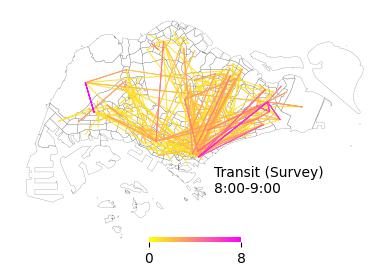

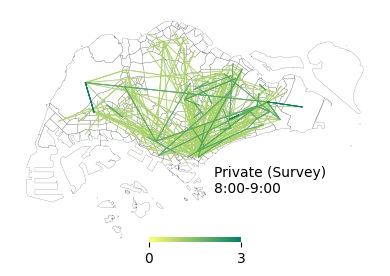

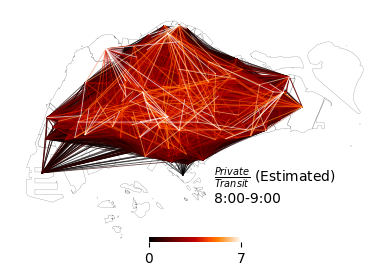

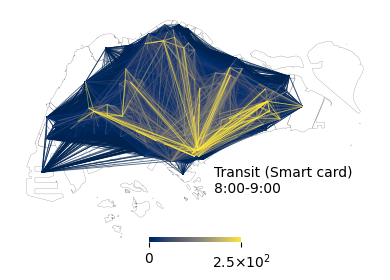

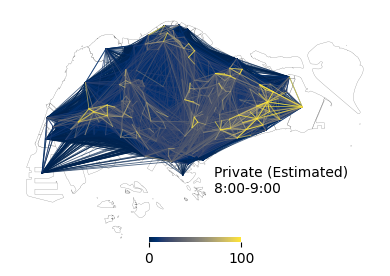

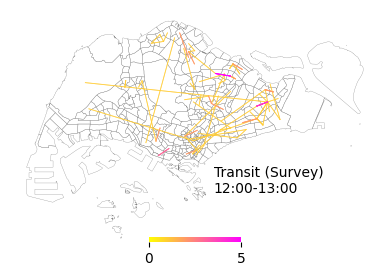

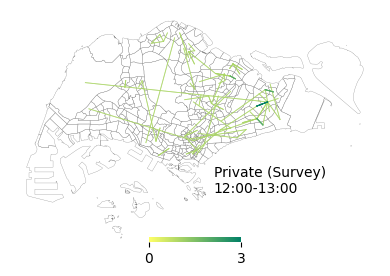

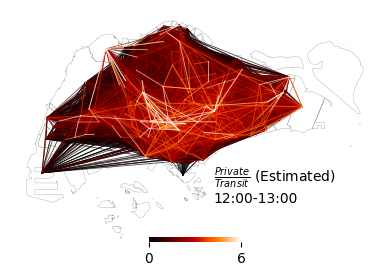

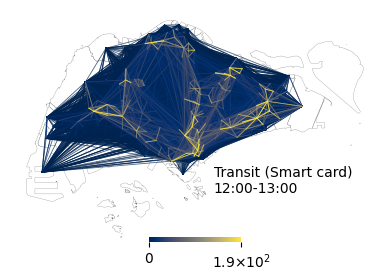

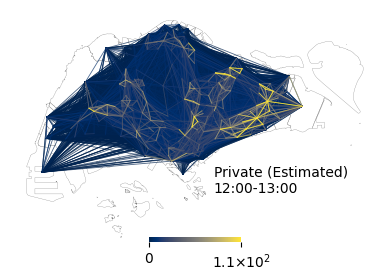

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def _sci_notation(val, prec=1):
    """Format number: plain if <100, else a×10^n."""
    if abs(val) < 100:   # show plain integer/float
        return str(int(round(val)))# if val.is_integer() else f"{val:.{prec}f}"
    else:
        s = f"{val:.{prec}e}"  # e.g., 1.23e+05
        base, exp = s.split("e")
        exp = int(exp)
        return rf"{base}×10$^{exp}$"

def add_mode_ratio_with_smooth(
    survey_df,
    walk_mode=False,
    walk_threshold=5,
    clip_ratio_value=5,
    lambdaa=5,
    eps=1e-9
):
    """
    Smoothed OT/PT ratio per (ORIGIN_SUBZONE, DESTINATION_SUBZONE, TRIP_STARTTIME).
    The prior mu is time-of-day specific and OD-marginal:
      - mu_O at (ORIGIN_SUBZONE, TRIP_STARTTIME)
      - mu_D at (DESTINATION_SUBZONE, TRIP_STARTTIME)
    They are blended with PT-count weights. If both are missing, fall back to a
    time-specific global prior at TRIP_STARTTIME.

    Assumes `att_subzone = ['ORIGIN_SUBZONE','DESTINATION_SUBZONE','TRIP_STARTTIME']`
    exists in the outer scope (same as your original code).
    """

    # -------------------------------
    # 1) OD-time group PT/OT counts
    # -------------------------------
    transit_df = survey_df.loc[survey_df['TRAVEL_MODE'] == 'PT', att_subzone].copy()
    N_pt = len(transit_df)
    transit_df['PT_COUNT'] = 1
    transit_df['PT_COUNT'] = transit_df.groupby(att_subzone)['PT_COUNT'].transform('sum')
    transit_df = transit_df[att_subzone + ['PT_COUNT']].drop_duplicates()

    other_df = survey_df.loc[survey_df['TRAVEL_MODE'] == 'OT', att_subzone].copy()
    N_ot = len(other_df)
    other_df['OT_COUNT'] = 1
    other_df['OT_COUNT'] = other_df.groupby(att_subzone)['OT_COUNT'].transform('sum')
    other_df = other_df[att_subzone + ['OT_COUNT']].drop_duplicates()

    survey_df_ = survey_df.copy()
    survey_df_ = survey_df_.merge(transit_df, on=att_subzone)
    survey_df_ = survey_df_.merge(other_df,   on=att_subzone)

    survey_df_['COUNT']    = survey_df_['PT_COUNT'] + survey_df_['OT_COUNT']
    survey_df_['RATIO']    = survey_df_['OT_COUNT'] / (survey_df_['PT_COUNT'] + eps)

    # ------------------------------------------------------------
    # 2) Time-of-day specific priors at origin and destination
    # ------------------------------------------------------------
    # mu_O( origin, t ) = OT/PT using trips with same origin & time (any dest)
    orig_pivot = (
        survey_df
        .groupby(['ORIGIN_SUBZONE', 'TRIP_STARTTIME', 'TRAVEL_MODE'])
        .size()
        .unstack(fill_value=0)
        .rename(columns={'PT': 'PT_O', 'OT': 'OT_O'})
        .reset_index()
    )
    orig_pivot['mu_O'] = orig_pivot['OT_O'] / (orig_pivot['PT_O'] + eps)

    # mu_D( dest, t ) = OT/PT using trips with same dest & time (any origin)
    dest_pivot = (
        survey_df
        .groupby(['DESTINATION_SUBZONE', 'TRIP_STARTTIME', 'TRAVEL_MODE'])
        .size()
        .unstack(fill_value=0)
        .rename(columns={'PT': 'PT_D', 'OT': 'OT_D'})
        .reset_index()
    )
    dest_pivot['mu_D'] = dest_pivot['OT_D'] / (dest_pivot['PT_D'] + eps)

    # ------------------------------------------------------------
    # 3) Time-of-day specific global prior as fallback: mu_global(t)
    # ------------------------------------------------------------
    global_time = (
        survey_df
        .groupby(['TRIP_STARTTIME', 'TRAVEL_MODE'])
        .size()
        .unstack(fill_value=0)
        .rename(columns={'PT': 'PT_T', 'OT': 'OT_T'})
        .reset_index()
    )
    global_time['mu_T'] = global_time['OT_T'] / (global_time['PT_T'] + eps)

    # ------------------------------------------------------------
    # 4) Merge priors back and blend mu_O and mu_D (PT-weighted)
    # ------------------------------------------------------------
    survey_df_ = survey_df_.merge(
        orig_pivot[['ORIGIN_SUBZONE', 'TRIP_STARTTIME', 'mu_O', 'PT_O']],
        on=['ORIGIN_SUBZONE', 'TRIP_STARTTIME'],
        how='left'
    )
    survey_df_ = survey_df_.merge(
        dest_pivot[['DESTINATION_SUBZONE', 'TRIP_STARTTIME', 'mu_D', 'PT_D']],
        on=['DESTINATION_SUBZONE', 'TRIP_STARTTIME'],
        how='left'
    )
    survey_df_ = survey_df_.merge(
        global_time[['TRIP_STARTTIME', 'mu_T']],
        on='TRIP_STARTTIME',
        how='left'
    )

    # PT weights for blending; if both zero, we'll fallback to mu_T
    w_o = survey_df_['PT_O'].fillna(0.0)
    w_d = survey_df_['PT_D'].fillna(0.0)
    w_sum = w_o + w_d

    # PT-weighted blend where available
    mu_blend = (w_o * survey_df_['mu_O'] + w_d * survey_df_['mu_D']) / (w_sum.replace(0, np.nan))

    # Fallback sequence: blended -> mu_O -> mu_D -> time-global mu_T -> 0
    mu = (
        mu_blend
        .fillna(survey_df_['mu_O'])
        .fillna(survey_df_['mu_D'])
        .fillna(survey_df_['mu_T'])
        .fillna(0.0)
    )

    # ---------------------------------------
    # 5) Apply shrinkage with time-specific mu
    # ---------------------------------------

    # decay parameter: controls how quickly ww2 approaches 1
    # Use 98th percentile instead of max
    max_count = survey_df_['COUNT'].max()
    scale_val = survey_df_['COUNT'].quantile(0.98)
    p = lambdaa  # curvature control; higher p = slower rise

    # Compute ww2 with clipping
    survey_df_['ww2'] = (survey_df_['COUNT'] / scale_val) ** p
    survey_df_['ww2'] = survey_df_['ww2'].clip(lower=0.0, upper=1.0)

    # Apply smoothing
    survey_df_['RATIO'] = (
        survey_df_['ww2'] * survey_df_['RATIO'] +
        (1 - survey_df_['ww2']) * mu
    )

    # Clean up
    survey_df_.drop(columns=['ww2'], inplace=True)


    # Force OT_COUNT = 0 for walking-distance trips
    if walk_mode:
        survey_df_.loc[survey_df_['TRIP_DISTANCE'] >= walk_threshold, 'RATIO'] = 0

    # clip
    if clip_ratio_value is not None:
        survey_df_['RATIO'] = survey_df_['RATIO'].clip(upper=clip_ratio_value*mu)

    # Optional convenience: smoothed OT_COUNT, then drop internals
    survey_df_['OT_COUNT'] = survey_df_['PT_COUNT'] * survey_df_['RATIO']
    survey_df_.drop(
        columns=['mu_O','mu_D','mu_T','PT_O','PT_D'],
        inplace=True,
        errors='ignore'
    )

    return survey_df_


def plot_OD_subzone_inter(
    dfz,
    att,
    mode,
    week_day,
    time,
    color_map,
    max_prob=None,
):
    """
    Inter-zone flows with a continuous colormap.
    Colorbar style matches the intra-zone plot: inside map, ticks at 0 and max (scientific).
    """
    df = dfz.copy()

    # Respect provided OD order (or fallback to ascending by COUNT)
    df_plot = df.sort_values(att, ascending=True)

    # Colormap & normalization (match intra)
    if max_prob is None:
        max_prob = df_plot[att].max()

    if mode in ['Ratio_VH', 'Ratio_WK', 'Transit (Smart card)',
            'Private (Estimated)', 'Walk (Estimated)']:
        max_prob = df_plot[att].quantile(0.999)

    norm = Normalize(vmin=0, vmax=max_prob)
    cmap = cm.get_cmap(color_map)

    # Boundaries (for extent/overlay)
    gdf = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
    boundary = gdf.dissolve()

    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    ax.set_axis_off()

    gdf.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.2)

    # Draw inter-zone curves
    for _, row in df_plot.iterrows():
        x0, y0 = row['ORIGIN_SUBZONE_X'],      row['ORIGIN_SUBZONE_Y']
        x1, y1 = row['DESTINATION_SUBZONE_X'], row['DESTINATION_SUBZONE_Y']
        ctrl_x, ctrl_y = (x0 + x1) / 2.0, (y0 + y1) / 2.0
        t = np.linspace(0, 1, 50)
        xs = (1 - t)**3 * x0 + 3*(1 - t)**2*t*ctrl_x + 3*(1 - t)*t**2*ctrl_x + t**3 * x1
        ys = (1 - t)**3 * y0 + 3*(1 - t)**2*t*ctrl_y + 3*(1 - t)*t**2*ctrl_y + t**3 * y1
        ax.plot(xs, ys, color=cmap(norm(row[att])), linewidth=0.6, alpha=0.7)

    ttime = f'{time}:00-{time+1}:00'

    modde = mode
    if mode == 'Ratio_VH':
        modde = r'$\frac{Private}{Transit}$ (Estimated)'
    elif mode == 'Ratio_WK':
        modde = r'$\frac{Walk}{Transit}$ (Estimated)'

    plt.gca().text(
        0.55, 0.35, f'{modde}\n{ttime}',
        transform=plt.gca().transAxes,
        verticalalignment='top'
    )

    # --- Colorbar INSIDE the map, 2 ticks (0 & max), scientific mantissa format ---
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = inset_axes(ax, width="25%", height="2%", loc='lower center', borderpad=0.5)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_ticks([0, max_prob])
    cbar.set_ticklabels(["0", _sci_notation(max_prob, prec=1)])
    # Remove colorbar border
    for spine in cbar.ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.savefig(path_od_figure + f'method_{reg}_{week_day}_{time}_{mode}.png', dpi=300, bbox_inches='tight')
    plt.show()

#######################
color_map1 = 'spring_r'
color_map2 = 'summer_r'
color_map3 = 'gist_heat'
color_map4 = 'cividis'
color_map5 = 'cividis'

eps = 1e-9
week_day = 'mon_wed'
reg = 'sgp'
wk_threshold = 3.5
clip_ratio = 5
k = 1.0
mode = 'WK'

att_subzone = ['ORIGIN_SUBZONE',
               'DESTINATION_SUBZONE',
               'TRIP_STARTTIME'
               ]

fig_x = 4
fig_y = 4

for time in [8,12]:
    survey_df = pd.read_csv(path_od_data + f'data_{reg}_hts_2022_period.csv')
    gen_df = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')

    survey_df = survey_df[survey_df['TRIP_STARTTIME'] == time]
    gen_df = gen_df[gen_df['TRIP_STARTTIME'] == time]

    ####################### HTS #####################

    transit_df = survey_df.loc[survey_df['TRAVEL_MODE'] == 'PT', att_subzone].copy()
    transit_df['PT_COUNT'] = 1
    transit_df['PT_COUNT'] = transit_df.groupby(att_subzone)['PT_COUNT'].transform('sum')
    transit_df = transit_df[att_subzone + ['PT_COUNT']].drop_duplicates()

    other_df = survey_df.loc[survey_df['TRAVEL_MODE'] == mode, att_subzone].copy()
    other_df[f'{mode}_COUNT'] = 1
    other_df[f'{mode}_COUNT'] = other_df.groupby(att_subzone)[f'{mode}_COUNT'].transform('sum')
    other_df = other_df[att_subzone + [f'{mode}_COUNT']].drop_duplicates()

    survey_df_ = survey_df.copy()
    survey_df_ = survey_df_.merge(transit_df, on=att_subzone)
    survey_df_ = survey_df_.merge(other_df,   on=att_subzone)

    survey_df_['RATIO'] = survey_df_[f'{mode}_COUNT'] / (survey_df_['PT_COUNT'] + eps)

    ####################### gen #####################

    gen_df['RATIO'] = gen_df[f'{mode}_COUNT'] / (gen_df['PT_COUNT'] + eps)
    data_subzone = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
    data_subzone['X'] = data_subzone.geometry.centroid.x
    data_subzone['Y'] = data_subzone.geometry.centroid.y
    data_subzone = data_subzone[['SUBZONE_C', 'X', 'Y']]

    gen_df = gen_df.merge(data_subzone, right_on='SUBZONE_C', left_on='ORIGIN_SUBZONE')
    gen_df.drop(columns=['SUBZONE_C'], inplace=True)
    gen_df.rename(columns={'X':'ORIGIN_SUBZONE_X', 'Y':'ORIGIN_SUBZONE_Y'}, inplace=True)
    gen_df = gen_df.merge(data_subzone, right_on='SUBZONE_C', left_on='DESTINATION_SUBZONE')
    gen_df.drop(columns=['SUBZONE_C'], inplace=True)
    gen_df.rename(columns={'X':'DESTINATION_SUBZONE_X', 'Y':'DESTINATION_SUBZONE_Y'}, inplace=True)

    ##############################################

    modee = 'Private'
    if mode == 'WK':
        modee = 'Walk'

    survey_df_ = survey_df_[survey_df_['ORIGIN_SUBZONE'] != survey_df_['DESTINATION_SUBZONE']]
    gen_df = gen_df[gen_df['ORIGIN_SUBZONE'] != gen_df['DESTINATION_SUBZONE']]

    plot_OD_subzone_inter(survey_df_, 'PT_COUNT', 'Transit (Survey)', week_day, time, color_map1)
    plot_OD_subzone_inter(survey_df_, f'{mode}_COUNT', f'{modee} (Survey)', week_day, time, color_map2)
    plot_OD_subzone_inter(gen_df, 'RATIO', f'Ratio_{mode}', week_day, time, color_map3)
    plot_OD_subzone_inter(gen_df, 'PT_COUNT', 'Transit (Smart card)', week_day, time, color_map4)
    plot_OD_subzone_inter(gen_df, f'{mode}_COUNT', f'{modee} (Estimated)', week_day, time,  color_map5)

#========================================

# SFig transit demand only

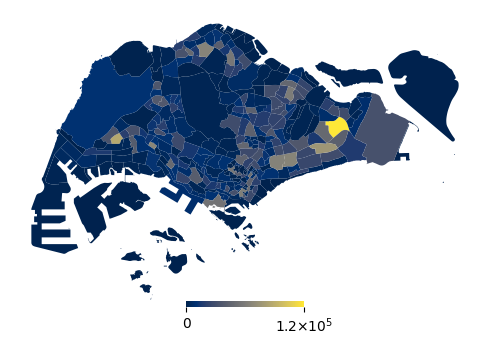

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def _sci_notation(x, prec=1):
    if x is None or pd.isna(x) or x == 0:
        return "0"
    import math
    exp = int(math.floor(math.log10(abs(x))))
    mant = x / (10 ** exp)
    return rf"{mant:.{prec}f}×10$^{exp}$"

def plot_subzone(
    dfz,
    max_prob=None,
    *,
    shp_path=None,            # e.g., path_od_data + f"data_{reg}_subzone.shp"
    id_col="SUBZONE_C",       # ID column in the shapefile
    value_col="COUNT",        # name used inside the plot for values
    df_id_col=None,           # if dfz is a DataFrame, its ID column (e.g., "ORIGIN_SUBZONE")
    df_value_col=None,        # if dfz is a DataFrame, its value column (e.g., "COUNT")
    cmap_name="gist_heat_r",
    fig_size=(4, 4)
):
    """
    Plots subzones colored by continuous values. Missing zones get value 0.
    Colorbar inside plot shows only 0 and max (scientific-style label).
    """

    # ---- 0) Resolve shapefile path ----
    if shp_path is None:
        # Falls back to globals if not provided
        shp_path = path_od_data + f"data_{reg}_subzone.shp"

    # ---- 1) Load subzones ----
    gdf = gpd.read_file(shp_path)

    # ---- 2) Build mapping from dfz ----
    if isinstance(dfz, (pd.Series, dict)):
        mapping = dict(dfz) if isinstance(dfz, pd.Series) else dfz
    elif isinstance(dfz, pd.DataFrame):
        # Try to infer id/value columns if not given
        _id = df_id_col
        _val = df_value_col
        if _id is None or _val is None:
            # heuristic: prefer provided defaults or common names
            candidates_id = [df_id_col, "SUBZONE_C", "ORIGIN_SUBZONE", "ZONE", "ID"]
            candidates_val = [df_value_col, "COUNT", "VAL", "VALUE"]
            _id = next(c for c in candidates_id if c is not None and c in dfz.columns)
            _val = next(c for c in candidates_val if c is not None and c in dfz.columns)
        mapping = dfz.set_index(_id)[_val].to_dict()
    else:
        raise TypeError("dfz must be a pandas DataFrame, Series, or dict.")

    # Ensure type compatibility for keys (int vs str)
    # If gdf[id_col] is numeric, coerce mapping keys to numeric where possible
    if pd.api.types.is_integer_dtype(gdf[id_col]) or pd.api.types.is_numeric_dtype(gdf[id_col]):
        try:
            mapping = {int(k): v for k, v in mapping.items()}
        except Exception:
            pass  # keep as-is if conversion fails

    # ---- 3) Map values, fill missing with zero ----
    gdf[value_col] = gdf[id_col].map(mapping).fillna(0)

    # ---- 4) Normalization ----
    data_max = float(gdf[value_col].max()) if len(gdf) else 0.0
    if max_prob is None:
        max_prob = data_max
    # Avoid a degenerate norm if all zeros
    if max_prob <= 0:
        max_prob = 1.0
    norm = Normalize(vmin=0, vmax=max_prob)
    cmap = cm.get_cmap(cmap_name)

    # ---- 5) Plot ----
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_axis_off()

    gdf.plot(
        column=value_col,
        cmap=cmap,
        norm=norm,
        ax=ax,
        edgecolor="none",
        linewidth=0,
        alpha=1.0,
        antialiased=True
    )

    # Optional: overlay boundaries (invisible edgecolor above already hides outlines)
    # gdf.boundary.plot(ax=ax, color='none', linewidth=0.0)

    # ---- Colorbar inside ----
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = inset_axes(ax, width="25%", height="2%", loc="lower center", borderpad=0.5)
    cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")

    # Only 0 and max
    cbar.set_ticks([0, max_prob])
    cbar.set_ticklabels(["0", _sci_notation(max_prob, prec=1)])

    # Remove border
    for spine in cbar.ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    out_path = path_od_figure + f"case_{reg}_origin_transit.png"
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()

#########################################

week_days = ['mon_wed', 'thu_fri', 'sat_sun']
color_map = 'cividis' #'autumn_r'#'gist_heat_r'#'plasma' #'Spectral_r'#'viridis'# #gist_heat_r

fig_x = 5
fig_y = 5
week_day = week_days[0]
reg = 'sgp'

df_fus = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')
df_fus['COUNT'] = df_fus['PT_COUNT']
df_fus = df_fus[['ORIGIN_SUBZONE', 'COUNT']]
df_fus['COUNT'] = df_fus.groupby(['ORIGIN_SUBZONE'])['COUNT'].transform('sum')
df_fus.drop_duplicates(inplace = True)

plot_subzone(
    df_fus,
    shp_path=path_od_data + f'data_{reg}_subzone.shp',
    df_id_col='ORIGIN_SUBZONE',
    df_value_col='COUNT',
    cmap_name=color_map,
    fig_size=(fig_x, fig_y)
)



#SFig time-of-day

sum true  156615.90263547184
sum result  152207.9644140065


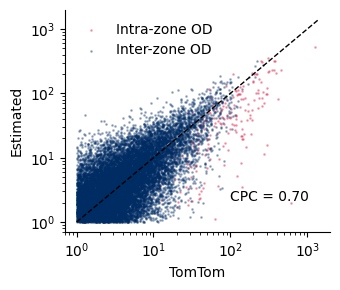

Validation Results:
- Method: xgboost
- ReMAE: 5.9604e-01 
- CPC: 7.0467e-01 
- RMSE: 2.0268e+02
- Length: 15938
sum true  111968.5397329457
sum result  103819.5772669889


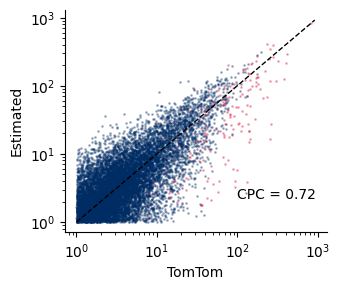

Validation Results:
- Method: xgboost
- ReMAE: 5.6363e-01 
- CPC: 7.2334e-01 
- RMSE: 1.3412e+02
- Length: 11237
sum true  178399.44948285903
sum result  177380.60225909876


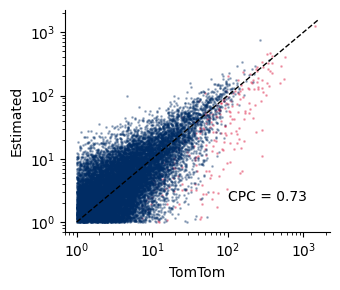

Validation Results:
- Method: xgboost
- ReMAE: 5.6559e-01 
- CPC: 7.2625e-01 
- RMSE: 1.7054e+02
- Length: 17543


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy.stats import gaussian_kde
from matplotlib.ticker import ScalarFormatter


#################################################


def assign_travel_period(df):
    """
    Assign a broader travel period based on 2-hour time bins in the 'TRIP_STARTTIME' column.

    Parameters:
        df (pd.DataFrame): A DataFrame with a 'TRIP_STARTTIME' column ranging from 0 to 11.

    Returns:
        pd.DataFrame: The original DataFrame with an added 'TRAVEL_PERIOD' column.
    """
    def map_to_period(index):
        if index in [0, 1, 2, 10, 11]:
            return 0
        elif index in [3, 4]:
            return 1
        elif index in [5, 6, 7]:
            return 2
        elif index in [8, 9]:
            return 3
        else:
            return 'Unknown'  # In case of missing or invalid index

    df['TRIP_STARTTIME'] = df['TRIP_STARTTIME'].apply(map_to_period)
    return df


#############################

import matplotlib.ticker as mticker

def plot_scatter_log10(smartcard_df, true_df, attributes, method_name, region, att_s, max_val, k, time):
    """
    Scatter plot of predicted vs. true OD probabilities with log10 axes (10^x).
    Includes CPC metric and 1:1 reference line. Intra- and inter-zone shown with
    different legends in the same figure (no legend box, no right/top spines).
    """
    # Step 1: Prepare data
    smartcard_df_ = smartcard_df[attributes + ['COUNT']].copy()
    true_df_ = true_df[attributes + ['COUNT']].copy()

    smartcard_df_['COUNT'] = smartcard_df_.groupby(attributes)['COUNT'].transform('sum')
    true_df_['COUNT'] = true_df_.groupby(attributes)['COUNT'].transform('sum')

    smartcard_df_.drop_duplicates(inplace=True)
    true_df_.drop_duplicates(inplace=True)

    # Step 2: Merge
    merged_df = pd.merge(smartcard_df_, true_df_, on=attributes, suffixes=('_pred', '_true'))
    merged_df['PROB_pred'] = merged_df['COUNT_pred']
    merged_df['PROB_true'] = merged_df['COUNT_true']

    #merged_df = merged_df[merged_df['PROB_pred'] >=5]
    #merged_df = merged_df[merged_df['PROB_true'] >=5]

    # Identify O and D keys for intra/inter split
    if 'O' in attributes and 'D' in attributes:
        O_key, D_key = 'O', 'D'
    else:
        O_candidates = [c for c in attributes if c.upper().startswith('O')]
        D_candidates = [c for c in attributes if c.upper().startswith('D')]
        if not O_candidates or not D_candidates:
            raise ValueError("Attributes must include origin/destination columns (e.g., 'O' and 'D').")
        O_key, D_key = O_candidates[0], D_candidates[0]

    merged_df['__is_intra__'] = (merged_df[O_key] == merged_df[D_key])

    # Step 3: Metrics (overall)
    rmae = np.sum(np.abs(merged_df['PROB_pred'] - merged_df['PROB_true']))/ np.sum(merged_df['PROB_true'])
    rmse = np.mean((merged_df['PROB_pred'] - merged_df['PROB_true'])**2)
    cpc = 2 * np.sum(np.minimum(merged_df['PROB_pred'], merged_df['PROB_true'])) / \
          (np.sum(merged_df['PROB_pred']) + np.sum(merged_df['PROB_true']))

    # Step 4: Plot
    plt.figure(figsize=(fig_x, fig_y))

    # Intra
    m_intra = merged_df['__is_intra__']
    plt.scatter(
        merged_df.loc[m_intra, 'PROB_true'],
        merged_df.loc[m_intra, 'PROB_pred'],
        s=1, alpha=0.3, label='Intra-zone OD', color=colors[0]
    )

    # Inter
    m_inter = ~m_intra
    plt.scatter(
        merged_df.loc[m_inter, 'PROB_true'],
        merged_df.loc[m_inter, 'PROB_pred'],
        s=1, alpha=0.3, label='Inter-zone OD', color=colors[1]
    )

    # Reference line
    if max_val is None:
        max_val_ = max(merged_df['PROB_true'].max(), merged_df['PROB_pred'].max())
        plt.plot([1, max_val_*1.1], [1, max_val_*1.1],
                 color="black", linestyle="--", linewidth=1)
    else:
        plt.plot([1, max_val*1.1], [1, max_val*1.1],
                 color="black", linestyle="--", linewidth=1)

    # Log scaling
    plt.xscale("log")
    plt.yscale("log")

    # Format ticks as 10^x
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mticker.LogFormatterMathtext())
    ax.yaxis.set_major_formatter(mticker.LogFormatterMathtext())

    # Hide right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xlabel("TomTom")
    plt.ylabel("Estimated")

    # Legend without box
    if time == 8:
        plt.legend(frameon=False)
    plt.tight_layout()

    plt.gca().text(
        10**2., 10**0.5, f'CPC = {cpc:.2f}',
        verticalalignment='top'
    )
    fname = f'case_validation_{region}_od_{time}.png'


    '''plt.gca().text(
        10**3, 10, f'CPC = {cpc:.2f}',
        verticalalignment='top'
    )
    fname = f'case_validation_{region}_od.png'
    '''


    plt.savefig(path_od_figure + fname, dpi=400, bbox_inches='tight')
    plt.show()

    # Print metrics
    print(f"Validation Results:\n- Method: {method_name}\n- ReMAE: {rmae:.4e} \n- CPC: {cpc:.4e} \n- RMSE: {rmse:.4e}\n- Length: {len(merged_df)}")

    return cpc



################################################

#colors = ['red', 'darkslateblue']
colors = ['crimson', '#002C64']

wws = ['mon_wed', 'thu_fri', 'sat_sun']
model = 'xgboost'
reg = 'sgp'
week_day = wws[0]
fig_x = 3.5
fig_y = 3
k = '1.0'

att = ['ORIGIN_SUBZONE','DESTINATION_SUBZONE',
       'TRIP_STARTTIME'
       ]

true_df__ = pd.read_csv(path_od_result + f'case_{reg}_matrix_tomtom_{week_day}.csv')
result_df__ = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')
result_df__['COUNT'] = result_df__['VH_COUNT']

for time in [8, 12, 17]:
    true_df = true_df__[true_df__['TRIP_STARTTIME'] == time]
    result_df = result_df__[result_df__['TRIP_STARTTIME'] == time]

    true_df = true_df[att + ['COUNT']]
    true_df['COUNT'] = true_df.groupby(att)['COUNT'].transform('sum')
    true_df.drop_duplicates(inplace=True)
    print('sum true ', true_df['COUNT'].sum())

    result_df = result_df[att + ['COUNT']]
    result_df['COUNT'] = result_df.groupby(att)['COUNT'].transform('sum')
    result_df.drop_duplicates(inplace=True)

    cap_val = 1

    true_df = true_df[true_df['COUNT'] >=cap_val]
    result_df = result_df[result_df['COUNT'] >=cap_val]

    max_val_od = max(result_df['COUNT'].max(), true_df['COUNT'].max())
    print('sum result ', result_df['COUNT'].sum())

    cpc = plot_scatter_log10(result_df, true_df, attributes=att, method_name=model, region=reg, att_s='OD', max_val=max_val_od, k=k, time=time)



Time: 8*******************************************
sum result: 175585.96441400654
sum true: 162017.73833793928
Generated, Intra-zone  12294.337617719439


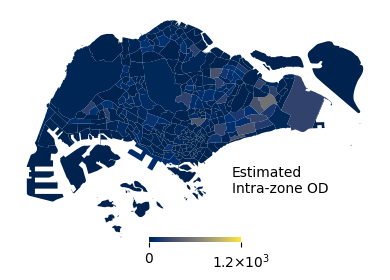

Cellular, Intra-zone 24331.525300024336


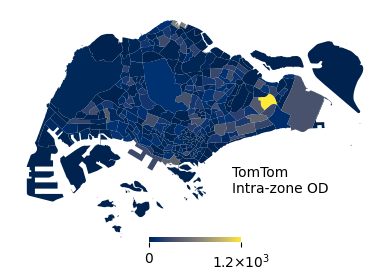

Generated, Inter-zone  163291.62679628705


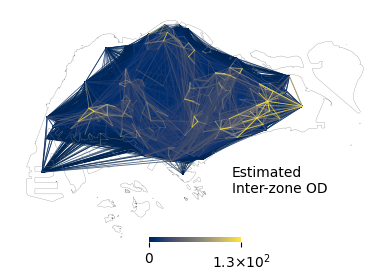

Cellular, Inter-zone  137686.21303791492


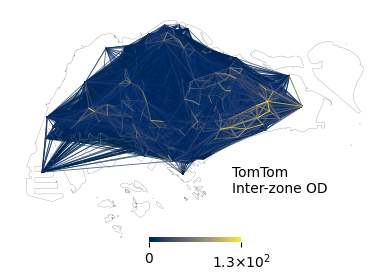

Intra-zone CPC: 0.6459
Inter-zone CPC:   0.6768
Time: 12*******************************************
sum result: 127210.5772669889
sum true: 118267.62230726315
Generated, Intra-zone  12288.96429169034


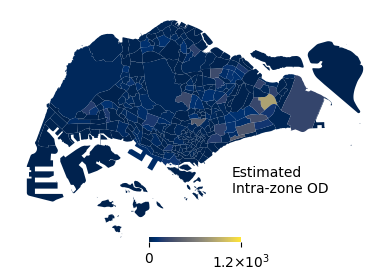

Cellular, Intra-zone 18073.073566961484


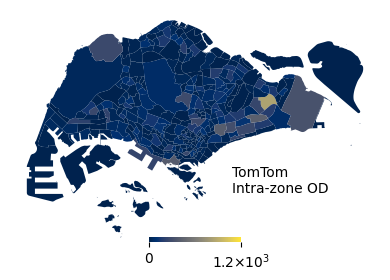

Generated, Inter-zone  114921.61297529856


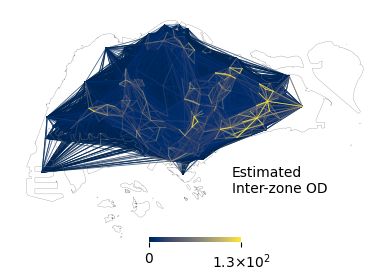

Cellular, Inter-zone  100194.54874030167


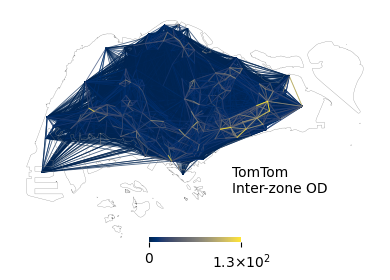

Intra-zone CPC: 0.7083
Inter-zone CPC:   0.7084
Time: 17*******************************************
sum result: 204731.60225909876
sum true: 185255.69249449763
Generated, Intra-zone  15535.942832085566


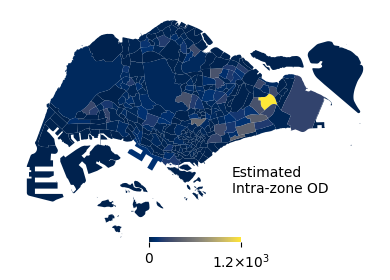

Cellular, Intra-zone 26188.126449738258


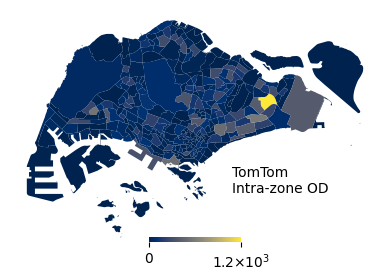

Generated, Inter-zone  189195.6594270132


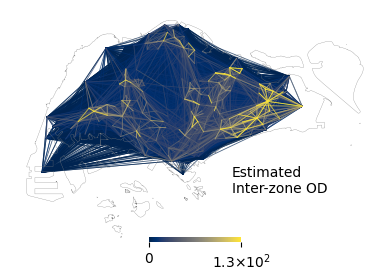

Cellular, Inter-zone  159067.56604475935


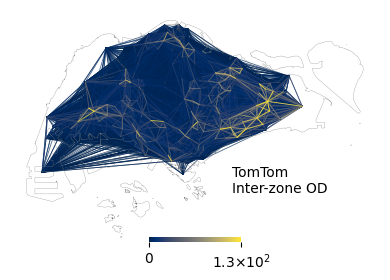

Intra-zone CPC: 0.7054
Inter-zone CPC:   0.7020


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def _build_od_order_from_df1(df1_inter):
    order_df = (
        df1_inter[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']]
        .sort_values('COUNT', ascending=True)
        .drop_duplicates(subset=['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'], keep='first')
        .reset_index(drop=True)
    )
    order_df['ORDER_IDX'] = np.arange(len(order_df), dtype=int)
    return order_df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'ORDER_IDX']]

def _sci_notation(val, prec=1):
    """Format number: plain if <100, else a×10^n."""
    if abs(val) < 100:   # show plain integer/float
        return str(int(round(val))) if val.is_integer() else f"{val:.{prec}f}"
    else:
        s = f"{val:.{prec}e}"  # e.g., 1.23e+05
        base, exp = s.split("e")
        exp = int(exp)
        return rf"{base}×10$^{exp}$"


def plot_OD_subzone_inter(
    dfz,
    cc,
    max_prob=None,
    time=None,
    od_order=None
):
    """
    Inter-zone flows with a continuous colormap.
    If `od_order` (with ORDER_IDX) is provided, the plot strictly follows that order.
    Colorbar style matches the intra-zone plot: inside map, ticks at 0 and max (scientific).
    """
    df = dfz.copy()

    # Respect provided OD order (or fallback to ascending by COUNT)
    if od_order is not None:
        df_plot = (
            df.merge(od_order, on=['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'], how='inner')
              .sort_values('ORDER_IDX')
        )
    else:
        df_plot = df.sort_values('COUNT', ascending=True)

    # Colormap & normalization (match intra)
    if max_prob is None:
        max_prob = df_plot['COUNT'].max()
    norm = Normalize(vmin=0, vmax=max_prob)
    cmap = cm.get_cmap(color_map)

    # Boundaries (for extent/overlay)
    gdf = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
    boundary = gdf.dissolve()

    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    ax.set_axis_off()

    # Draw inter-zone curves
    for _, row in df_plot.iterrows():
        x0, y0 = row['ORIGIN_SUBZONE_X'],      row['ORIGIN_SUBZONE_Y']
        x1, y1 = row['DESTINATION_SUBZONE_X'], row['DESTINATION_SUBZONE_Y']
        ctrl_x, ctrl_y = (x0 + x1) / 2.0, (y0 + y1) / 2.0
        t = np.linspace(0, 1, 50)
        xs = (1 - t)**3 * x0 + 3*(1 - t)**2*t*ctrl_x + 3*(1 - t)*t**2*ctrl_x + t**3 * x1
        ys = (1 - t)**3 * y0 + 3*(1 - t)**2*t*ctrl_y + 3*(1 - t)*t**2*ctrl_y + t**3 * y1
        ax.plot(xs, ys, color=cmap(norm(row['COUNT'])), linewidth=0.6, alpha=0.7)

    #boundary.plot(ax=ax, color='none', edgecolor='none', linewidth=0.0)
    boundary.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.2, zorder=3)

    plt.gca().text(
        0.6, 0.35, f'{cc}\nInter-zone OD',
        transform=plt.gca().transAxes,
        verticalalignment='top'
    )

    # --- Colorbar INSIDE the map, 2 ticks (0 & max), scientific mantissa format ---
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = inset_axes(ax, width="25%", height="2%", loc='lower center', borderpad=0.5)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_ticks([0, max_prob])
    cbar.set_ticklabels(["0", _sci_notation(max_prob, prec=1)])
    # Remove colorbar border
    for spine in cbar.ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.savefig(path_od_figure + f'case_validation_inter_od_{reg}_{cc}_{time}.png', dpi=300, bbox_inches='tight')
    plt.show()



# ---- 1) Canonical order from df1 (ascending by COUNT) ----
def _build_od_order_from_df1z(df1_inter):
    order_df = (
        df1_inter[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']]
        .sort_values('COUNT', ascending=True)
        .drop_duplicates(subset=['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'], keep='first')
        .reset_index(drop=True)
    )
    order_df['ORDER_IDX'] = np.arange(len(order_df), dtype=int)
    return order_df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'ORDER_IDX']]


# ---- 3) Driver: prepare coords, build order from df1, plot both in that order ----
def show_demand_OD_inter(df1, df2, time, max_inter):
    data_subzone = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
    data_subzone['X'] = data_subzone.geometry.centroid.x
    data_subzone['Y'] = data_subzone.geometry.centroid.y
    data_subzone = data_subzone[['SUBZONE_C', 'X', 'Y']]

    def _prepare(df):
        df_ = df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']].copy()
        df_ = df_.merge(data_subzone, right_on='SUBZONE_C', left_on='ORIGIN_SUBZONE') \
                 .drop(columns=['SUBZONE_C']) \
                 .rename(columns={'X': 'ORIGIN_SUBZONE_X', 'Y': 'ORIGIN_SUBZONE_Y'})
        df_ = df_.merge(data_subzone, right_on='SUBZONE_C', left_on='DESTINATION_SUBZONE') \
                 .drop(columns=['SUBZONE_C']) \
                 .rename(columns={'X': 'DESTINATION_SUBZONE_X', 'Y': 'DESTINATION_SUBZONE_Y'})
        # Sum duplicates and dedupe
        df_['COUNT'] = df_.groupby(
            ['ORIGIN_SUBZONE', 'ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y',
             'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y']
        )['COUNT'].transform('sum')
        df_.drop_duplicates(inplace=True)
        return df_

    df1_ = _prepare(df1)
    df2_ = _prepare(df2)

    # Inter-zone only
    df1__ = df1_[df1_['ORIGIN_SUBZONE'] != df1_['DESTINATION_SUBZONE']].copy()
    df2__ = df2_[df2_['ORIGIN_SUBZONE'] != df2_['DESTINATION_SUBZONE']].copy()

    # --- Canonical order from df1 (ascending by COUNT) ---
    od_order = _build_od_order_from_df1(df1__)

    # Shared color normalization across both plots
    mazzz = max( df1__['COUNT'].max(), df2__['COUNT'].max())
    #mazzz = min(df1__['COUNT'].quantile(0.999), df2__['COUNT'].quantile(0.999))
    mazzz = max_inter
    print('Generated, Inter-zone ', df1__['COUNT'].sum())
    plot_OD_subzone_inter(df1__, 'Estimated', mazzz, time, od_order=od_order)
    print('Cellular, Inter-zone ', df2__['COUNT'].sum())
    plot_OD_subzone_inter(df2__, 'TomTom', mazzz, time, od_order=od_order)


########################################################

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def sci_notation(val, prec=1):
    """Format number as a.b × 10^n"""
    s = f"{val:.{prec}e}"  # e.g. 1.23e+05
    base, exp = s.split("e")
    exp = int(exp)  # convert to int
    return rf"{base}×10$^{exp}$"

def plot_OD_subzone_intra(
    dfz,
    cc,
    max_prob=None,
    time=None
):
    """
    Intra-zone, continuous colormap, missing zones get COUNT=0.
    Colorbar inside plot with only 0 and max value (scientific with mantissa).
    """
    # 1) load all subzones
    gdf = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')

    # 2) compute intra-zone counts
    intra    = dfz[dfz.ORIGIN_SUBZONE == dfz.DESTINATION_SUBZONE]
    zone_sum = intra.groupby('DESTINATION_SUBZONE')['COUNT'].sum()

    # 3) map counts onto full GeoDataFrame, fill missing with zero
    gdf['COUNT'] = gdf['SUBZONE_C'].map(zone_sum).fillna(0)

    # 4) determine normalization
    if max_prob is None:
        max_prob = gdf['COUNT'].max()
    norm = Normalize(vmin=0, vmax=max_prob)
    cmap = cm.get_cmap(color_map)

    # 5) plot map
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    ax.set_axis_off()
    gdf.plot(
        column='COUNT',
        cmap=cmap,
        norm=norm,
        ax=ax,
        edgecolor='none',
        linewidth=0,
        alpha=1.0,
        antialiased=True
    )

    # overlay boundaries
    gdf.boundary.plot(ax=ax, color='none', linewidth=0.0)

    plt.gca().text(
        0.6, 0.35, f'{cc}\nIntra-zone OD',
        transform=plt.gca().transAxes,
        verticalalignment='top'
    )

    # --- Colorbar inside plot ---
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = inset_axes(ax, width="25%", height="2%", loc='lower center', borderpad=0.5)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    # show only two ticks: 0 and max
    cbar.set_ticks([0, max_prob])
    cbar.set_ticklabels(["0", sci_notation(max_prob, prec=1)])
    # remove border line around colorbar
    for spine in cbar.ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.savefig(path_od_figure + f'case_validation_intra_od_{reg}_{cc}_{time}.png', dpi=300, bbox_inches='tight')
    plt.show()



def show_demand_OD_intra(df1, df2, time, max_intra):
    data_subzone = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
    data_subzone['X'] = data_subzone.geometry.centroid.x
    data_subzone['Y'] = data_subzone.geometry.centroid.y
    data_subzone = data_subzone[['SUBZONE_C', 'X', 'Y']]

    df1_ = df1[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']].copy()

    df1_ = df1_.merge(data_subzone, right_on='SUBZONE_C', left_on='ORIGIN_SUBZONE')
    df1_.drop(columns=['SUBZONE_C'], inplace=True)
    df1_.rename(columns={'X':'ORIGIN_SUBZONE_X', 'Y':'ORIGIN_SUBZONE_Y'}, inplace=True)
    df1_ = df1_.merge(data_subzone, right_on='SUBZONE_C', left_on='DESTINATION_SUBZONE')
    df1_.drop(columns=['SUBZONE_C'], inplace=True)
    df1_.rename(columns={'X':'DESTINATION_SUBZONE_X', 'Y':'DESTINATION_SUBZONE_Y'}, inplace=True)

    df1_ = df1_[['ORIGIN_SUBZONE', 'ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y','COUNT']]
    df1_['COUNT'] = df1_.groupby(['ORIGIN_SUBZONE','ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y'])['COUNT'].transform('sum')
    df1_.drop_duplicates(inplace = True)
    df1_.sort_values(by=['COUNT'], ascending=False, inplace=True)

    ###############################

    df2_ = df2[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']].copy()

    df2_ = df2_.merge(data_subzone, right_on='SUBZONE_C', left_on='ORIGIN_SUBZONE')
    df2_.drop(columns=['SUBZONE_C'], inplace=True)
    df2_.rename(columns={'X':'ORIGIN_SUBZONE_X', 'Y':'ORIGIN_SUBZONE_Y'}, inplace=True)
    df2_ = df2_.merge(data_subzone, right_on='SUBZONE_C', left_on='DESTINATION_SUBZONE')
    df2_.drop(columns=['SUBZONE_C'], inplace=True)
    df2_.rename(columns={'X':'DESTINATION_SUBZONE_X', 'Y':'DESTINATION_SUBZONE_Y'}, inplace=True)

    df2_ = df2_[['ORIGIN_SUBZONE', 'ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y','COUNT']]
    df2_['COUNT'] = df2_.groupby(['ORIGIN_SUBZONE','ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y'])['COUNT'].transform('sum')
    df2_.drop_duplicates(inplace = True)
    df2_.sort_values(by=['COUNT'], ascending=False, inplace=True)

    df1__ = df1_[df1_['ORIGIN_SUBZONE'] == df1_['DESTINATION_SUBZONE']]
    df2__ = df2_[df2_['ORIGIN_SUBZONE'] == df2_['DESTINATION_SUBZONE']]
    mazzz = max(df1__['COUNT'].max(), df2__['COUNT'].max())
    mazzz = max_intra
    #mazzz = min(df1__['COUNT'].quantile(0.999), df2__['COUNT'].quantile(0.999))
    print('Generated, Intra-zone ', df1__['COUNT'].sum())
    plot_OD_subzone_intra(df1__, 'Estimated', mazzz, time)
    print('Cellular, Intra-zone', df2__['COUNT'].sum())
    plot_OD_subzone_intra(df2__, 'TomTom', mazzz, time)


def compute_cpc(true_df, result_df, intra=True):
    """
    Compute CPC index for either intra- or inter-zone flows.

    Parameters
    ----------
    true_df : pd.DataFrame
        Ground truth OD matrix with ['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']
    result_df : pd.DataFrame
        Generated OD matrix with same columns.
    intra : bool
        If True, compute CPC for intra-zone flows (i == j);
        If False, for inter-zone flows (i ≠ j).

    Returns
    -------
    cpc : float
        CPC value between 0 and 1.
    """

    # Filter intra or inter flows
    if intra:
        mask_true = true_df['ORIGIN_SUBZONE'] == true_df['DESTINATION_SUBZONE']
        mask_pred = result_df['ORIGIN_SUBZONE'] == result_df['DESTINATION_SUBZONE']
    else:
        mask_true = true_df['ORIGIN_SUBZONE'] != true_df['DESTINATION_SUBZONE']
        mask_pred = result_df['ORIGIN_SUBZONE'] != result_df['DESTINATION_SUBZONE']

    df_true = true_df[mask_true].copy()
    df_pred = result_df[mask_pred].copy()

    # Merge on OD pair
    merged = pd.merge(
        df_true, df_pred,
        on=['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'],
        suffixes=('_true', '_pred'),
        how='outer'
    ).fillna(0)

    numerator   = 2 * (merged[['COUNT_true', 'COUNT_pred']].min(axis=1)).sum()
    denominator = merged['COUNT_true'].sum() + merged['COUNT_pred'].sum()

    return numerator / denominator if denominator > 0 else 0.0


#########################################################
color_map = 'cividis' #'Blues' #'autumn_r'#'gist_heat_r'#'plasma' #'Spectral_r'#'viridis'# #gist_heat_r
colors = ['red', 'darkcyan']
reg = 'sgp'
wws = ['mon_wed', 'thu_fri', 'sat_sun']
week_day = wws[0]

fig_x = 4
fig_y = 4

true_df = pd.read_csv(path_od_result + f'case_{reg}_matrix_tomtom_{week_day}.csv')
result_df__ = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')
result_df__['COUNT'] = result_df__['VH_COUNT']

max_intra = 0
max_inter = 0

for time in [8, 12, 17]:
    true_df = true_df__[true_df__['TRIP_STARTTIME'] == time]
    result_df = result_df__[result_df__['TRIP_STARTTIME'] == time]

    true_df['COUNT'] = true_df['COUNT'].clip(lower=1)
    result_df['COUNT'] = result_df['COUNT'].clip(lower=1)

    true_df = true_df[['ORIGIN_SUBZONE','DESTINATION_SUBZONE', 'COUNT']]
    result_df = result_df[['ORIGIN_SUBZONE','DESTINATION_SUBZONE', 'COUNT']]
    true_df['COUNT'] = true_df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'])['COUNT'].transform('sum')
    result_df['COUNT'] = result_df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'])['COUNT'].transform('sum')
    true_df.drop_duplicates(inplace=True)
    result_df.drop_duplicates(inplace=True)

    intra_true_df = true_df[true_df['ORIGIN_SUBZONE'] == true_df['DESTINATION_SUBZONE']]
    inter_true_df = true_df[true_df['ORIGIN_SUBZONE'] != true_df['DESTINATION_SUBZONE']]
    intra_result_df = result_df[result_df['ORIGIN_SUBZONE'] == result_df['DESTINATION_SUBZONE']]
    inter_result_df = result_df[result_df['ORIGIN_SUBZONE'] != result_df['DESTINATION_SUBZONE']]

    max_intra = max(max_intra, intra_true_df['COUNT'].quantile(0.999), intra_result_df['COUNT'].quantile(0.999))
    max_inter = max(max_inter, inter_true_df['COUNT'].quantile(0.999), inter_result_df['COUNT'].quantile(0.999))

for time in [8, 12, 17]:
    print(f'Time: {time}*******************************************')
    true_df = true_df__[true_df__['TRIP_STARTTIME'] == time]
    result_df = result_df__[result_df__['TRIP_STARTTIME'] == time]

    true_df['COUNT'] = true_df['COUNT'].clip(lower=1)
    result_df['COUNT'] = result_df['COUNT'].clip(lower=1)

    true_df = true_df[['ORIGIN_SUBZONE','DESTINATION_SUBZONE', 'COUNT']]
    result_df = result_df[['ORIGIN_SUBZONE','DESTINATION_SUBZONE', 'COUNT']]
    true_df['COUNT'] = true_df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'])['COUNT'].transform('sum')
    result_df['COUNT'] = result_df.groupby(['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE'])['COUNT'].transform('sum')
    true_df.drop_duplicates(inplace=True)
    result_df.drop_duplicates(inplace=True)

    print(f'sum result: {result_df["COUNT"].sum()}')
    print(f'sum true: {true_df["COUNT"].sum()}')

    show_demand_OD_intra(result_df, true_df, time, max_intra)
    show_demand_OD_inter(result_df, true_df, time, max_inter)

    cpc_intra = compute_cpc(true_df, result_df, intra=True)
    cpc_inter = compute_cpc(true_df, result_df, intra=False)
    print(f"Intra-zone CPC: {cpc_intra:.4f}")
    print(f"Inter-zone CPC:   {cpc_inter:.4f}")



['TMSZ02' 'GLSZ04' 'BDSZ04' 'GLSZ05' 'CHSZ03' 'TMSZ03' 'JWSZ09' 'BMSZ01'
 'NVSZ01' 'BDSZ05']


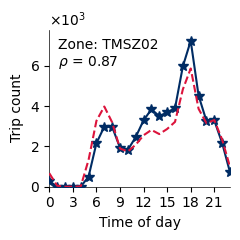

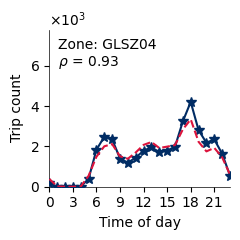

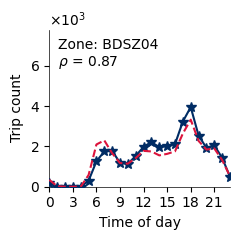

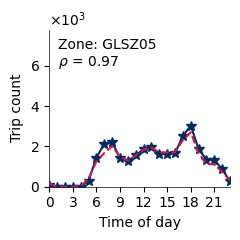

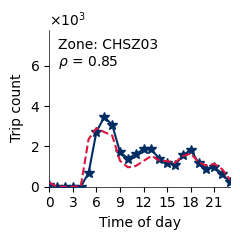

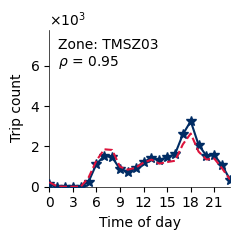

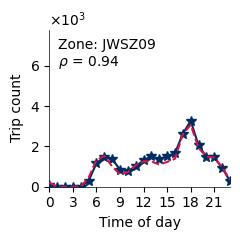

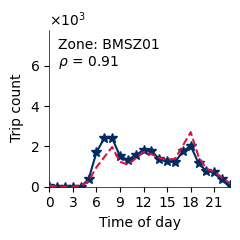

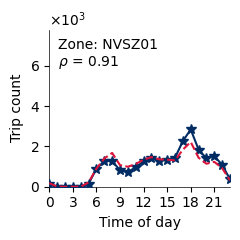

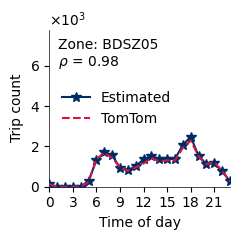

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
from scipy.stats import spearmanr


def plot_departure(df_gen, df_true, maxz, loc, att, i):
    plt.figure(figsize=(fig_x, fig_y))

    # Plot generated and ground truth
    plt.plot(df_gen['TRIP_STARTTIME'], df_gen['COUNT'], color=colors[1],
             marker='*', markersize=7, zorder=3, label='Estimated')

    plt.plot(df_true['TRIP_STARTTIME'], df_true['COUNT'],
             color=colors[0], linestyle='--', linewidth=1.5,
             label='TomTom', zorder=3)

    # Axis setup
    ax = plt.gca()
    ax.set_ylim(0, maxz)
    ax.set_xlim(0, 23)

    # Scientific notation in LaTeX style (1e6 -> 1×10^6)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(formatter)

    # Clean style
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major')

    # Force integer ticks on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.xlabel("Time of day")
    plt.ylabel("Trip count")

    # Thin spines
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    # Legend top-left
    if loc == 'BDSZ05':
        plt.legend(loc="center left", frameon=False)

    # === Spearman correlation ===
    rho, pval = spearmanr(df_gen['COUNT'], df_true['COUNT'])
    '''ax.text(
        0.05, 0.87, #0.4, 0.09,
        rf"$\rho$ = {rho:.2f}\n{ss}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top'
    )'''

    ax.text(
        0.05, 0.95,
        f"Zone: {loc}\n$\\rho$ = {rho:.2f}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top'
    )

    plt.tight_layout()
    fname = f'case_time_{reg}_{loc}_{i}.png'
    plt.savefig(path_od_figure + fname, dpi=400, bbox_inches='tight')
    plt.show()


#################################

#colors = ['crimson', '#4e79a7']
colors = ['crimson', '#002C64']
fig_x = 2.5
fig_y = 2.5
n = 10
reg = 'sgp'
wws = ['mon_wed', 'thu_fri', 'sat_sun']
week_day = wws[0]


df_pcm = pd.read_csv(path_od_result + f'case_{reg}_matrix_tomtom_{week_day}.csv')
df_fus = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')
df_fus['COUNT'] = df_fus['VH_COUNT']

# Aggregate counts for origins and destinations
top_origins = (
    df_pcm.groupby('ORIGIN_SUBZONE', as_index=False)['COUNT']
    .sum()
    .rename(columns={'ORIGIN_SUBZONE': 'SUBZONE', 'COUNT': 'COUNT_x'})
)

top_destinations = (
    df_pcm.groupby('DESTINATION_SUBZONE', as_index=False)['COUNT']
    .sum()
    .rename(columns={'DESTINATION_SUBZONE': 'SUBZONE', 'COUNT': 'COUNT_y'})
)

# Merge origin and destination counts on SUBZONE
topp = pd.merge(top_origins, top_destinations, on='SUBZONE', how='inner')

topp['COUNT'] = topp['COUNT_x'] + topp['COUNT_y']
topp.drop(columns=['COUNT_x', 'COUNT_y'], inplace=True)


top_destinations = topp.nlargest(n, 'COUNT')['SUBZONE'].to_numpy()
print(top_destinations)

i = 0
for loc in top_destinations:
    #for att in ['ORIGIN_SUBZONE']:
    for att in ['DESTINATION_SUBZONE']:

        df_pcm_ = df_pcm[df_pcm[att] == loc].copy()
        df_fus_ = df_fus[df_fus[att] == loc].copy()

        # Aggregate and reindex to 0-23
        df_pcm_ = (
            df_pcm_.groupby('TRIP_STARTTIME', as_index=False)['COUNT'].sum()
            .set_index('TRIP_STARTTIME')
            .reindex(range(24), fill_value=0)
            .reset_index()
            .rename(columns={'index': 'TRIP_STARTTIME'})
        )

        df_fus_['TRIP_STARTTIME'] = df_fus_['TRIP_STARTTIME'].astype(int)

        df_fus_ = (
            df_fus_.groupby('TRIP_STARTTIME', as_index=False)['COUNT'].sum()
            .set_index('TRIP_STARTTIME')
            .reindex(range(24), fill_value=0)
            .reset_index()
            .rename(columns={'index': 'TRIP_STARTTIME'})
        )

        #max(df_fus_['COUNT'].max(), df_pcm_['COUNT'].max())

        plot_departure(df_fus_, df_pcm_, 7.8e3, loc, att, i)
    i += 1


sum true  2158877.2236514483
sum result  2158808.4757403885


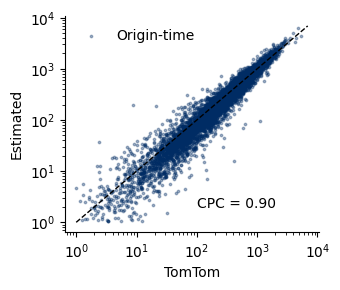

Validation Results:
- Method: xgboost
- ReMAE: 1.9030e-01
- CPC: 9.0486e-01
- RMSE: 1.5595e+04
- Length: 5674


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_scatter_log10(
    pred_df, true_df, attributes, method_name, region,
    att_s, max_val=None, k=None, point_color="crimson",
    fig_size=(3.5, 3.0)
):
    """
    Scatter plot of predicted vs true counts aggregated by `attributes`
    (e.g., ['ORIGIN_SUBZONE', 'TRIP_STARTTIME']) with log10 axes.
    Includes CPC metric and 1:1 reference line. No intra/inter split.
    """

    # ---- 1) Aggregate and deduplicate by attributes ----
    pred_df_ = pred_df[attributes + ['COUNT']].copy()
    true_df_ = true_df[attributes + ['COUNT']].copy()

    pred_df_['COUNT'] = pred_df_.groupby(attributes)['COUNT'].transform('sum')
    true_df_['COUNT'] = true_df_.groupby(attributes)['COUNT'].transform('sum')

    pred_df_.drop_duplicates(inplace=True)
    true_df_.drop_duplicates(inplace=True)

    # ---- 2) Merge on attributes ----
    merged = pd.merge(pred_df_, true_df_, on=attributes, suffixes=('_pred', '_true'))

    # ---- 3) Metrics ----
    # ReMAE, RMSE, CPC computed on counts (rename to PROB_* to keep your naming)
    merged['PROB_pred'] = merged['COUNT_pred']
    merged['PROB_true'] = merged['COUNT_true']

    rmae = np.sum(np.abs(merged['PROB_pred'] - merged['PROB_true'])) / np.sum(merged['PROB_true'])
    rmse = np.mean((merged['PROB_pred'] - merged['PROB_true']) ** 2)
    cpc = (2 * np.sum(np.minimum(merged['PROB_pred'], merged['PROB_true'])) /
           (np.sum(merged['PROB_pred']) + np.sum(merged['PROB_true'])))

    # ---- 4) Plot ----
    plt.figure(figsize=fig_size)
    ax = plt.gca()

    # Points (single group: origin-time)
    ax.scatter(
        merged['PROB_true'],
        merged['PROB_pred'],
        s=3, alpha=0.35, color=point_color, label=att_s
    )

    # Reference line extent
    if max_val is None:
        max_val_ = max(merged['PROB_true'].max(), merged['PROB_pred'].max())
    else:
        max_val_ = float(max_val)

    # Ensure lower bound > 0 for log scale; use 1 if you already filtered small counts
    min_ref = 1.0
    ax.plot([min_ref, max_val_ * 1.1], [min_ref, max_val_ * 1.1],
            color="black", linestyle="--", linewidth=1)

    # Log scaling + tick formatting
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(mticker.LogFormatterMathtext())
    ax.yaxis.set_major_formatter(mticker.LogFormatterMathtext())

    # Cosmetic: hide top/right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel("TomTom")
    ax.set_ylabel("Estimated")

    # Legend (no frame)
    ax.legend(frameon=False)

    # CPC text inside plot (place it near lower-right in log space)
    ax.text(10**2., 10**0.5, f'CPC = {cpc:.2f}', va='top')

    plt.tight_layout()

    if att_s == 'Origin-time':
        fname = f'case_validation_{region}_orig_time.png'
    elif att_s == 'Destination-time':
        fname = f'case_validation_{region}_dest_time.png'
    plt.savefig(path_od_figure + fname, dpi=400, bbox_inches='tight')
    plt.show()

    # Print metrics
    print(
        "Validation Results:\n"
        f"- Method: {method_name}\n"
        f"- ReMAE: {rmae:.4e}\n"
        f"- CPC: {cpc:.4e}\n"
        f"- RMSE: {rmse:.4e}\n"
        f"- Length: {len(merged)}"
    )

    return cpc



################################################

colors = ['crimson', '#002C64']

wws = ['mon_wed', 'thu_fri', 'sat_sun']
model = 'xgboost'
reg = 'sgp'
week_day = wws[0]
fig_x = 3.5
fig_y = 3
k = '1.0'

# Interchange between origin and destination
att = ['ORIGIN_SUBZONE', 'TRIP_STARTTIME' ]
#att = ['DESTINATION_SUBZONE', 'TRIP_STARTTIME' ]

true_df = pd.read_csv(path_od_result + f'case_{reg}_matrix_tomtom_{week_day}.csv')
result_df = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')
result_df['COUNT'] = result_df['VH_COUNT']

true_df = true_df[att + ['COUNT']]
true_df['COUNT'] = true_df.groupby(att)['COUNT'].transform('sum')
true_df.drop_duplicates(inplace=True)
print('sum true ', true_df['COUNT'].sum())

result_df = result_df[att + ['COUNT']]
result_df['COUNT'] = result_df.groupby(att)['COUNT'].transform('sum')
result_df.drop_duplicates(inplace=True)

cap_val = 1

true_df = true_df[true_df['COUNT'] >=cap_val]
result_df = result_df[result_df['COUNT'] >=cap_val]

max_val_od = max(result_df['COUNT'].max(), true_df['COUNT'].max())
print('sum result ', result_df['COUNT'].sum())

cpc = plot_scatter_log10(
    result_df, true_df,
    attributes=att,
    method_name=model,
    region=reg,
    att_s='Origin-time',                 # optional, not used inside now
    #att_s='Destination-time',                 # optional, not used inside now
    max_val=max_val_od,
    k=k,
    point_color=colors[1],      # e.g., '#4e79a7'
    fig_size=(fig_x, fig_y)
)


# SFig multiday

mode: PT
week_day: mon_wed
week_day: thu_fri
week_day: sat_sun
week_day: mon_wed


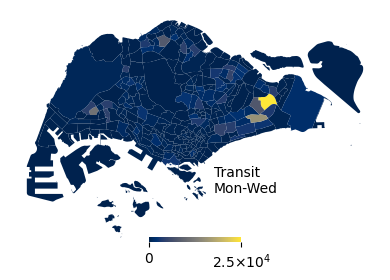

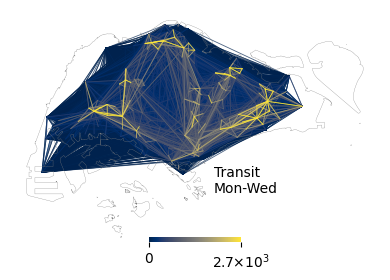

week_day: thu_fri


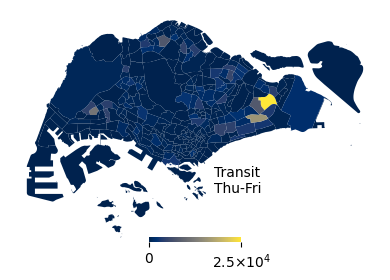

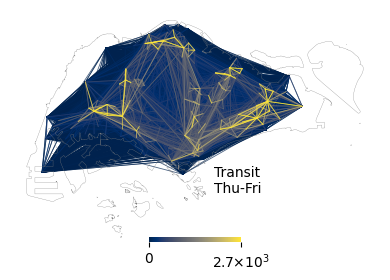

week_day: sat_sun


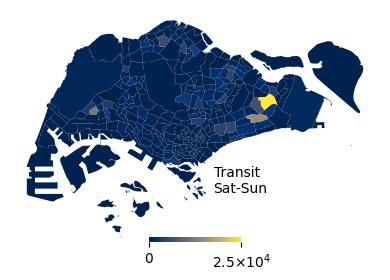

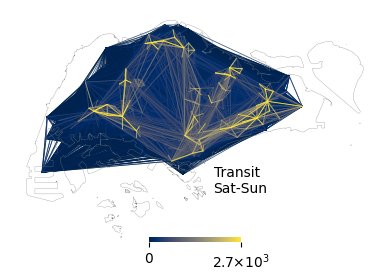

mode: VH
week_day: mon_wed
week_day: thu_fri
week_day: sat_sun
week_day: mon_wed


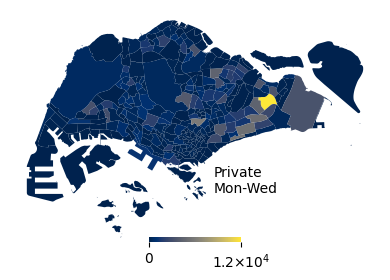

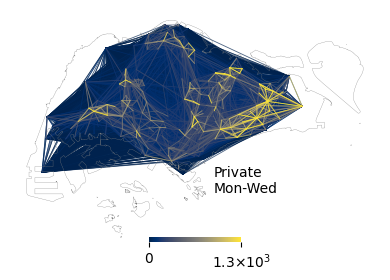

week_day: thu_fri


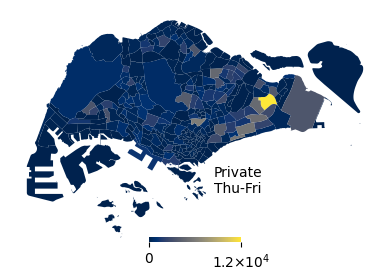

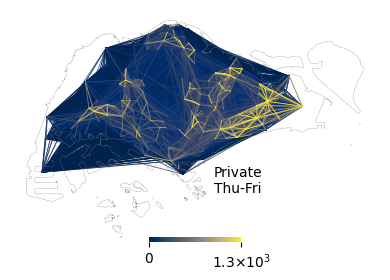

week_day: sat_sun


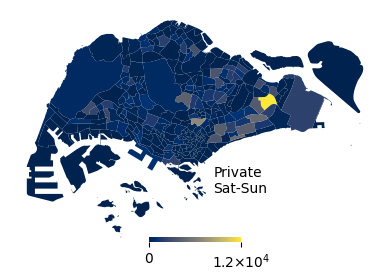

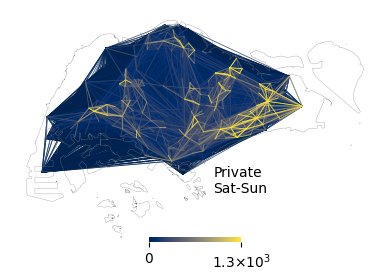

mode: WK
week_day: mon_wed
week_day: thu_fri
week_day: sat_sun
week_day: mon_wed


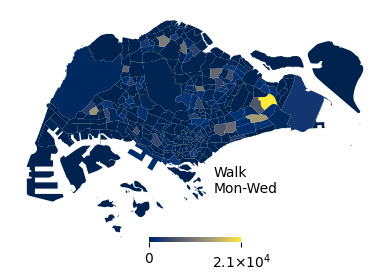

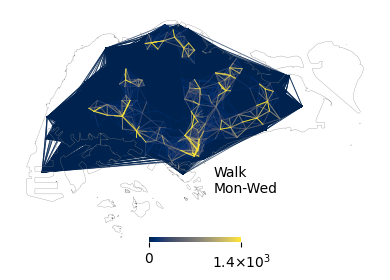

week_day: thu_fri


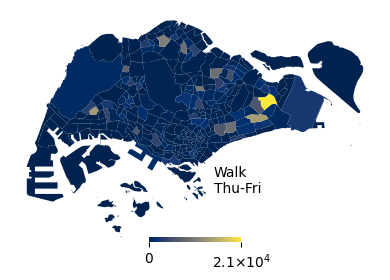

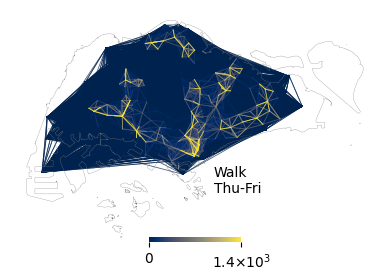

week_day: sat_sun


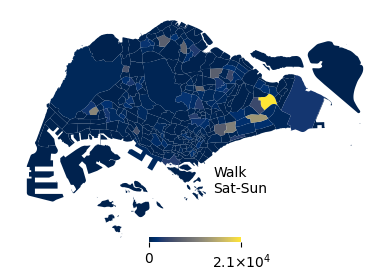

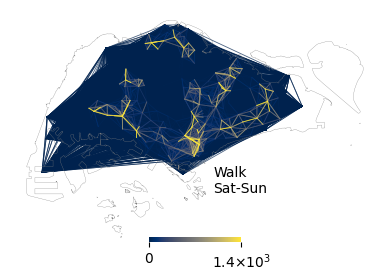

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def sci_notation(val, prec=1):
    """Format number: plain if <100, else a×10^n."""
    if abs(val) < 100:   # show plain integer/float
        return str(int(round(val))) if val.is_integer() else f"{val:.{prec}f}"
    else:
        s = f"{val:.{prec}e}"  # e.g., 1.23e+05
        base, exp = s.split("e")
        exp = int(exp)
        return rf"{base}×10$^{exp}$"


def plot_departure_line(df_, mode, week_day, maxz=None):
    """
    Plot departure time distribution as a professional line chart.

    Parameters
    ----------
    df_ : DataFrame
        Must contain ['TRIP_STARTTIME', 'COUNT'] columns.
    maxz : float
        Maximum y value (used for scaling the y-axis).
    """

    # -----------------------------
    # Data prep
    # -----------------------------
    df_plot = df_.copy()
    fig, ax = plt.subplots(figsize=(fig_x_t, fig_y_t), constrained_layout=True)

    # -----------------------------
    # Line plot
    # -----------------------------
    ax.plot(
        df_plot['TRIP_STARTTIME'],
        df_plot['COUNT'],
        #color='darkcyan',
        linewidth=1.0,
        #marker='o',
        #markersize=4,
        label="Trips"
    )

    # -----------------------------
    # Axis formatting
    # -----------------------------

    if maxz == None:
        maxz = df_plot['COUNT'].max()
    ax.set_ylim(0, maxz)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    # Labels
    ax.set_xlabel("Departure time")
    ax.set_ylabel("Trip count")

    # -----------------------------
    # Clean style
    # -----------------------------
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major')

    # -----------------------------
    # Clean style: thin spines
    # -----------------------------
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', width=0.5)

    # Legend
    #ax.legend(frameon=False)

    plt.tight_layout()

    # -----------------------------
    # Export-ready
    # -----------------------------
    out_path = path_od_figure + f"case_{reg}_time_{mode}_{week_day}.png"
    fig.savefig(out_path, dpi=600, bbox_inches='tight')

    plt.show()


def plot_OD_subzone_intra(
    dfz,
    mode,
    week_day,
    max_prob=None
):
    """
    Intra-zone, continuous colormap, missing zones get COUNT=0.
    Colorbar inside plot with only 0 and max value (scientific with mantissa).
    """
    # 1) load all subzones
    gdf = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')

    # 2) compute intra-zone counts
    intra    = dfz[dfz.ORIGIN_SUBZONE == dfz.DESTINATION_SUBZONE]
    zone_sum = intra.groupby('DESTINATION_SUBZONE')['COUNT'].sum()

    # 3) map counts onto full GeoDataFrame, fill missing with zero
    gdf['COUNT'] = gdf['SUBZONE_C'].map(zone_sum).fillna(0)

    # 4) determine normalization
    if max_prob is None:
        max_prob = gdf['COUNT'].max()
    norm = Normalize(vmin=0, vmax=max_prob)
    cmap = cm.get_cmap(color_map)

    # 5) plot map
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    ax.set_axis_off()
    gdf.plot(
        column='COUNT',
        cmap=cmap,
        norm=norm,
        ax=ax,
        edgecolor='none',
        linewidth=0,
        alpha=1.0,
        antialiased=True
    )


    wd = 'Mon-Wed'
    if week_day == 'thu_fri':
        wd = 'Thu-Fri'
    elif week_day == 'sat_sun':
        wd = 'Sat-Sun'

    mm = 'Transit'
    if mode == 'VH':
        mm = 'Private'
    elif mode == 'WK':
        mm = 'Walk'

    plt.gca().text(
        0.55, 0.35, f'{mm}\n{wd}',
        transform=plt.gca().transAxes,
        verticalalignment='top'
    )

    # overlay boundaries
    gdf.boundary.plot(ax=ax, color='none', linewidth=0.0)

    # --- Colorbar inside plot ---
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = inset_axes(ax, width="25%", height="2%", loc='lower center', borderpad=0.5)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')

    # show only two ticks: 0 and max
    cbar.set_ticks([0, max_prob])
    cbar.set_ticklabels(["0", sci_notation(max_prob, prec=1)])

    # remove border line around colorbar
    for spine in cbar.ax.spines.values():
        spine.set_visible(False)



    plt.tight_layout()
    out_path = path_od_figure + f"case_{reg}_intra_zone_{mode}_{week_day}.png"
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_OD_subzone_inter(
    dfz,
    mode,
    week_day,
    max_prob=None
):
    """
    Inter-zone flows with a continuous colormap.
    If `od_order` (with ORDER_IDX) is provided, the plot strictly follows that order.
    Colorbar style matches the intra-zone plot: inside map, ticks at 0 and max (scientific).
    """
    df = dfz.copy()

    df_plot = df.sort_values('COUNT', ascending=True)

    # Colormap & normalization (match intra)
    if max_prob is None:
        max_prob = df_plot['COUNT'].max()
    norm = Normalize(vmin=0, vmax=max_prob)
    cmap = cm.get_cmap(color_map)

    # Boundaries (for extent/overlay)
    gdf = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
    boundary = gdf.dissolve()

    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    ax.set_axis_off()

    # Draw inter-zone curves
    for _, row in df_plot.iterrows():
        x0, y0 = row['ORIGIN_SUBZONE_X'],      row['ORIGIN_SUBZONE_Y']
        x1, y1 = row['DESTINATION_SUBZONE_X'], row['DESTINATION_SUBZONE_Y']
        ctrl_x, ctrl_y = (x0 + x1) / 2.0, (y0 + y1) / 2.0
        t = np.linspace(0, 1, 50)
        xs = (1 - t)**3 * x0 + 3*(1 - t)**2*t*ctrl_x + 3*(1 - t)*t**2*ctrl_x + t**3 * x1
        ys = (1 - t)**3 * y0 + 3*(1 - t)**2*t*ctrl_y + 3*(1 - t)*t**2*ctrl_y + t**3 * y1
        ax.plot(xs, ys, color=cmap(norm(row['COUNT'])), linewidth=0.6, alpha=0.7)

    boundary.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.2, zorder=3)

    wd = 'Mon-Wed'
    if week_day == 'thu_fri':
        wd = 'Thu-Fri'
    elif week_day == 'sat_sun':
        wd = 'Sat-Sun'

    mm = 'Transit'
    if mode == 'VH':
        mm = 'Private'
    elif mode == 'WK':
        mm = 'Walk'

    plt.gca().text(
        0.55, 0.35, f'{mm}\n{wd}',
        transform=plt.gca().transAxes,
        verticalalignment='top'
    )

    # --- Colorbar INSIDE the map, 2 ticks (0 & max), scientific mantissa format ---
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = inset_axes(ax, width="25%", height="2%", loc='lower center', borderpad=0.5)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_ticks([0, max_prob])
    cbar.set_ticklabels(["0", sci_notation(max_prob, prec=1)])

    # Remove colorbar border
    for spine in cbar.ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    out_path = path_od_figure + f"case_{reg}_inter_zone_{mode}_{week_day}.png"
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()


def departure_demand(df, mode):
    df_fus_ = df.copy()
    df_fus_['COUNT'] = df_fus_[mode + '_COUNT']
    df_fus_ = df_fus_[['TRIP_STARTTIME', 'COUNT']]
    df_fus_['COUNT'] = df_fus_.groupby(['TRIP_STARTTIME'])['COUNT'].transform('sum')
    df_fus_.drop_duplicates(inplace = True)
    df_fus_.sort_values('TRIP_STARTTIME', inplace=True)
    return df_fus_
    #plot_departure_line(df_fus_, maxz=None)

def intra_zone_demand(df, mode):
    data_subzone = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
    data_subzone['X'] = data_subzone.geometry.centroid.x
    data_subzone['Y'] = data_subzone.geometry.centroid.y
    data_subzone = data_subzone[['SUBZONE_C', 'X', 'Y']]

    df_ = df.copy()
    df_['COUNT'] = df_[mode + '_COUNT']
    df_ = df_[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']]

    df_ = df_.merge(data_subzone, right_on='SUBZONE_C', left_on='ORIGIN_SUBZONE')
    df_.drop(columns=['SUBZONE_C'], inplace=True)
    df_.rename(columns={'X':'ORIGIN_SUBZONE_X', 'Y':'ORIGIN_SUBZONE_Y'}, inplace=True)
    df_ = df_.merge(data_subzone, right_on='SUBZONE_C', left_on='DESTINATION_SUBZONE')
    df_.drop(columns=['SUBZONE_C'], inplace=True)
    df_.rename(columns={'X':'DESTINATION_SUBZONE_X', 'Y':'DESTINATION_SUBZONE_Y'}, inplace=True)

    df_ = df_[['ORIGIN_SUBZONE', 'ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y','COUNT']]
    df_['COUNT'] = df_.groupby(['ORIGIN_SUBZONE','ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y'])['COUNT'].transform('sum')
    df_.drop_duplicates(inplace = True)
    df_.sort_values(by=['COUNT'], ascending=False, inplace=True)

    df_ = df_[df_['ORIGIN_SUBZONE'] == df_['DESTINATION_SUBZONE']]
    return df_
    #plot_OD_subzone_intra(df_)


def inter_zone_demand(df, mode):
    data_subzone = gpd.read_file(path_od_data + f'data_{reg}_subzone.shp')
    data_subzone['X'] = data_subzone.geometry.centroid.x
    data_subzone['Y'] = data_subzone.geometry.centroid.y
    data_subzone = data_subzone[['SUBZONE_C', 'X', 'Y']]

    df_ = df.copy()
    df_['COUNT'] = df_[mode + '_COUNT']
    df_ = df_[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'COUNT']]

    df_ = df_.merge(data_subzone, right_on='SUBZONE_C', left_on='ORIGIN_SUBZONE')
    df_.drop(columns=['SUBZONE_C'], inplace=True)
    df_.rename(columns={'X':'ORIGIN_SUBZONE_X', 'Y':'ORIGIN_SUBZONE_Y'}, inplace=True)
    df_ = df_.merge(data_subzone, right_on='SUBZONE_C', left_on='DESTINATION_SUBZONE')
    df_.drop(columns=['SUBZONE_C'], inplace=True)
    df_.rename(columns={'X':'DESTINATION_SUBZONE_X', 'Y':'DESTINATION_SUBZONE_Y'}, inplace=True)

    df_ = df_[['ORIGIN_SUBZONE', 'ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y','COUNT']]
    df_['COUNT'] = df_.groupby(['ORIGIN_SUBZONE','ORIGIN_SUBZONE_X', 'ORIGIN_SUBZONE_Y', 'DESTINATION_SUBZONE', 'DESTINATION_SUBZONE_X', 'DESTINATION_SUBZONE_Y'])['COUNT'].transform('sum')
    df_.drop_duplicates(inplace = True)
    df_.sort_values(by=['COUNT'], ascending=False, inplace=True)

    df_ = df_[df_['ORIGIN_SUBZONE'] != df_['DESTINATION_SUBZONE']]
    return df_
    #plot_OD_subzone_inter(df_)


#########################################

#week_days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
week_days = ['mon_wed', 'thu_fri', 'sat_sun']
modes = ['PT', 'VH', 'WK']
model = 'xgboost'
reg = 'sgp'
k = '1.0'
color_map = 'cividis' #'autumn_r'#'gist_heat_r'#'plasma' #'Spectral_r'#'viridis'# #gist_heat_r

fig_x_t = 2
fig_y_t = 1.7

fig_x = 4
fig_y = 4


for mode in modes:
    print(f'mode: {mode}')

    val_intra = 0
    val_inter = 0

    for week_day in week_days:
        print(f'week_day: {week_day}')
        df_fus = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')
        df_intra = intra_zone_demand(df_fus, mode)
        df_inter = inter_zone_demand(df_fus, mode)
        val_intra = max(val_intra, df_intra['COUNT'].quantile(0.999))
        val_inter = max(val_inter, df_inter['COUNT'].quantile(0.999))

    for week_day in week_days:
        print(f'week_day: {week_day}')
        df_fus = pd.read_csv(path_od_result + f'case_{reg}_matrix_generated_{week_day}.csv')

        df_intra = intra_zone_demand(df_fus, mode)
        df_inter = inter_zone_demand(df_fus, mode)

        #plot_departure_line(df_time, mode, week_day, maxz=df_time['COUNT'].max())
        plot_OD_subzone_intra(df_intra, mode, week_day, max_prob=val_intra) #df_intra['COUNT'].max()
        plot_OD_subzone_inter(df_inter, mode, week_day, max_prob=val_inter) #df_inter['COUNT'].max()


# SFig TomTom unscaled

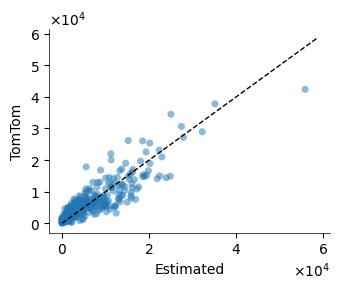

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import FuncFormatter

# --- Load data ---
tomtom_scale_df = pd.read_csv(path_od_result + 'case_sgp_matrix_tomtom_mon_wed.csv')
tomtom_no_scale_df = pd.read_csv(path_od_data + 'data_sgp_pcm_2022_period_mon_wed.csv')
tomtom_no_scale_df = tomtom_no_scale_df.merge(
    tomtom_scale_df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME']].drop_duplicates()
)
spatial_marginal_df = pd.read_csv(path_od_result + 'prior_sgp_trip_generation_VH_mon.csv')

# --- Aggregate spatial counts ---
sptial_tomtom_scale_df = (
    tomtom_scale_df.groupby("ORIGIN_SUBZONE", as_index=False)["COUNT"].sum()
)
sptial_tomtom_no_scale_df = (
    tomtom_no_scale_df.groupby("ORIGIN_SUBZONE", as_index=False)["COUNT"].sum()
)

# --- Rescale function ---
def rescale_to_match(df_target, df_ref, col="COUNT"):
    df = df_target.copy()
    factor = df_ref[col].sum() / df[col].sum()
    df[col] = df[col] * factor
    return df

# --- Rescale TomTom datasets to match marginal total ---
sptial_tomtom_scale_rescaled = rescale_to_match(sptial_tomtom_scale_df, spatial_marginal_df)
sptial_tomtom_no_scale_rescaled = rescale_to_match(sptial_tomtom_no_scale_df, spatial_marginal_df)

# --- Merge with marginal ---
df_scale = sptial_tomtom_scale_rescaled.merge(
    spatial_marginal_df, on="ORIGIN_SUBZONE", suffixes=("_tomtom_scale", "_marginal")
)
df_no_scale = sptial_tomtom_no_scale_rescaled.merge(
    spatial_marginal_df, on="ORIGIN_SUBZONE", suffixes=("_tomtom_no_scale", "_marginal")
)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Example color palette
colors = ["#1f77b4", "#ff7f0e"]
fig_x, fig_y = 3.5, 3

def plot_spatial_scatter(df_tomtom, df_marginal, tomtom_label, fname, path_od_figure):
    """
    Minimal scatter plot of TomTom vs Marginal spatial totals (per ORIGIN_SUBZONE).
    Shows only scatter points and 45° line. Axes use scientific notation like plot_departure.
    """
    # --- Merge ---
    merged_df = df_tomtom.merge(
        df_marginal, on="ORIGIN_SUBZONE", suffixes=("_tomtom", "_marginal")
    )
    merged_df['PROB_pred'] = merged_df['COUNT_tomtom']
    merged_df['PROB_true'] = merged_df['COUNT_marginal']

    # --- Plot ---
    plt.figure(figsize=(fig_x, fig_y))
    plt.scatter(
        merged_df['PROB_true'], merged_df['PROB_pred'],
        s=26, alpha=0.5, color=colors[0], edgecolor="none"
    )

    max_val = max(merged_df['PROB_true'].max(), merged_df['PROB_pred'].max())
    plt.plot([0, max_val*1.05], [0, max_val*1.05],
             color="black", linestyle="--", linewidth=1)

    # Equal axis scaling
    #plt.axis("equal")

    # Clean axes
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    # Labels
    plt.xlabel("Estimated")
    plt.ylabel(tomtom_label)

    # --- Apply scientific formatter like plot_departure ---
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))   # always scientific notation
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.savefig(path_od_figure + fname, dpi=200, bbox_inches='tight')
    plt.show()



# Scaled vs Marginal
'''plot_spatial_scatter(
    sptial_tomtom_scale_rescaled.rename(columns={"COUNT":"COUNT_tomtom"}),
    spatial_marginal_df.rename(columns={"COUNT":"COUNT_marginal"}),
    tomtom_label="TomTom (IPF)",
    fname="case_spatial_scaled_vs_marginal.png",
    path_od_figure=path_od_figure
)'''

# No-scale vs Marginal
plot_spatial_scatter(
    sptial_tomtom_no_scale_rescaled.rename(columns={"COUNT":"COUNT_tomtom"}),
    spatial_marginal_df.rename(columns={"COUNT":"COUNT_marginal"}),
    tomtom_label="TomTom",
    fname="sgp_spatial_noscale_vs_marginal.png",
    path_od_figure=path_od_figure
)




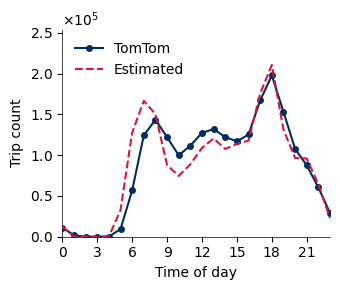

Rescale factor (no-scale -> marginal): 1.1834
Rescale factor (scaled  -> marginal): 0.9756


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator

# --- Global settings ---
colors = ['crimson', '#002C64']   # Marginal, TomTom
fig_x = 3.5
fig_y = 3

# --- Load data ---
tomtom_scale_df = pd.read_csv(path_od_result + 'case_sgp_matrix_tomtom_mon_wed.csv')
tomtom_no_scale_df = pd.read_csv(path_od_data + 'data_sgp_pcm_2022_period_mon_wed.csv')
tomtom_no_scale_df = tomtom_no_scale_df.merge(
    tomtom_scale_df[['ORIGIN_SUBZONE', 'DESTINATION_SUBZONE', 'TRIP_STARTTIME']].drop_duplicates()
)

spatial_marginal_df = pd.read_csv(path_od_result + 'prior_sgp_trip_generation_VH_mon.csv')
temporal_marginal_df = pd.read_csv(path_od_result + 'prior_sgp_departure_time_VH_mon.csv')

# --- Aggregate temporal totals (0–23) ---
temporal_tomtom_scale_df = tomtom_scale_df[['TRIP_STARTTIME', 'COUNT']].copy()
temporal_tomtom_scale_df['COUNT'] = temporal_tomtom_scale_df.groupby('TRIP_STARTTIME')['COUNT'].transform('sum')
temporal_tomtom_scale_df = temporal_tomtom_scale_df.drop_duplicates().sort_values('TRIP_STARTTIME').reset_index(drop=True)

temporal_tomtom_no_scale_df = tomtom_no_scale_df[['TRIP_STARTTIME', 'COUNT']].copy()
temporal_tomtom_no_scale_df['COUNT'] = temporal_tomtom_no_scale_df.groupby('TRIP_STARTTIME')['COUNT'].transform('sum')
temporal_tomtom_no_scale_df = temporal_tomtom_no_scale_df.drop_duplicates().sort_values('TRIP_STARTTIME').reset_index(drop=True)

temporal_marginal_df = temporal_marginal_df[['TRIP_STARTTIME','COUNT']].copy()
temporal_marginal_df = temporal_marginal_df.groupby('TRIP_STARTTIME', as_index=False)['COUNT'].sum()
temporal_marginal_df = temporal_marginal_df.sort_values('TRIP_STARTTIME').reset_index(drop=True)

# --- Rescale helper: match total of target to reference total ---
def rescale_to_match_total(df_target, df_ref, col='COUNT'):
    df = df_target.copy()
    t_sum = df[col].sum()
    r_sum = df_ref[col].sum()
    factor = (r_sum / t_sum) if t_sum != 0 else 1.0
    df[col] = df[col] * factor
    return df, factor

# Rescale TomTom series to marginal totals BEFORE comparison
temporal_tomtom_no_scale_rescaled, f_no = rescale_to_match_total(temporal_tomtom_no_scale_df, temporal_marginal_df)
temporal_tomtom_scale_rescaled,    f_sc = rescale_to_match_total(temporal_tomtom_scale_df,    temporal_marginal_df)

# --- Temporal plotting function ---
def plot_temporal_comparison(df_tomtom, df_marginal, label_tomtom, fname, path_od_figure, maxz=None):
    """
    Plot line graph comparing temporal TomTom (rescaled) vs temporal marginal counts.
    """
    plt.figure(figsize=(fig_x, fig_y))

    # TomTom (already rescaled)
    plt.plot(df_tomtom['TRIP_STARTTIME'], df_tomtom['COUNT'],
             color=colors[1], marker='o', markersize=4,
             linewidth=1.5, label=label_tomtom, zorder=3)

    # Marginal
    plt.plot(df_marginal['TRIP_STARTTIME'], df_marginal['COUNT'],
             color=colors[0], linestyle='--', linewidth=1.5,
             label="Estimated", zorder=3)

    # Axes setup
    ax = plt.gca()
    if maxz is None:
        maxz = max(df_tomtom['COUNT'].max(), df_marginal['COUNT'].max())
    ax.set_ylim(0, maxz * 1.2)
    ax.set_xlim(0, 23)

    # Y-axis scientific formatting
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(formatter)

    # Clean style
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    # Force integer x ticks (hours)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.xlabel("Time of day")
    plt.ylabel("Trip count")

    # Legend top-left, no frame
    plt.legend(loc="upper left", frameon=False)

    plt.tight_layout()
    plt.savefig(path_od_figure + fname, dpi=200, bbox_inches="tight")
    plt.show()

# --- Common y-limit so the two plots are directly comparable ---
common_max = max(
    temporal_tomtom_no_scale_rescaled['COUNT'].max(),
    temporal_tomtom_scale_rescaled['COUNT'].max(),
    temporal_marginal_df['COUNT'].max()
)

# --- Run plots (using RESCALED TomTom series) ---

# No-scale vs marginal (rescaled)
plot_temporal_comparison(
    temporal_tomtom_no_scale_rescaled,
    temporal_marginal_df,
    label_tomtom="TomTom",
    fname="sgp_temporal_noscale_vs_marginal_rescaled.png",
    path_od_figure=path_od_figure,
    maxz=common_max
)

# Scaled vs marginal (rescaled)
'''plot_temporal_comparison(
    temporal_tomtom_scale_rescaled,
    temporal_marginal_df,
    label_tomtom="TomTom",
    fname="sgp_temporal_scaled_vs_marginal_rescaled.png",
    path_od_figure=path_od_figure,
    maxz=common_max
)
'''
# Optional: print scale factors for transparency
print(f"Rescale factor (no-scale -> marginal): {f_no:.4f}")
print(f"Rescale factor (scaled  -> marginal): {f_sc:.4f}")
